## Constraint function

In [1]:
import numpy as np
# import tensorflow as tf
import scipy # need scipy 1.4.1 to work with GPyOpt
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
# !pip install Gpy
import GPy
# !pip install gpyopt
import GPyOpt_constraints
from GPyOpt_constraints.methods import BayesianOptimization
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
from pymc3 import Model, Normal, Slice, sample, traceplot
from pymc3.distributions import Interpolated
from scipy import stats
from theano import as_op
import os

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# change these paths if you want to sve the figures, otherwise, you don't have to run this block
cwd = os.path.split(os.path.split(os.path.split(os.getcwd())[0])[0])[0]
impath = cwd + '\\07_Figure_Graphs\\Working_Folder\\'

global min @ x1 = 0.79, x2 = 0.79, z = -7.883282055049491
feasible min @ x1 = 0.48, x2 = 0.48, z = -4.763250853905904


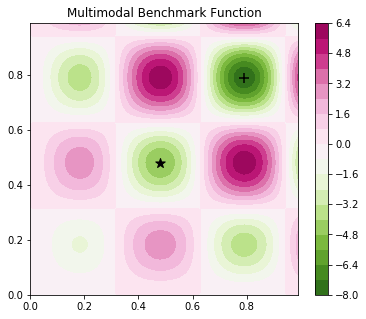

In [3]:
# Plot the multimodal function in 2D

# multimodal function
def z(X,Y):
    X, Y = [X * 10, Y * 10] # take normalized [0,1] value and scale up to [0,10]
    return - (np.sqrt(X)*np.sin(X))*(np.sqrt(Y)*np.sin(Y)) # https://towardsdatascience.com/optimization-eye-pleasure-78-benchmark-test-functions-for-single-objective-optimization-92e7ed1d1f12


xi = np.arange(0,1,0.01)
X, Y = np.meshgrid(xi,xi)
Z = z(X,Y)
plt.figure(figsize=(6,5))
f = plt.contourf(X,Y,Z,20,cmap='PiYG_r')
zmin = np.where(Z == np.min(Z))
zminval = Z[zmin[0][0], zmin[1][0]]
xmin = X[zmin[0][0], zmin[1][0]]
ymin = Y[zmin[0][0], zmin[1][0]]
xfeas, yfeas = [0.48, 0.48] # feasible optimum at [0.48, 0.48], global optimum at [0.79, 0.79]
zfeas = Z[int(xfeas*100),int(yfeas*100)]
plt.scatter(xmin,ymin,marker='+',color='k',s=100)
plt.scatter(xfeas,yfeas,marker='*',color='k',s=100)
plt.colorbar(f)
plt.title('Multimodal Benchmark Function')

print(f'global min @ x1 = {xmin}, x2 = {ymin}, z = {zminval}')
print(f'feasible min @ x1 = {xfeas}, x2 = {yfeas}, z = {zfeas}')

In [4]:
# LHS
def latin_hypercube(D,N):
    '''
    D=number of dimensions
    N=number of desired samples
    '''
    # normalize dimensions to 1
    lower_lim=np.arange(0,N)/N
    upper_lim=np.arange(1,N+1)/N
    # randomly select points using uniform sampling within limit ranges
    samples=np.random.uniform(low=lower_lim,high=upper_lim,size=[D,N]).T
    for t in range(D-1):
        np.random.shuffle(samples[:,t]) # randomize D-1 dimensions ordering
    return samples


# Euclidean distance calculation
def euclidean_distance(point, xfeas = 0.48, yfeas = 0.48):
    return np.sqrt((point[0] - xfeas)**2 + (point[1] - yfeas)**2)

# Activation functions
def activation(constraint, scale, bias):
    return constraint * scale + bias

# Compute a moving mean
def movingMeanFast(x, N):
    '''
    Compute the moving mean of an (D1, D2) dimensional array.
    D1 are the experiments and D2 are the number of ensemble exps.
    '''
    cols = x.shape[1]
    X = np.zeros((x.shape[0], cols))
    for col in range(cols):
        X[:, col] = np.convolve(x[:, col], np.ones((N,))/N)[(N-1):]
    return X

# Create BO functions
def run_BO(x_conds,y_conds,constraint,probability_function):
    '''
    Implement Bayesian optimization.
    
    ** constraint_function must be a numpy array of shape (100,100) for 2D.
    
    Uses the expected improvement (EI) acquisition with local penalization and Matern5/2-ARD kernel.
    Generates a batch size of 1 suggested condition. 
    
    Inputs:
    x_conds             := input condition matrix (n by 2) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
    constraint          := a string for 2D constraint, e.g., 'x[:,0] + x[:,1] - 1.4' for the 
                           constraint X + Y - 1.4. Use None for no constraint.
    probability_function:= is a (100,100) array of constraint values. Use None for no constraint function.
      
    Ouputs:
    x_next              := suggested next x-conditions to sample from
    '''
    # run BO on the x-conditions conditions and their respective y-values
    bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)}, # 2D bounds
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)}
          ]
    cnstr = None
    if constraint is None:
        pass
    else:
        cnstr = [
    {
        'name': 'constr_1',
        'constraint': constraint
    }]
    acq = 'EI'
    if probability_function is None:
        pass
    else:
        acq = 'constrained_EI'
    kernel = GPy.kern.Matern52(input_dim=len(bds), ARD = True) # Use the matern 5/2 kernel with automatic relevence detection enabled
    BO_opt = BayesianOptimization(f=None, 
                                     domain=bds,
                                     constraints = cnstr,
                                     model_type='GP', # gaussian process model
                                     constraint_function=probability_function, # must be a numpy array of three 2D surfaces with shape (3,100,100)
                                     acquisition_type =acq,
                                     X=x_conds, # input data
                                     Y=y_conds, # associated labels
                                     evaluator_type = 'local_penalization', # unused if batch_size = 1
                                     batch_size = 1, # batch size of predicted optima
                                     normalize_Y= False,
                                     kernel = kernel # select the kernel
                                     )
#     BO_opt.plot_acquisition()
    x_next = BO_opt.suggest_next_locations()
    return x_next

numMean = 2 # number of points to take moving average about. Increasing this value decreases timeseries noise.
def BO_procedure(exps, ensemble, init, constraint, probability_function, plot = False, numMean = numMean):
    print('Starting BO . . .')
    min_arr = np.array(np.zeros((exps+init, ensemble))) # array to plug in all minY vectors
    dist_arr = np.array(np.zeros((exps+init, ensemble))) # array to plug in all minD vectors
    inst_dist_arr = np.array(np.zeros((exps+init, ensemble))) # array to plug in instantaneous euclidean distance vectors, not the running minimums
    for t in range(ensemble):
        LHS = latin_hypercube(D=2, N=init) # randomize LHS selected points every loop
        Xs = LHS
        Ys = z(LHS[:,0],LHS[:,1])
        Ys = Ys.reshape(len(Ys),1)

        # run bo
        for n in range(exps):
            try:
                updx = run_BO(x_conds = Xs, y_conds = Ys, constraint = constraint, probability_function = probability_function)
                updy = z(updx[:,0],updx[:,1])
                Xs = np.concatenate((Xs,updx))
                Ys = np.concatenate((Ys,updy.reshape(1,1)))
            except:
                print('> LinAlg exception.')
                Xs = np.concatenate((Xs,updx)) # from the previous round
                Ys = np.concatenate((Ys,updy.reshape(1,1))) # from the previous round
                continue
            if plot == True:
                plt.figure(figsize=(6,5))
                f = plt.contourf(X,Y,Z,20,cmap='PiYG_r')
                zmin = np.where(Z == np.min(Z))
                xmin = X[zmin[0][0], zmin[1][0]]
                ymin = Y[zmin[0][0], zmin[1][0]]
                plt.scatter(xmin,ymin,marker='+',color='k',s=100)
                plt.scatter(Xs[:,0],Xs[:,1],c='k',alpha=0.5)
                plt.ylim(0,1)
                plt.xlim(0,1)
                plt.colorbar(f)
            #     plt.contourf(X,Y,cnstr,cmap='gray',alpha=0.3)
                plt.title('Multimodal Benchmark Function')
                plt.show()


        minY = [] # runnin minimum function value
        minY.append(Ys[0])
        D = [] # euclidean distance between point to feasible min
        D.append(euclidean_distance(Xs[0]))
        for n in range(len(Ys)-1):
            D.append(euclidean_distance(Xs[n+1]))
            if Ys[n+1] < minY[n]:
                minY.append(Ys[n+1])
            else:
                minY.append(minY[n])
        min_arr[:,t] = minY
        inst_dist_arr[:,t] = D
        
        # running minimum euclidean distance
        minD = []
        minD.append(euclidean_distance(Xs[0]))
        for n in range(len(Xs)-1):
            if euclidean_distance(Xs[n+1]) < minD[n]:
                minD.append(euclidean_distance(Xs[n+1]))
            else:
                minD.append(minD[n])
        dist_arr[:,t] = minD
        print(f'Completed model ensemble {t+1}/{ensemble}.')

    # compute moving mean of the euclidean distance regret from feasible minimum across all model exps
    moving_mean_dist = movingMeanFast(x = inst_dist_arr, N = numMean) # moving mean of 5 samples    
    
    # plot min function value
    samples = np.arange(1,exps+init+1,1)[:-numMean] # remove last numMean number of values for consistency with regret accuracy
    avg_min_max = np.array(np.zeros((exps+init,3)))[:-numMean, :] # columns: [average, lower 10th percentile, upper 90th percentile]
    avg_min_max[:, 0] = np.average(min_arr[:-numMean, :], axis=1) # average
    avg_min_max[:, 1] = np.percentile(min_arr[:-numMean, :], 10, axis=1) # 10th percentile
    avg_min_max[:, 2] = np.percentile(min_arr[:-numMean, :], 90, axis=1) # 90th percentile
    plt.plot(samples, avg_min_max[:, 0], linewidth=3, c='#04396b')
    plt.fill_between(samples, avg_min_max[:,1],avg_min_max[:,2], facecolor='#04396b', alpha = 0.4)
    plt.ylim([-9,0])
    plt.axhline(zfeas, c = '#04396b', ls = '--')
    plt.axhline(zminval, c = 'gray', ls = '--')
    plt.ylabel('Function Value')
    plt.xlabel('Sample')
    plt.show()

    # plot running minimum regret
    print('Running Minimum Regret')
    davg_min_max = np.array(np.zeros((exps+init,3)))[:-numMean, :] # columns: [average, lower 10th percentile, upper 90th percentile]
    davg_min_max[:, 0] = np.average(dist_arr[:-numMean, :], axis=1) # average
    davg_min_max[:, 1] = np.percentile(dist_arr[:-numMean, :], 10, axis=1) # 10th percentile
    davg_min_max[:, 2] = np.percentile(dist_arr[:-numMean, :], 90, axis=1) # 90th percentile
    plt.plot(samples, davg_min_max[:, 0], linewidth=3, c='#75001a')
    plt.fill_between(samples, davg_min_max[:,1], davg_min_max[:,2], facecolor='#75001a', alpha = 0.4)
    plt.ylim([-0.1,1])
    plt.axhline(0, c = '#75001a', ls = '--')
    plt.ylabel('Regret')
    plt.xlabel('Sample')
    plt.show()
    
    # plot instantaneous regret, not the running minimum
        # plotting just the running minimum does not allow us to see how long we stay in the zero-regret region
        # remove last numMean experiments from moving average as they have a tendency to be erroneously low
    print('Instantaneous Regret')
    idavg_min_max = np.array(np.zeros((exps+init,3)))[:-numMean, :] # columns: [average, lower 10th percentile, upper 90th percentile]
    idavg_min_max[:, 0] = np.average(moving_mean_dist[:-numMean, :], axis=1) # average
    idavg_min_max[:, 1] = np.percentile(moving_mean_dist[:-numMean, :], 10, axis=1) # 10th percentile
    idavg_min_max[:, 2] = np.percentile(moving_mean_dist[:-numMean, :], 90, axis=1) # 90th percentile
    plt.plot(samples, idavg_min_max[:, 0], linewidth=3, c='#75001a')
    plt.fill_between(samples, idavg_min_max[:,1], idavg_min_max[:,2], facecolor='#75001a', alpha = 0.4)
    plt.ylim([-0.1,1])
    plt.axhline(0, c = '#75001a', ls = '--')
    plt.ylabel('Regret')
    plt.xlabel('Sample')
    plt.show()
    
    return avg_min_max, min_arr # return averaged data and full data

In [5]:
exps = 100 + numMean # number of experiments for a given model run + numMean exps, which will be removed at the tail for moving mean consistency
ensemble = 50 # number of repeated model runs
init = 2 # number of initial LHS samples

### No constraint

global min @ x1 = 0.79, x2 = 0.79, z = -7.883282055049491


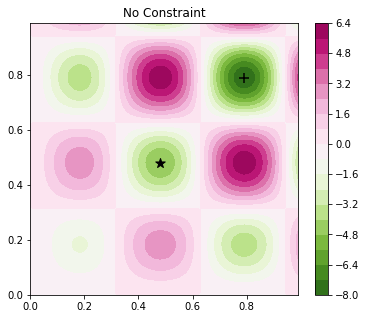

In [6]:
# No constraint
xi = np.arange(0,1,0.01)
X, Y = np.meshgrid(xi,xi)
Z = z(X,Y)
plt.figure(figsize=(6,5))
f = plt.contourf(X,Y,Z,20,cmap='PiYG_r')
plt.scatter(xmin,ymin,marker='+',color='k',s=100)
plt.scatter(xfeas, yfeas, marker='*', color='k', s=100)
# plt.scatter(LHS[:,0],LHS[:,1],c='k',alpha=0.3)
plt.colorbar(f)
plt.title('No Constraint')
print(f'global min @ x1 = {xmin}, x2 = {ymin}, z = {Z[zmin[0][0], zmin[1][0]]}')

Starting BO . . .
Completed model ensemble 1/50.
Completed model ensemble 2/50.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.


> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
Completed model ensemble 39/50.
Completed model ensemble 40/50.
Completed model ensemble 41/50.
> LinAlg exception.
Completed model ensemble 42/50.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
Completed model ensemble 43/50.
Completed model ensemble 44/50.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
Completed model ensemble 45/50.
Completed model ensemble 46/50.
Completed model ensemble 47/50.
Completed model ensemble 48/50.
Completed model ensemble 49/50.
Completed model ensemble 50/50.


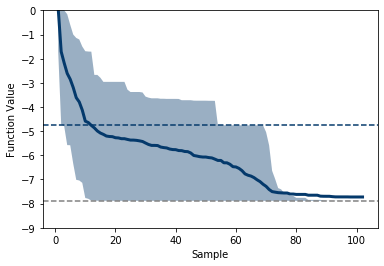

Running Minimum Regret


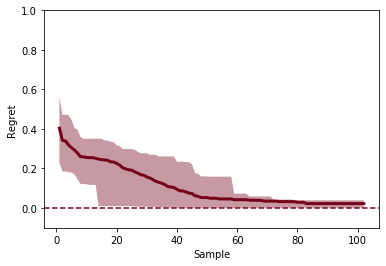

Instantaneous Regret


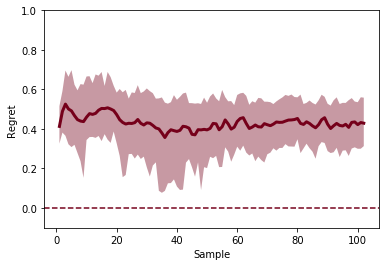

(array([[ 0.09559823, -1.66975396,  1.88725519],
        [-1.70784249, -4.72140144,  0.49248891],
        [-2.1800025 , -4.79710839,  0.        ],
        [-2.61072673, -5.57709635, -0.15798816],
        [-2.85120632, -5.58237809, -0.59595262],
        [-3.19557879, -6.34811525, -1.00180483],
        [-3.61435588, -7.01501127, -1.14143292],
        [-3.79233134, -7.04114392, -1.20462018],
        [-4.12757324, -7.13908917, -1.49703916],
        [-4.58549326, -7.76742516, -1.69086684],
        [-4.64289089, -7.79923008, -1.70409842],
        [-4.76107264, -7.87329905, -1.70974905],
        [-4.86371324, -7.87329905, -2.67134379],
        [-4.99208649, -7.88078859, -2.67134379],
        [-5.07779171, -7.88078859, -2.78731503],
        [-5.13309551, -7.88178465, -2.95958969],
        [-5.20178905, -7.88178465, -2.95958969],
        [-5.22109432, -7.88178465, -2.95958969],
        [-5.22824629, -7.8844451 , -2.95958969],
        [-5.27179889, -7.88447949, -2.95958969],
        [-5.27999298

In [7]:
BO_procedure(exps = exps, ensemble = ensemble, init = init, constraint = None, probability_function = None, plot = False)

### True hard constraint with feasible optimum within bounds
Constraint = X + Y - 1.4

global min @ x1 = 0.79, x2 = 0.79, z = -7.883282055049491


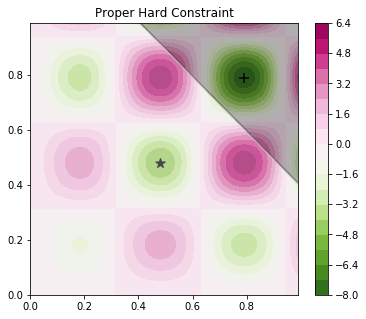

In [8]:
# True hard constraint for feasible optimum
xi = np.arange(0,1,0.01)
X, Y = np.meshgrid(xi,xi)
Z = z(X,Y)
plt.figure(figsize=(6,5))
f = plt.contourf(X,Y,Z,20,cmap='PiYG_r')
plt.scatter(xmin,ymin,marker='+',color='k',s=100)
plt.scatter(xfeas, yfeas, marker='*', color='k', s=100)
# plt.scatter(LHS[:,0],LHS[:,1],c='k',alpha=0.3)
plt.colorbar(f)
cnstr = X+Y-1.4# constraint
cnstr[cnstr > 0] = 0
cnstr[cnstr < 0] = 1
plt.contourf(X,Y,cnstr,cmap='gray',alpha=0.3)
plt.title('Proper Hard Constraint')
print(f'global min @ x1 = {xmin}, x2 = {ymin}, z = {Z[zmin[0][0], zmin[1][0]]}')

Starting BO . . .
Completed model ensemble 1/50.
> LinAlg exception.
Completed model ensemble 2/50.
Completed model ensemble 3/50.
Completed model ensemble 4/50.
> LinAlg exception.
> LinAlg exception.
Completed model ensemble 5/50.
Completed model ensemble 6/50.
Completed model ensemble 7/50.
> LinAlg exception.
Completed model ensemble 8/50.
Completed model ensemble 9/50.
> LinAlg exception.
> LinAlg exception.
Completed model ensemble 10/50.
Completed model ensemble 11/50.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.

> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.


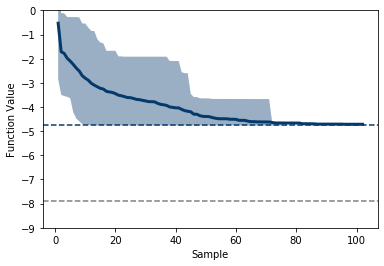

Running Minimum Regret


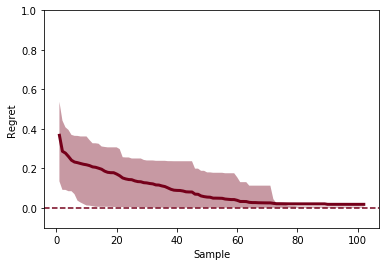

Instantaneous Regret


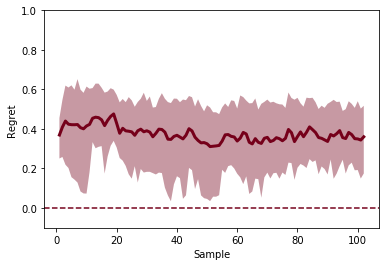

(array([[-0.53113928, -2.84738194,  1.60211853],
        [-1.71135187, -3.49373297, -0.11498933],
        [-1.78171393, -3.54830528, -0.12370191],
        [-1.98045505, -3.57764347, -0.2741403 ],
        [-2.10131594, -3.63715278, -0.27845424],
        [-2.23663742, -4.21625792, -0.27845424],
        [-2.38829871, -4.47575608, -0.27845424],
        [-2.51383416, -4.59175388, -0.29048955],
        [-2.70362074, -4.70979471, -0.54282331],
        [-2.81007877, -4.7342923 , -0.54282331],
        [-2.89031902, -4.74489168, -0.71722513],
        [-3.01893943, -4.75139045, -0.85092785],
        [-3.09541748, -4.75952593, -0.85841503],
        [-3.16331567, -4.75952593, -1.19317676],
        [-3.22791113, -4.75952593, -1.32921737],
        [-3.25676608, -4.75952593, -1.36495695],
        [-3.35208367, -4.75952593, -1.67351263],
        [-3.37750143, -4.75952593, -1.67351263],
        [-3.39736899, -4.75994252, -1.67351263],
        [-3.44725391, -4.75994252, -1.67351263],
        [-3.51111818

In [9]:
BO_procedure(exps = exps, ensemble = ensemble, init = init, constraint = 'x[:,0] + x[:,1] - 1.4', probability_function = None, plot = False)

### False hard constraint with feasible optimum outside of bounds
Constraint = -X - Y + 1.4

global min @ x1 = 0.79, x2 = 0.79, z = -7.883282055049491


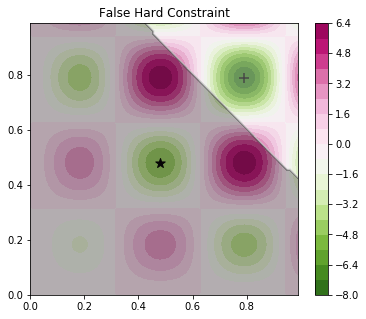

In [10]:
# False hard constraint for feasible optimum
xi = np.arange(0,1,0.01)
X, Y = np.meshgrid(xi,xi)
Z = z(X,Y)
plt.figure(figsize=(6,5))
f = plt.contourf(X,Y,Z,20,cmap='PiYG_r')
plt.scatter(xmin,ymin,marker='+',color='k',s=100)
plt.scatter(xfeas, yfeas, marker='*', color='k', s=100)
# plt.scatter(LHS[:,0],LHS[:,1],c='k',alpha=0.3)
plt.colorbar(f)
cnstr = -X-Y+1.41# constraint
cnstr[cnstr > 0] = 0
cnstr[cnstr < 0] = 1
plt.contourf(X,Y,cnstr,cmap='gray',alpha=0.3)
plt.title('False Hard Constraint')
print(f'global min @ x1 = {xmin}, x2 = {ymin}, z = {Z[zmin[0][0], zmin[1][0]]}')

Starting BO . . .
Completed model ensemble 1/50.
> LinAlg exception.
Completed model ensemble 2/50.
Completed model ensemble 3/50.
Completed model ensemble 4/50.
Completed model ensemble 5/50.
Completed model ensemble 6/50.
Completed model ensemble 7/50.
Completed model ensemble 8/50.
Completed model ensemble 9/50.
Completed model ensemble 10/50.
Completed model ensemble 11/50.
Completed model ensemble 12/50.
Completed model ensemble 13/50.
Completed model ensemble 14/50.
Completed model ensemble 15/50.
Completed model ensemble 16/50.
Completed model ensemble 17/50.
Completed model ensemble 18/50.
Completed model ensemble 19/50.
Completed model ensemble 20/50.
Completed model ensemble 21/50.
Completed model ensemble 22/50.
Completed model ensemble 23/50.
Completed model ensemble 24/50.
Completed model ensemble 25/50.
Completed model ensemble 26/50.
Completed model ensemble 27/50.
Completed model ensemble 28/50.
Completed model ensemble 29/50.
Completed model ensemble 30/50.
Completed m

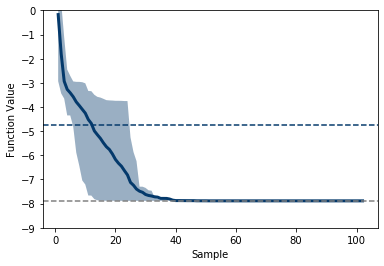

Running Minimum Regret


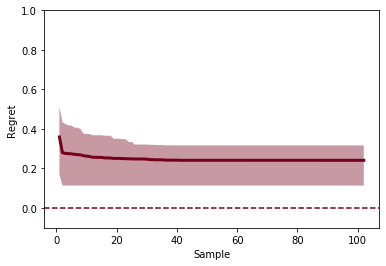

Instantaneous Regret


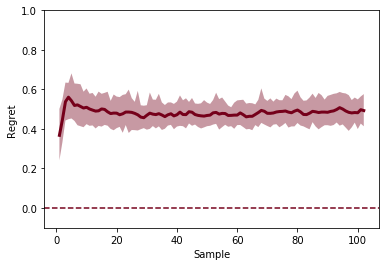

(array([[-0.1746794 , -2.93155137,  2.11421907],
        [-1.7983344 , -3.43894932,  0.32749414],
        [-2.93455897, -3.65349414, -1.12270184],
        [-3.27139378, -4.34873665, -2.44981779],
        [-3.41286835, -4.34873665, -2.70982351],
        [-3.57783325, -4.81403578, -2.94163948],
        [-3.7900117 , -5.88690326, -2.95900452],
        [-3.93919274, -6.4283939 , -2.95958969],
        [-4.09727211, -7.04206182, -2.9733941 ],
        [-4.25383975, -7.20781216, -3.01944891],
        [-4.51865761, -7.66300064, -3.33663725],
        [-4.68012999, -7.66557001, -3.34412788],
        [-4.9878823 , -7.81272941, -3.49400469],
        [-5.1470033 , -7.85947965, -3.57927926],
        [-5.29607889, -7.87588439, -3.60912114],
        [-5.48212895, -7.87766537, -3.66044997],
        [-5.64547231, -7.87995245, -3.71571873],
        [-5.75941024, -7.88193822, -3.72739563],
        [-5.94372877, -7.88193822, -3.73294782],
        [-6.16942742, -7.88358713, -3.74334264],
        [-6.3252387 

In [11]:
BO_procedure(exps = exps, ensemble = ensemble, init = init, constraint = '-x[:,0] - x[:,1] + 1.4', probability_function = None, plot = False)

### Probabilistic Constraint with Linear Activation Function

global min @ x1 = 0.79, x2 = 0.79, z = -7.883282055049491


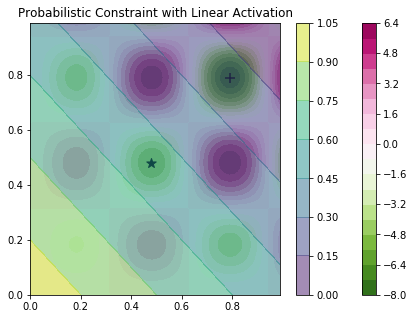

In [12]:
# Probabilistic linear scaled constraint
xi = np.arange(0,1,0.01)
X, Y = np.meshgrid(xi,xi)
Z = z(X,Y)
plt.figure(figsize=(7,5))
f = plt.contourf(X,Y,Z,20,cmap='PiYG_r')
plt.scatter(xmin,ymin,marker='+',color='k',s=100)
plt.scatter(xfeas, yfeas, marker='*', color='k', s=100)
# plt.scatter(LHS[:,0],LHS[:,1],c='k',alpha=0.3)
plt.colorbar(f)

cnstr_linear = activation(constraint = -X-Y, scale = 0.5, bias = 1)
# cnstr_linear[cnstr_linear < 0.3] = 0
cn = plt.contourf(X,Y,cnstr_linear ,cmap='viridis',alpha=0.5)
plt.colorbar(cn)
plt.title('Probabilistic Constraint with Linear Activation')
print(f'global min @ x1 = {xmin}, x2 = {ymin}, z = {Z[zmin[0][0], zmin[1][0]]}')

Starting BO . . .
Completed model ensemble 1/50.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg ex

> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
Completed model ensemble 29/50.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg

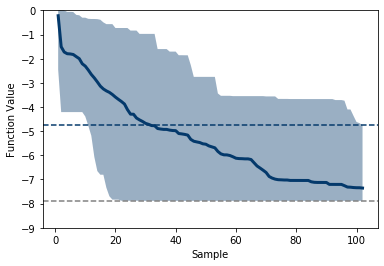

Running Minimum Regret


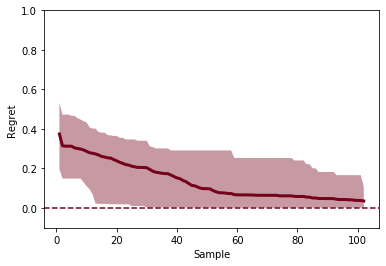

Instantaneous Regret


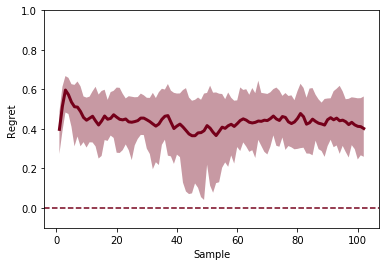

(array([[-0.22229863, -2.44661607,  1.50977277],
        [-1.50651562, -4.21079656,  0.74320085],
        [-1.72453761, -4.21079656, -0.        ],
        [-1.79456707, -4.21079656, -0.06268303],
        [-1.80386474, -4.21079656, -0.06268303],
        [-1.82658484, -4.21079656, -0.06973219],
        [-1.91448373, -4.21079656, -0.18626305],
        [-1.99900962, -4.21079656, -0.20376406],
        [-2.21114651, -4.21079656, -0.30327048],
        [-2.30842178, -4.3931586 , -0.30327048],
        [-2.47024385, -4.7755453 , -0.34980527],
        [-2.65228978, -5.19053763, -0.35725381],
        [-2.79754125, -6.07073597, -0.35725381],
        [-2.96291102, -6.65259359, -0.3628816 ],
        [-3.13712888, -6.8032315 , -0.38820977],
        [-3.25310283, -6.8032315 , -0.4974383 ],
        [-3.33287237, -7.34274433, -0.56972373],
        [-3.39475213, -7.69454983, -0.56972373],
        [-3.48325096, -7.83414555, -0.56972373],
        [-3.5900105 , -7.83414555, -0.73024219],
        [-3.68422386

In [13]:
BO_procedure(exps = exps, ensemble = ensemble, init = init, constraint = None, probability_function = cnstr_linear, plot = False)

### Probabilistic Constraint with Parabolic Activation Function

global min @ x1 = 0.79, x2 = 0.79, z = -7.883282055049491


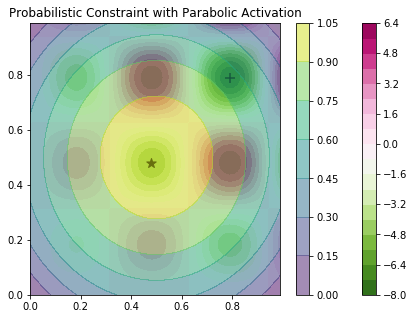

In [14]:
# Probabilistic parabolic scaled constraint
xi = np.arange(0,1,0.01)
X, Y = np.meshgrid(xi,xi)
Z = z(X,Y)
plt.figure(figsize=(7,5))
f = plt.contourf(X,Y,Z,20,cmap='PiYG_r')
plt.scatter(xmin,ymin,marker='+',color='k',s=100)
plt.scatter(xfeas, yfeas, marker='*', color='k', s=100)
# plt.scatter(LHS[:,0],LHS[:,1],c='k',alpha=0.3)
plt.colorbar(f)

cnstr_parabolic = activation(constraint = -(X-0.5)**2-(Y-0.5)**2, scale = 2, bias = 1)
# cnstr_linear[cnstr_linear < 0.3] = 0
cn = plt.contourf(X,Y,cnstr_parabolic ,cmap='viridis',alpha=0.5)
plt.colorbar(cn)
plt.title('Probabilistic Constraint with Parabolic Activation')
print(f'global min @ x1 = {xmin}, x2 = {ymin}, z = {Z[zmin[0][0], zmin[1][0]]}')

Starting BO . . .
Completed model ensemble 1/50.
Completed model ensemble 2/50.
Completed model ensemble 3/50.
Completed model ensemble 4/50.
Completed model ensemble 5/50.
Completed model ensemble 6/50.
Completed model ensemble 7/50.
Completed model ensemble 8/50.
Completed model ensemble 9/50.
> LinAlg exception.
Completed model ensemble 10/50.
Completed model ensemble 11/50.
Completed model ensemble 12/50.
Completed model ensemble 13/50.
Completed model ensemble 14/50.
Completed model ensemble 15/50.
Completed model ensemble 16/50.
Completed model ensemble 17/50.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAl

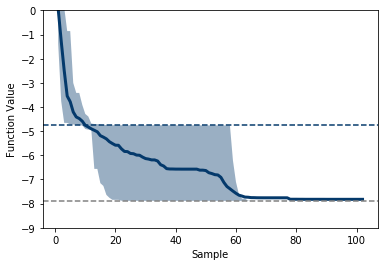

Running Minimum Regret


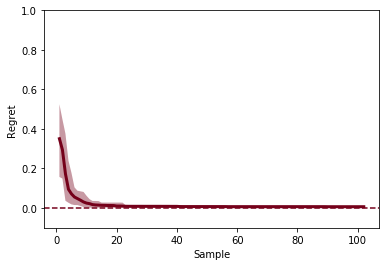

Instantaneous Regret


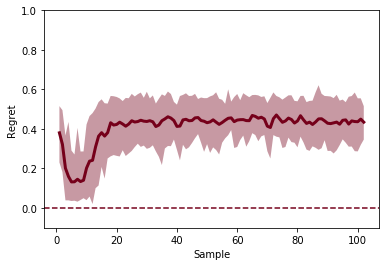

(array([[ 0.06954299, -1.37290561,  2.41452381],
        [-1.26218075, -3.75788978,  0.37090522],
        [-2.48791991, -4.65866367,  0.12757702],
        [-3.54636548, -4.65866367, -0.85745684],
        [-3.78155297, -4.7212399 , -0.85745684],
        [-4.20615365, -4.7212399 , -3.00235989],
        [-4.4126342 , -4.73625558, -3.41710495],
        [-4.4776491 , -4.75911639, -3.41710495],
        [-4.58774418, -4.76434323, -3.9109308 ],
        [-4.76046374, -4.91046669, -4.28782927],
        [-4.82776408, -4.93771599, -4.39292619],
        [-4.90496608, -4.93776208, -4.68387798],
        [-4.96407471, -6.56225228, -4.70628177],
        [-5.0282182 , -6.56225228, -4.70628177],
        [-5.18634186, -7.15182506, -4.72721324],
        [-5.24715494, -7.26723636, -4.73900759],
        [-5.31932969, -7.63802059, -4.7467118 ],
        [-5.43580999, -7.75839076, -4.75390675],
        [-5.51208545, -7.84168534, -4.75500688],
        [-5.58068445, -7.84168534, -4.75500688],
        [-5.5845789 

In [15]:
BO_procedure(exps = exps, ensemble = ensemble, init = init, constraint = None, probability_function = cnstr_parabolic, plot = False)

# ONLY RUN CODE ABOVE
Code below is outdated/experimental

Starting BO . . .


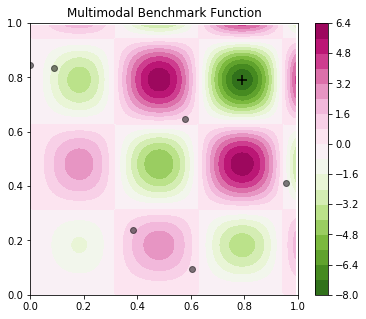

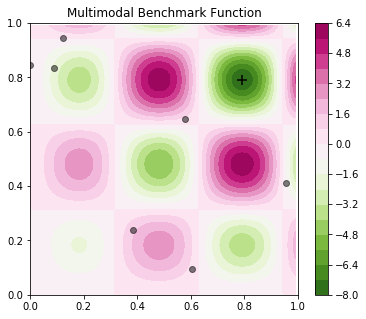

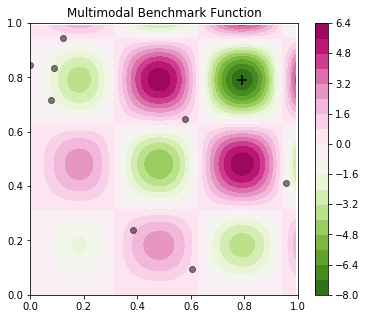

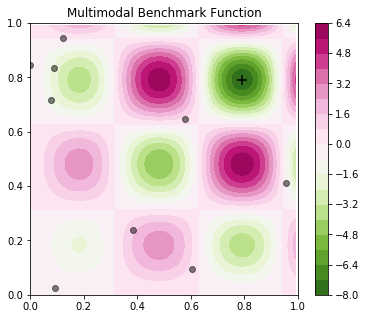

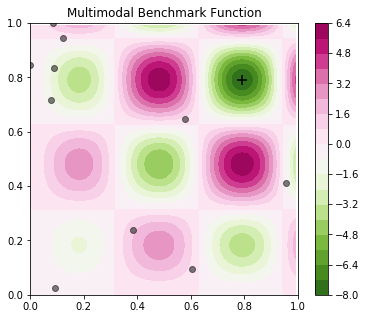

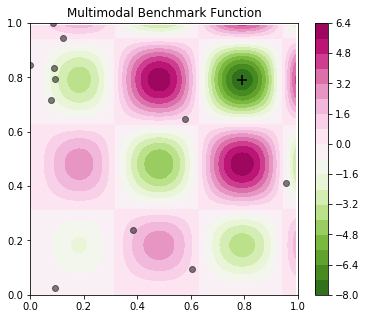

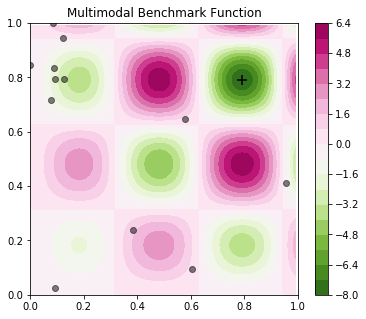

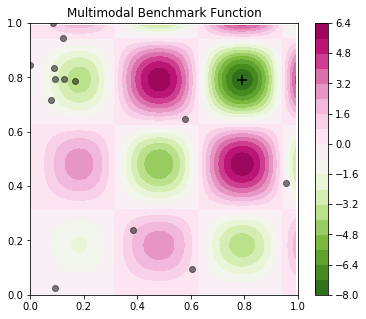

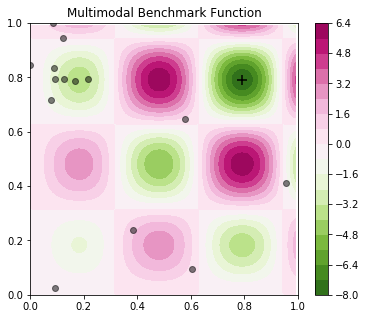

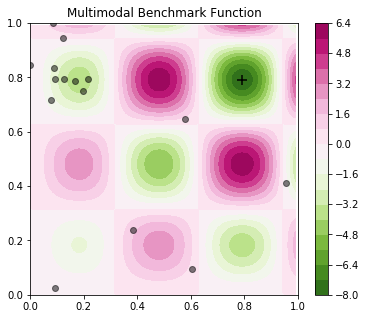

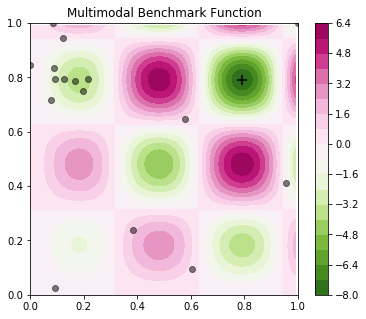

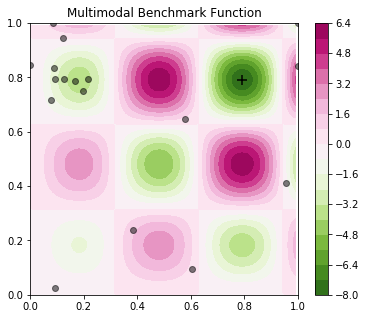

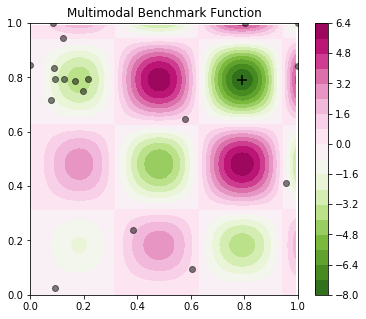

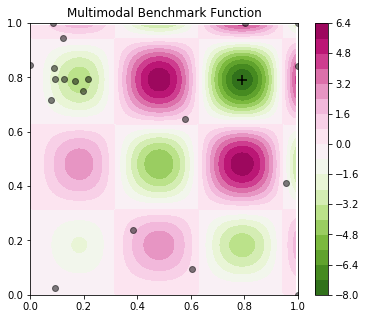

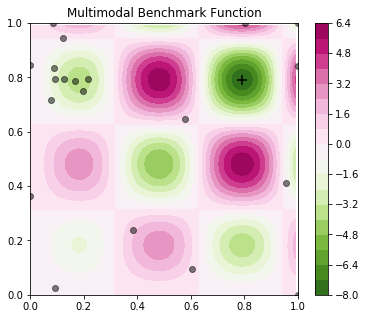

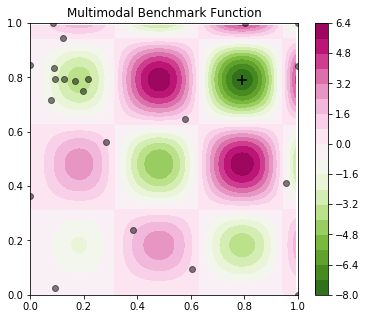

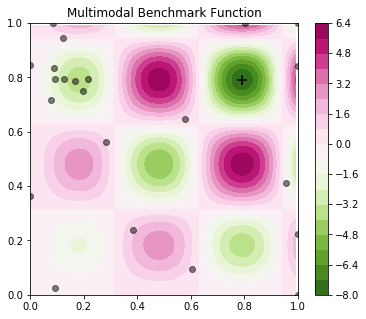

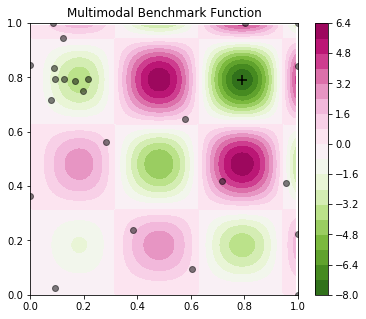

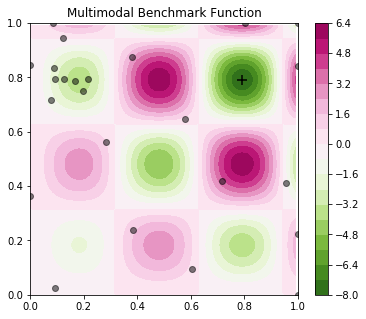

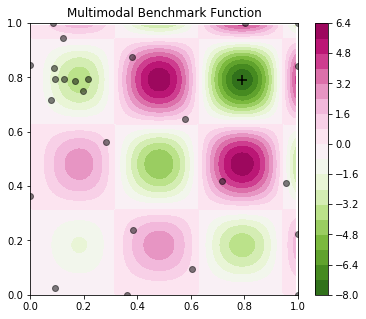

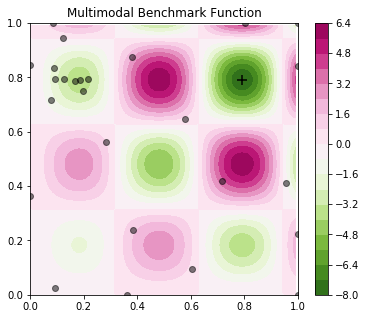

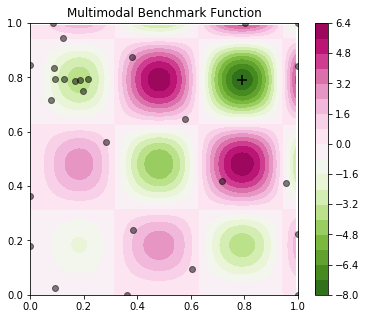

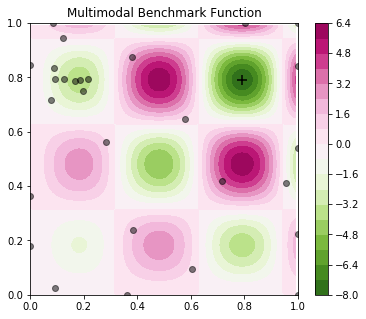

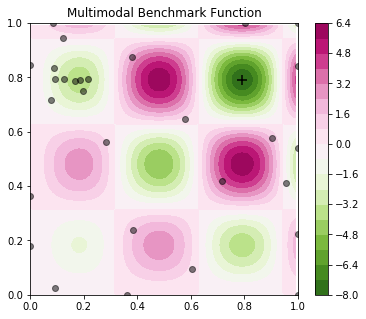

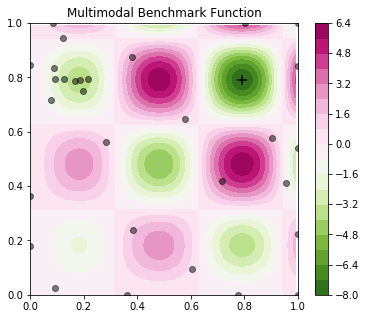

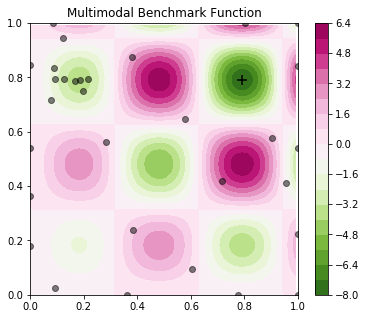

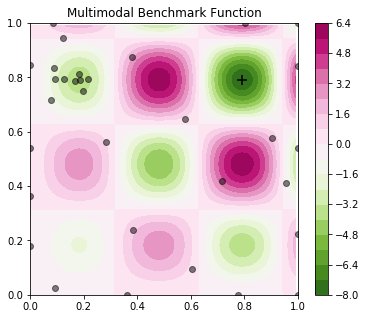

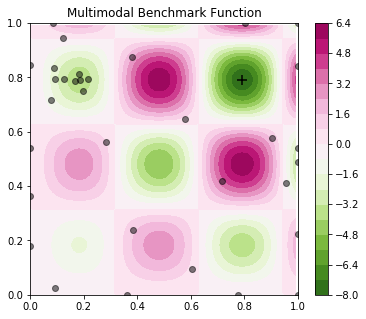

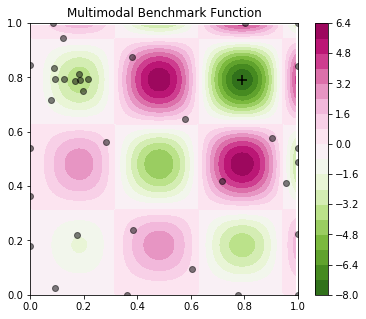

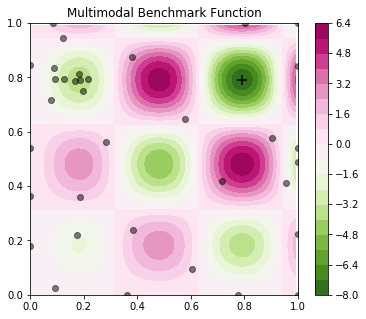

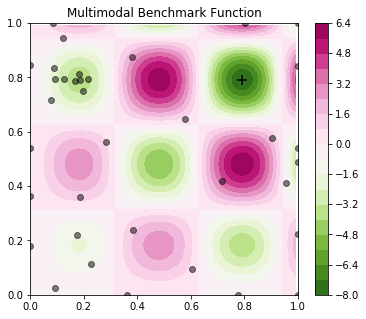

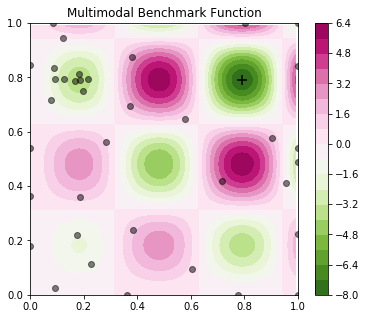

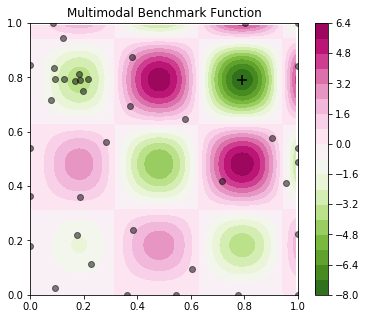

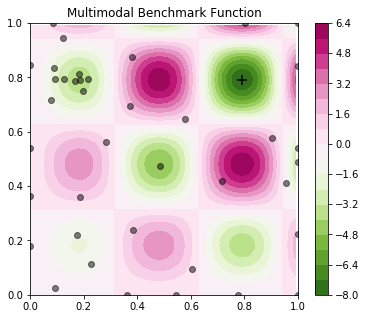

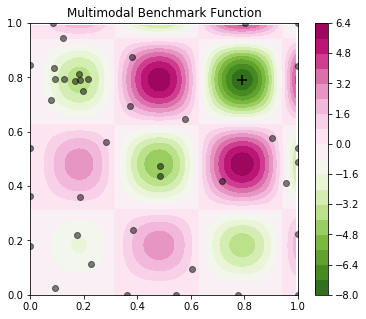

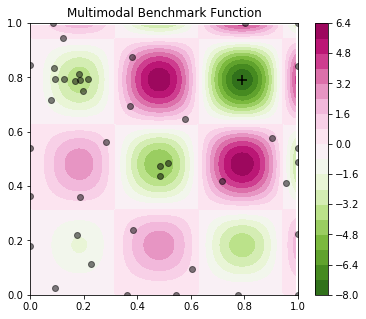

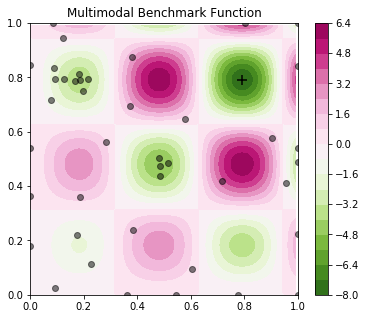

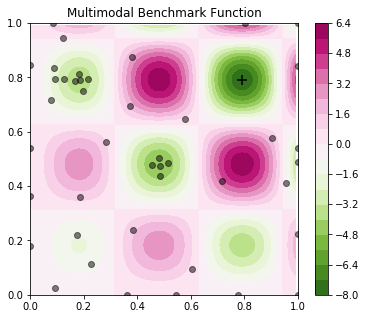

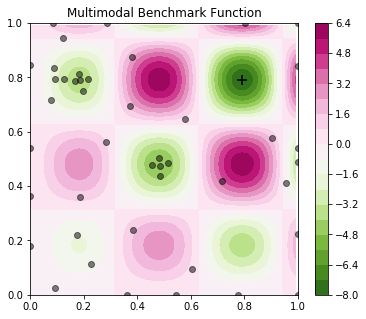

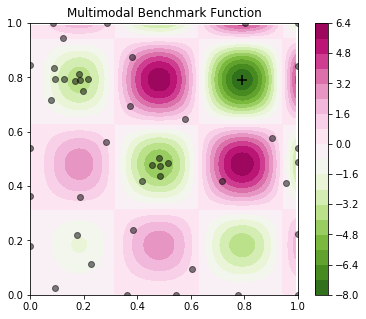

Completed validation round 1/4.


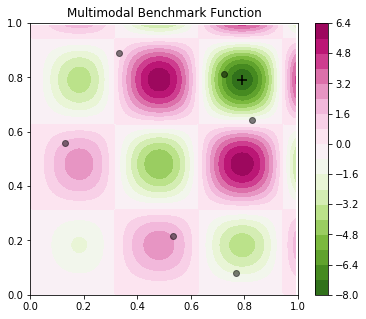

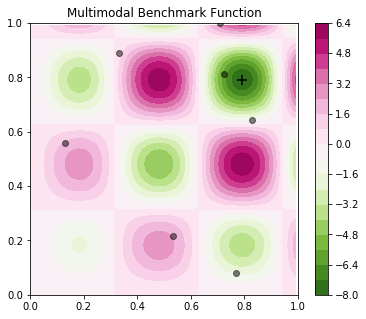

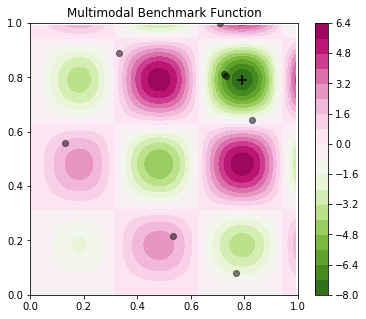

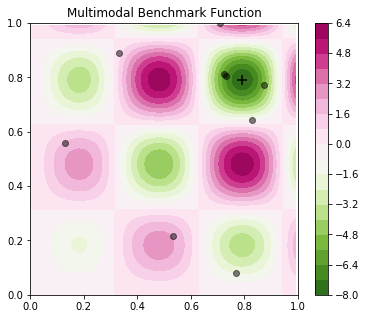

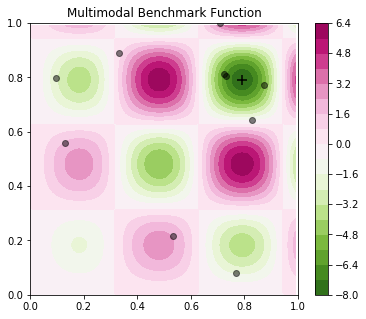

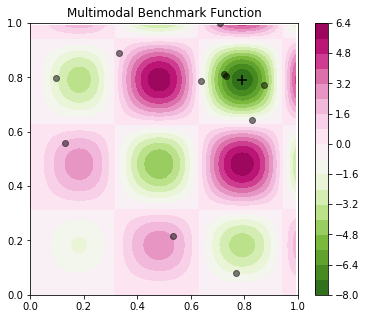

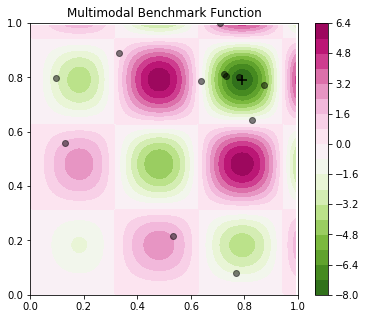

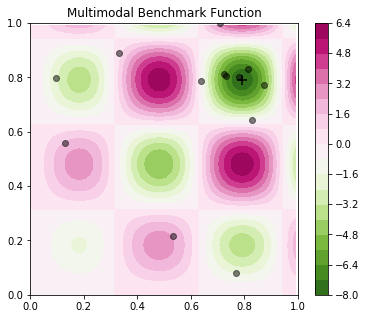

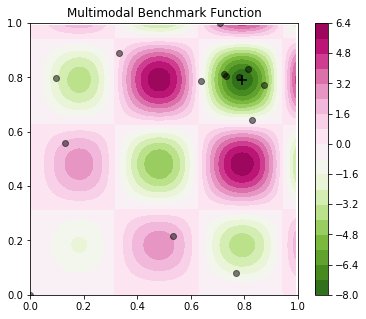

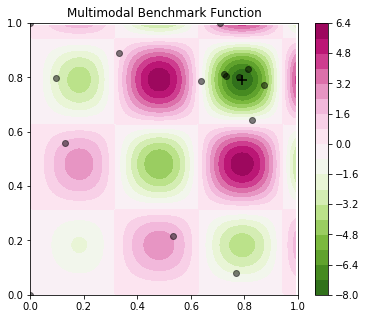

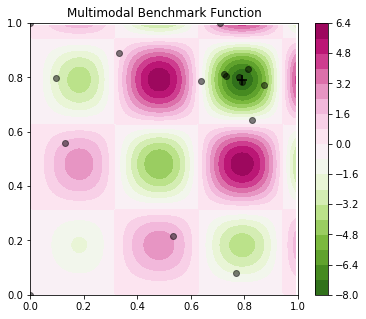

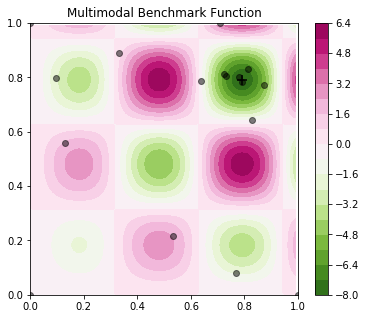

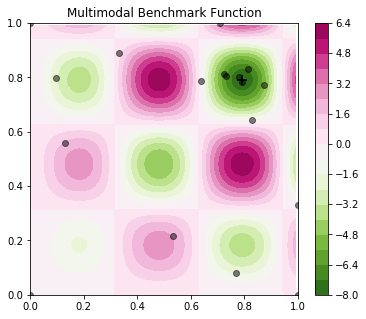

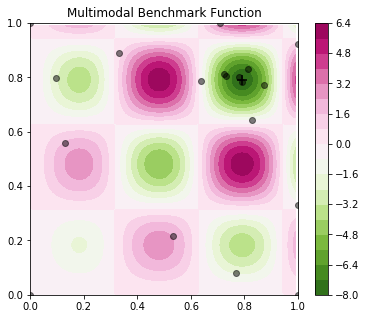

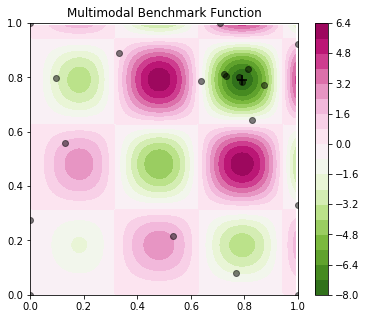

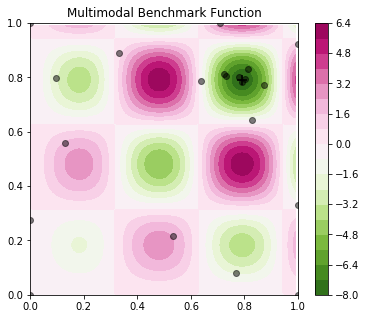

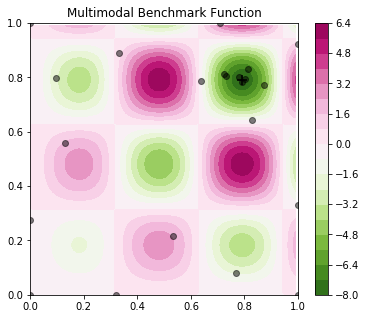

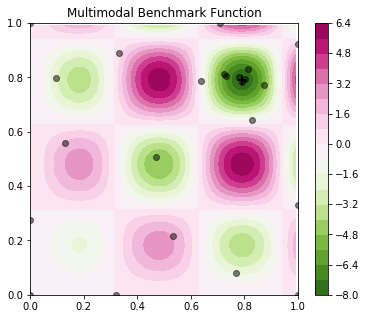

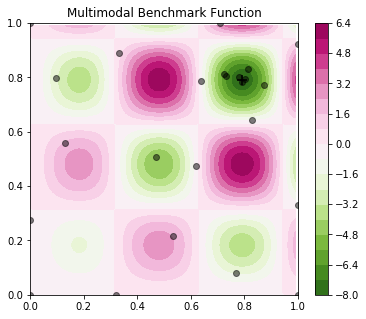

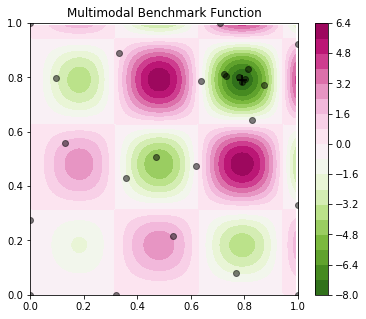

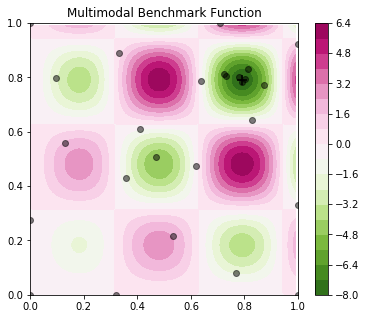

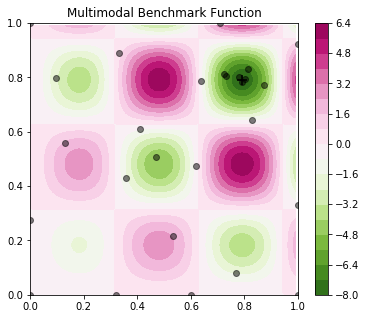

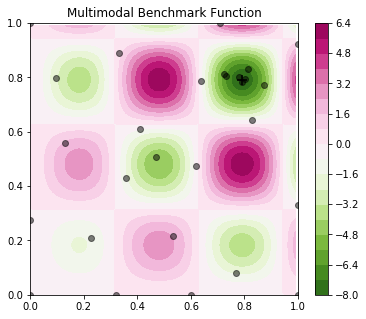

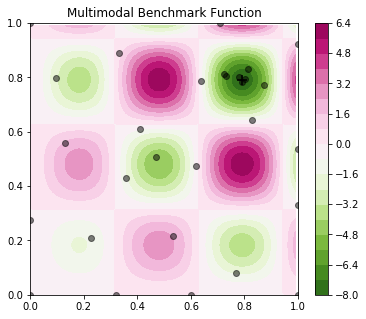

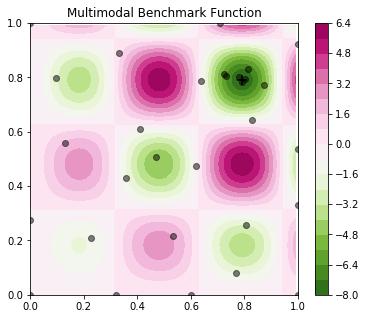

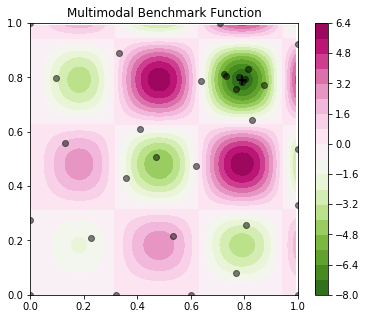

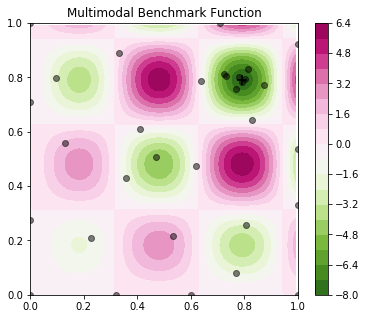

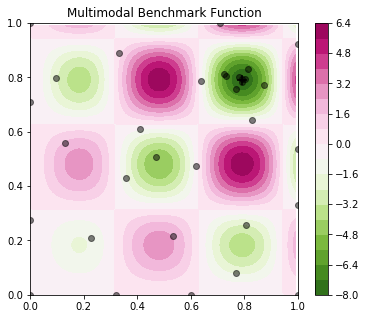

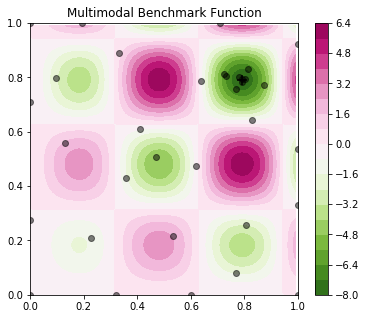

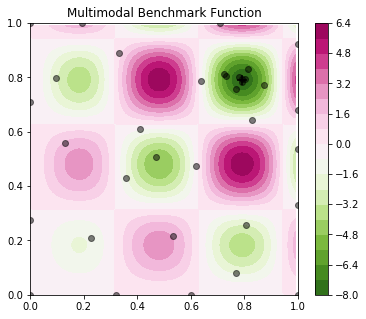

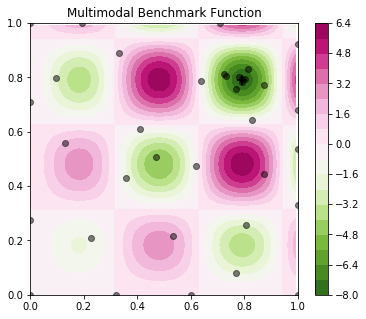

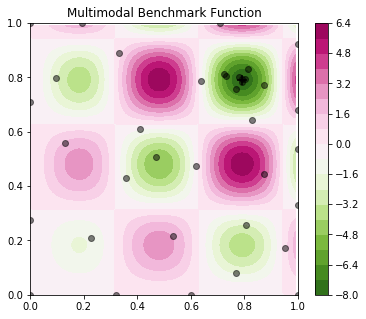

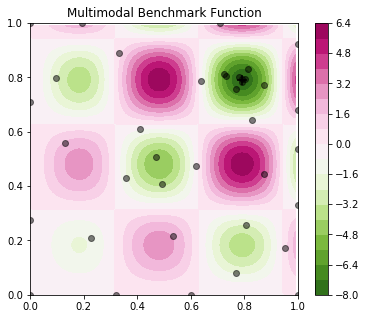

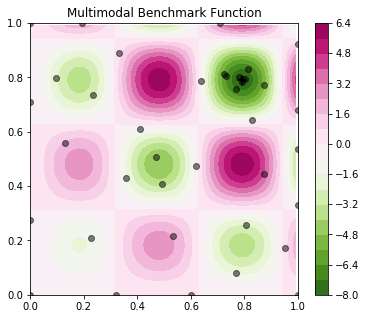

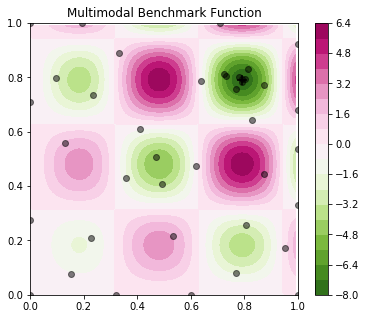

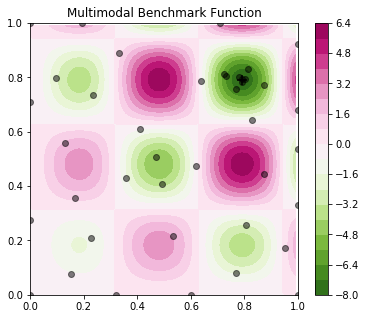

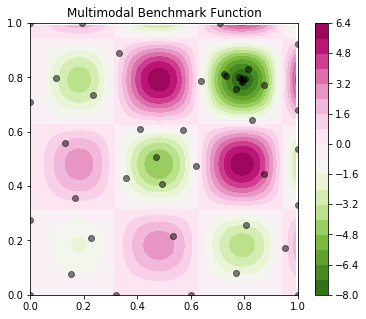

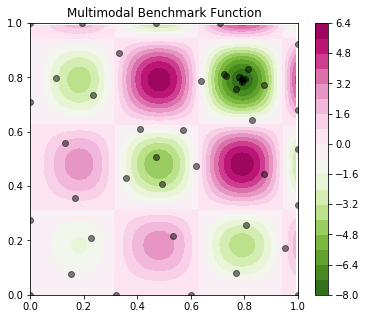

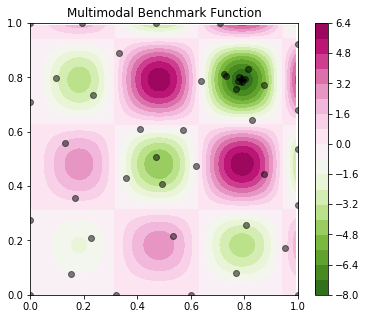

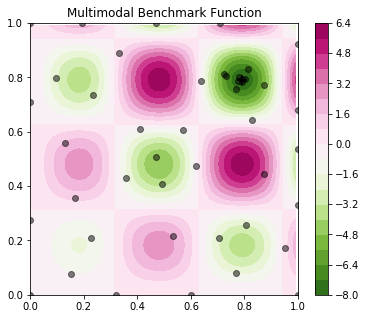

Completed validation round 2/4.


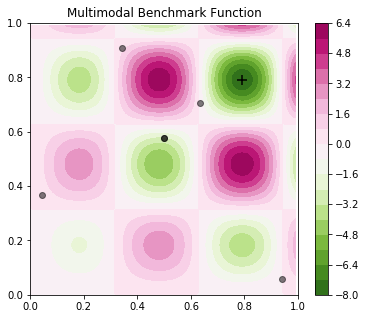

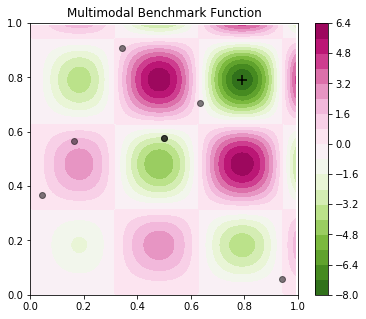

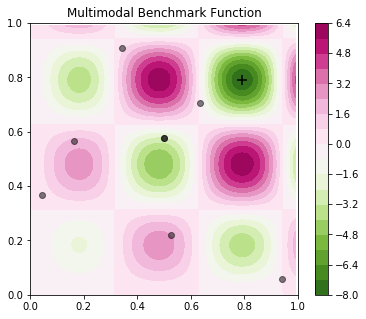

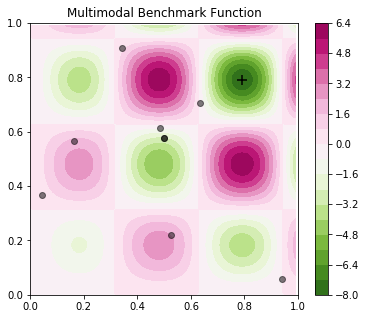

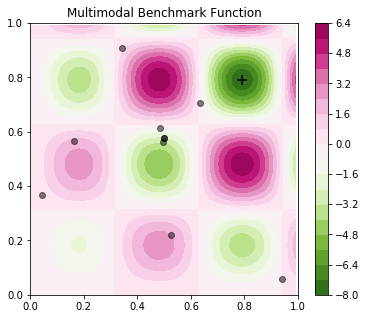

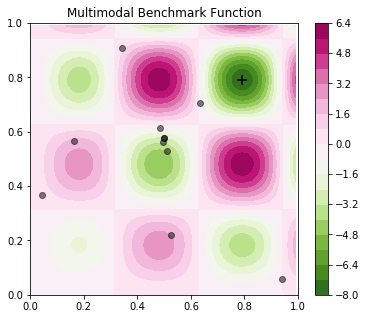

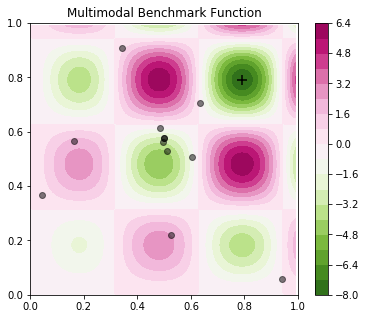

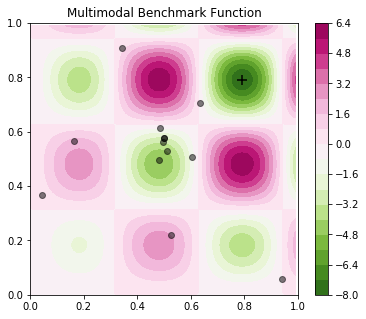

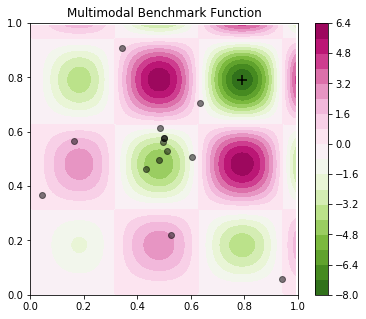

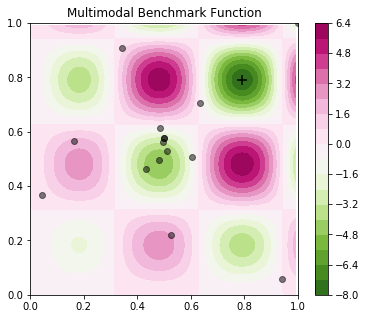

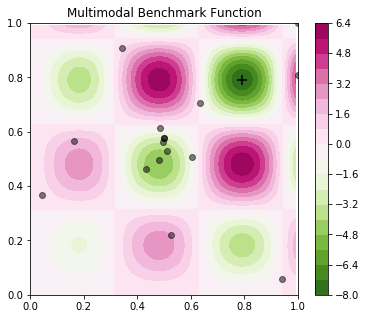

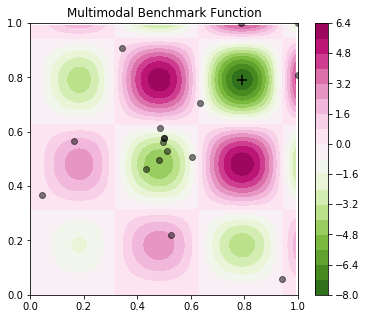

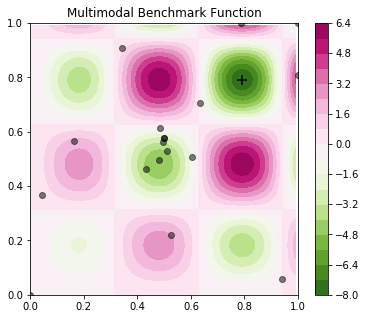

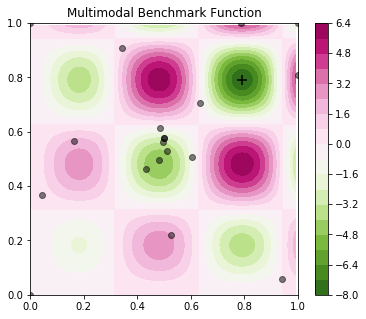

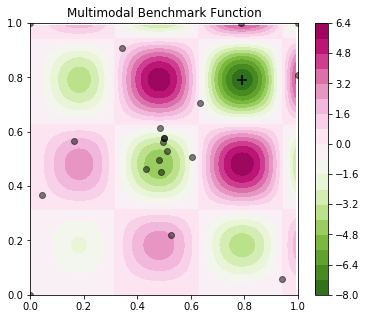

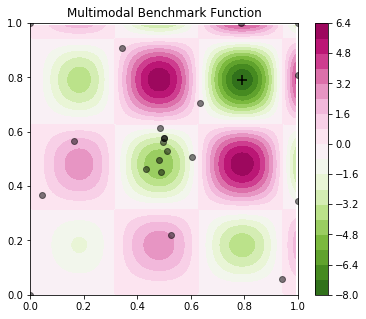

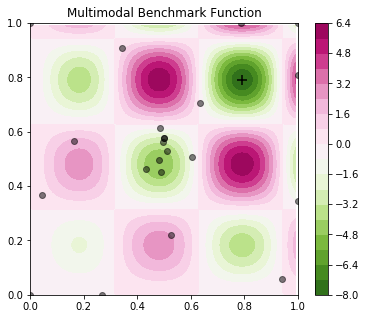

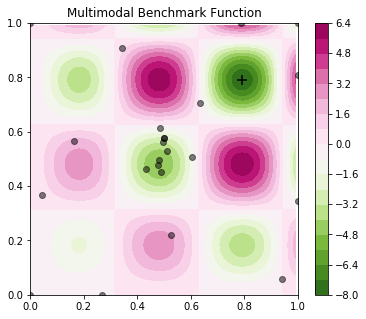

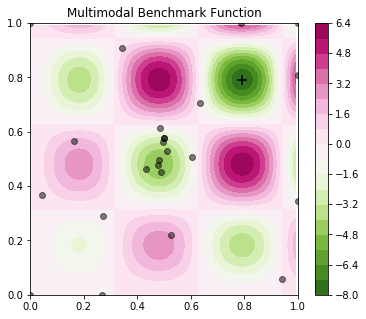

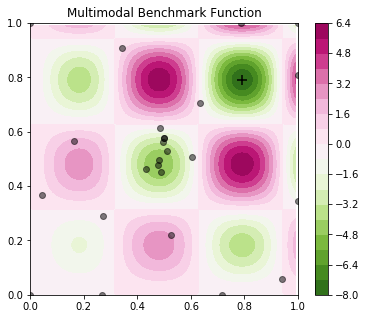

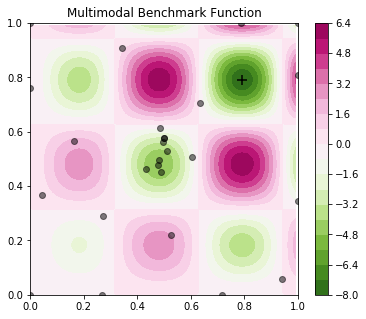

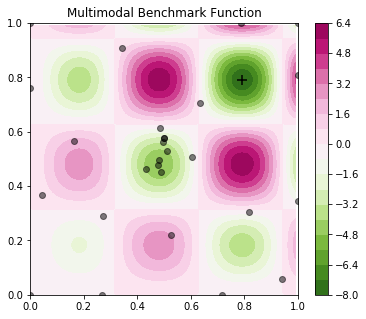

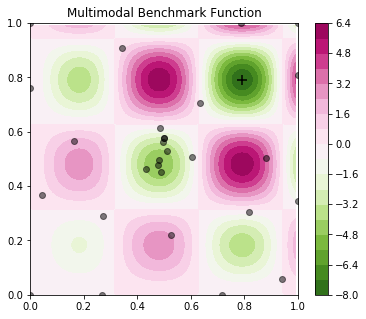

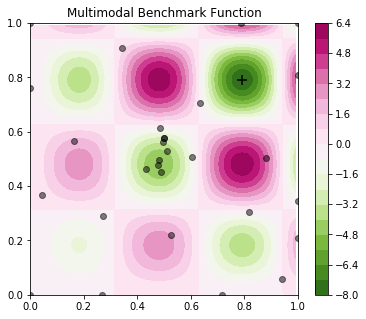

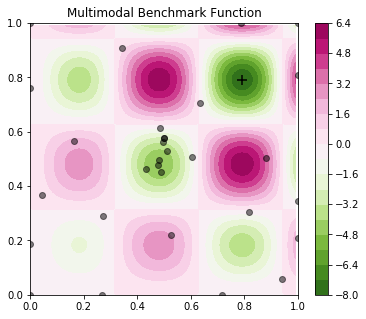

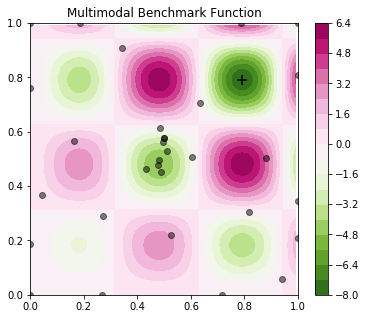

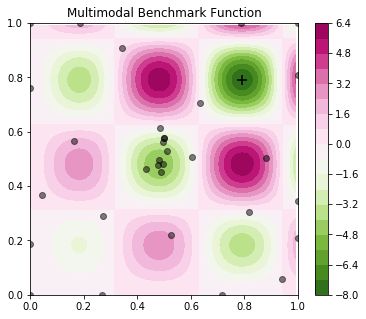

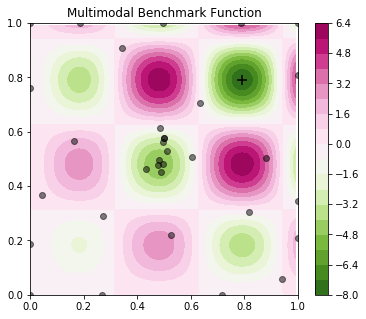

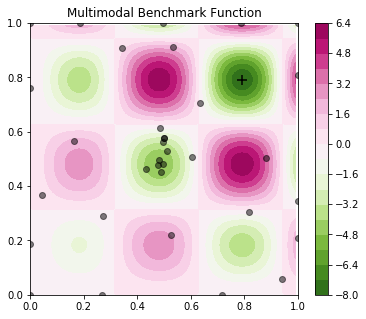

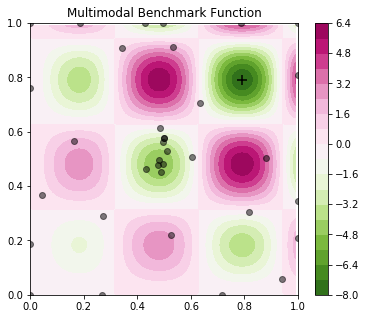

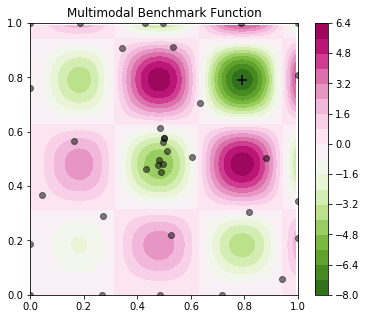

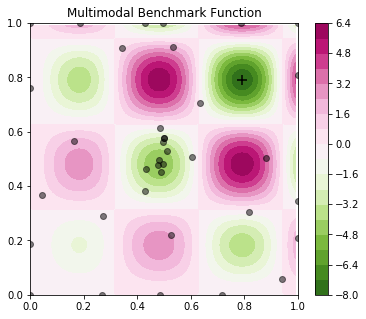

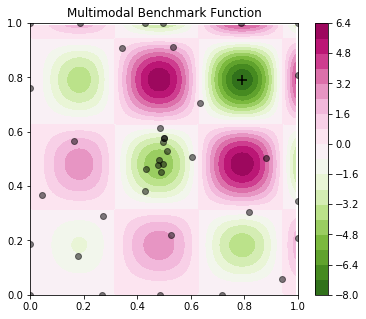

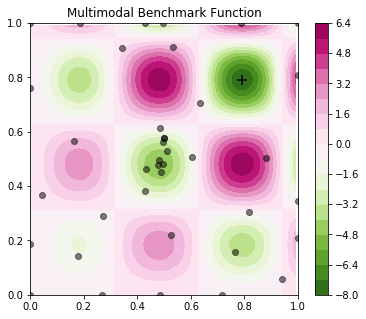

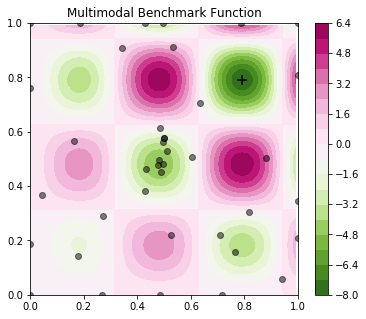

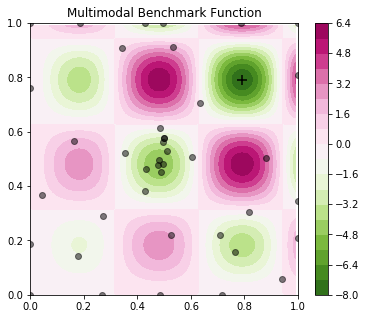

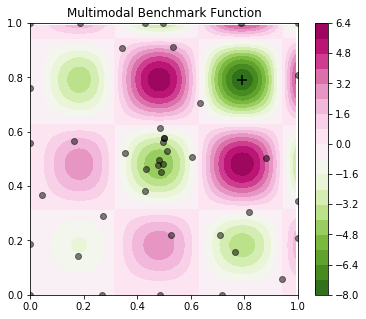

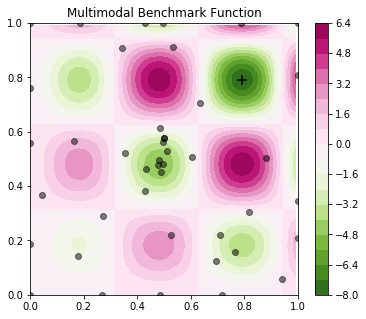

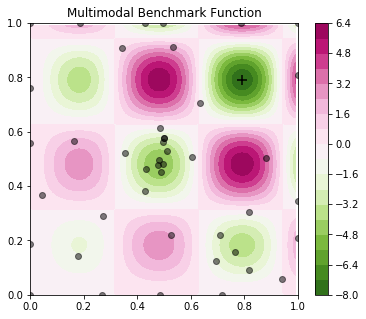

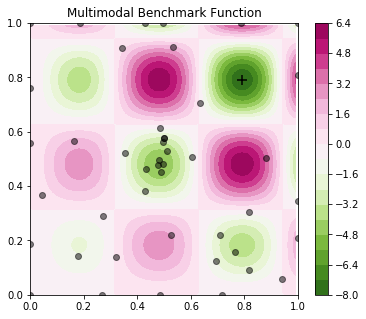

Completed validation round 3/4.


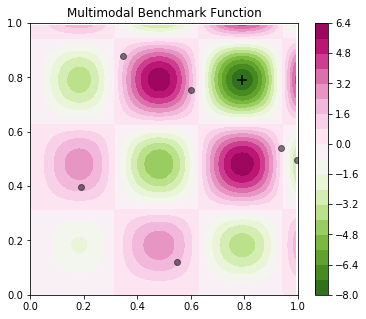

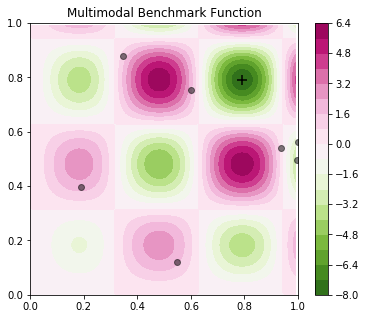

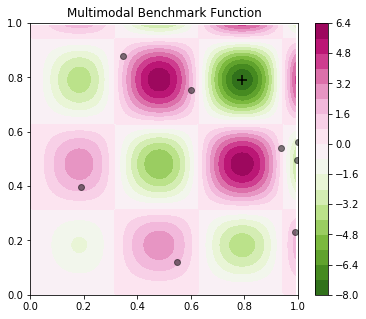

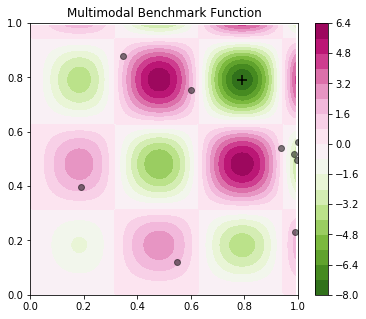

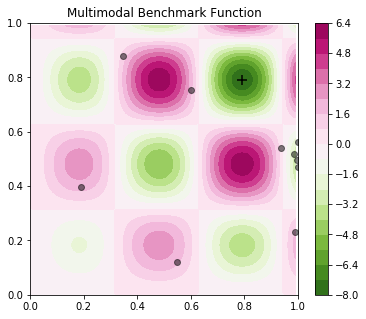

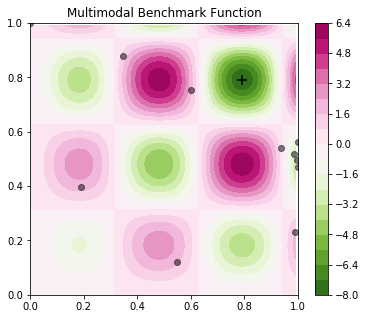

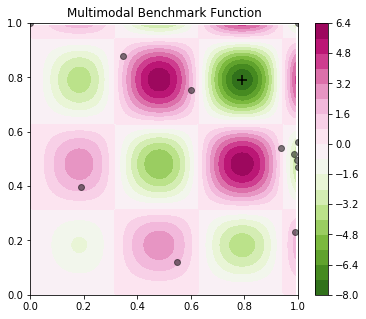

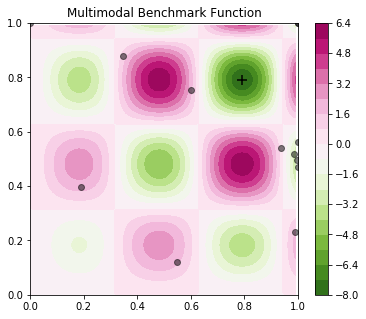

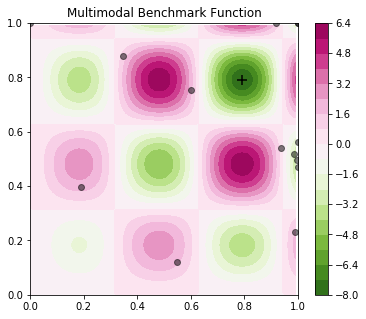

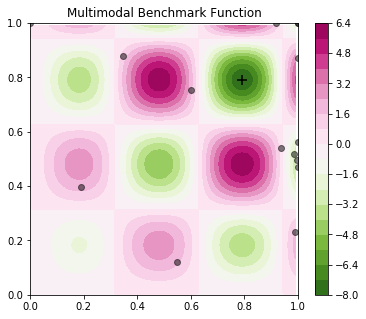

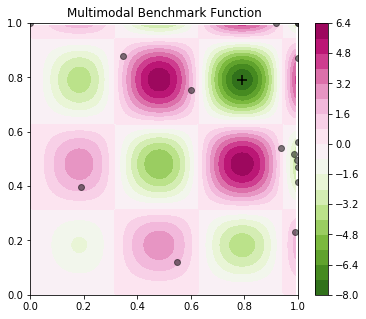

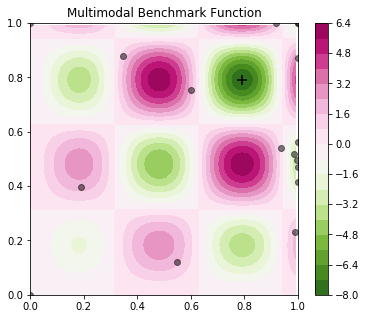

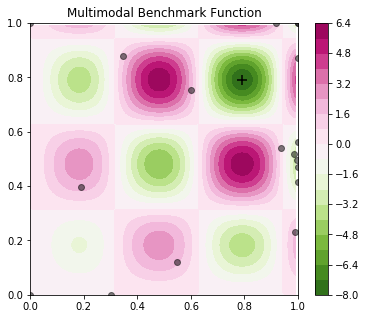

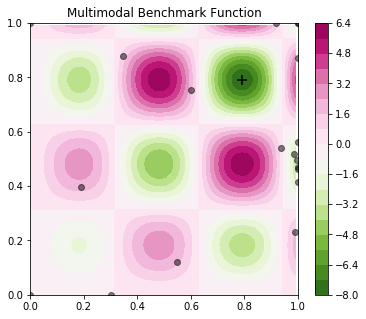

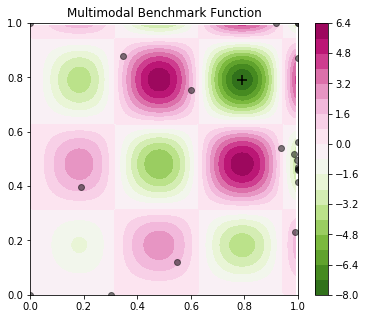

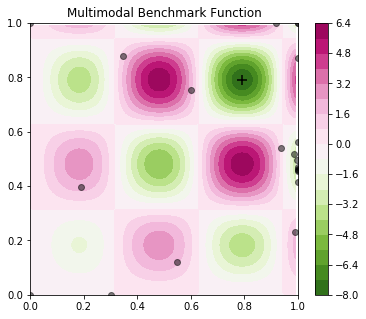

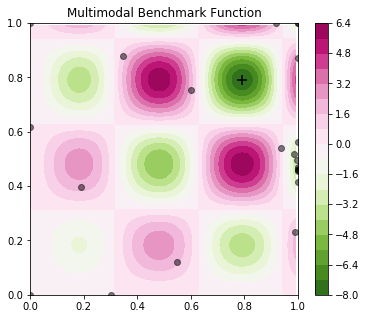

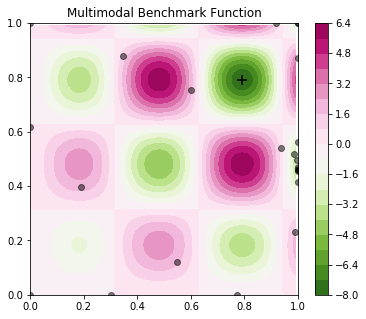

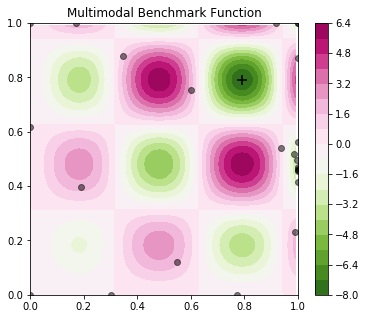

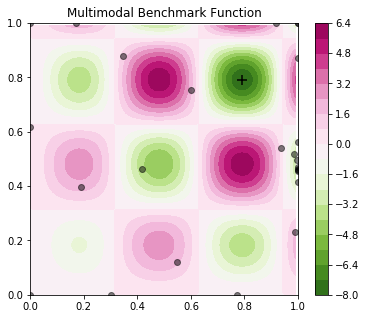

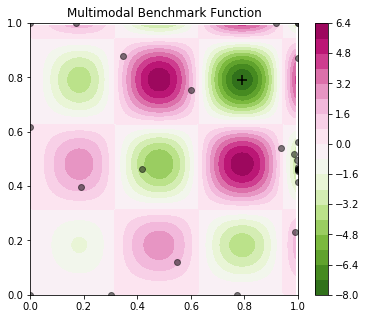

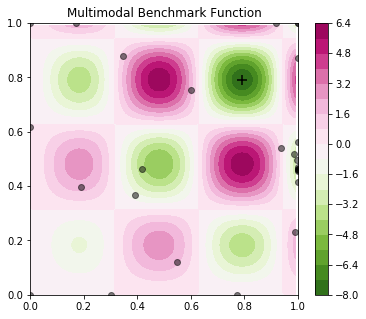

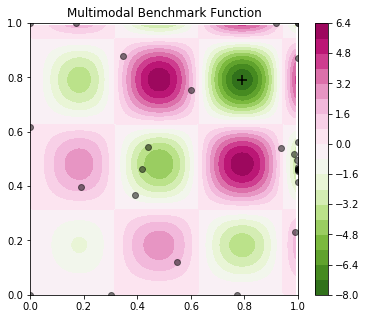

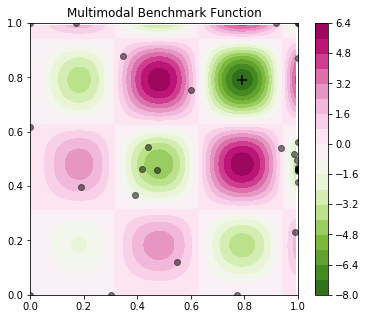

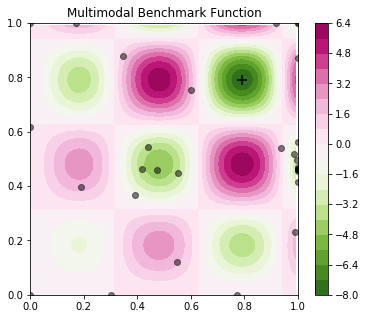

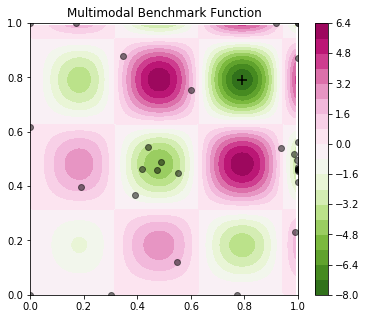

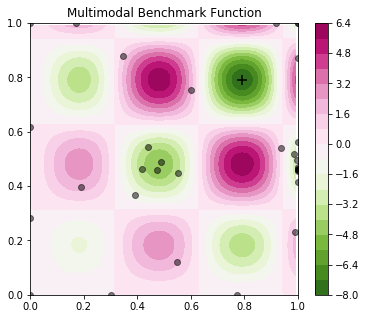

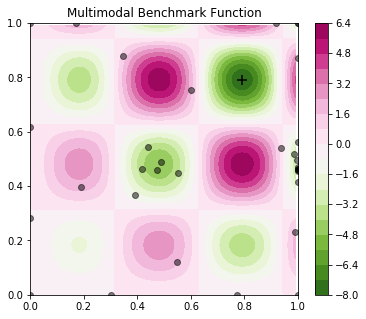

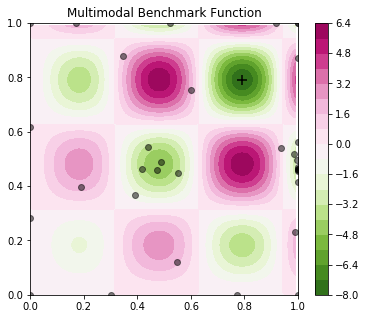

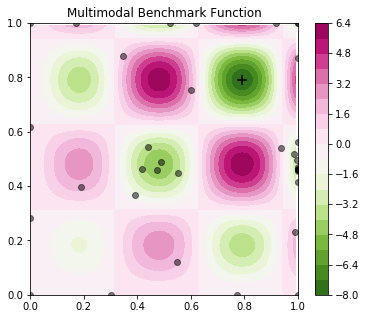

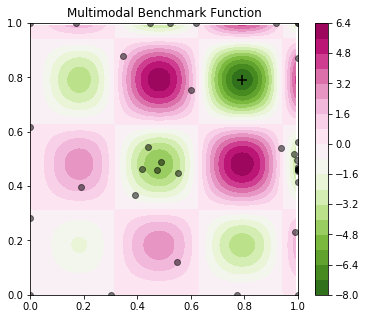

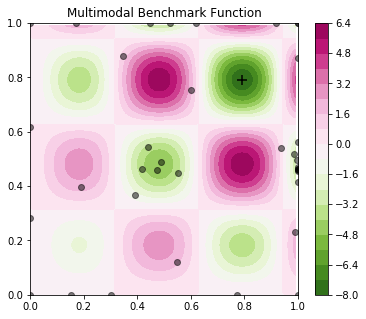

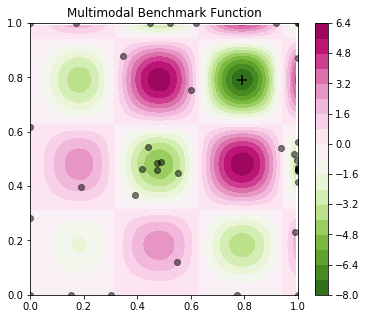

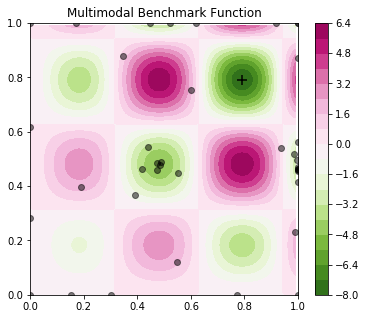

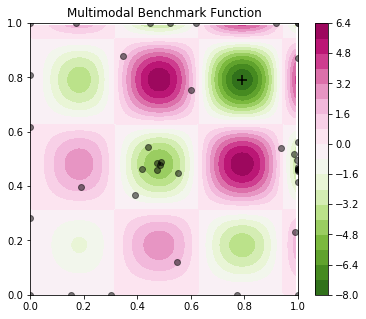

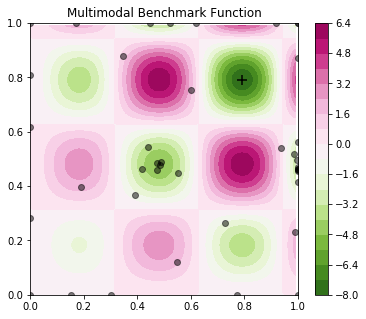

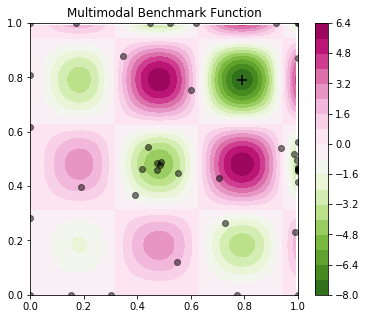

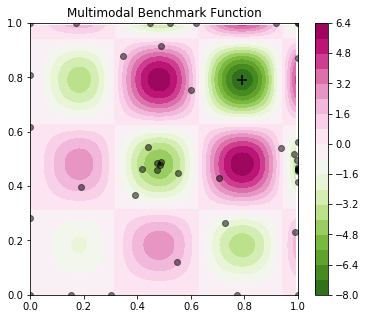

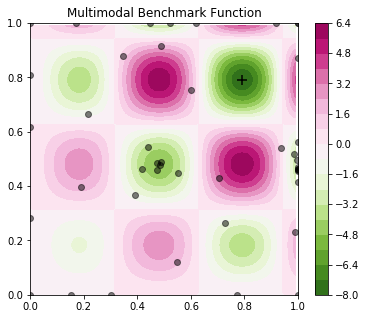

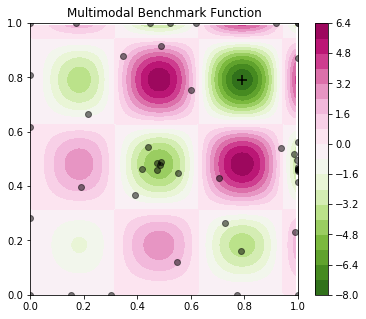

Completed validation round 4/4.


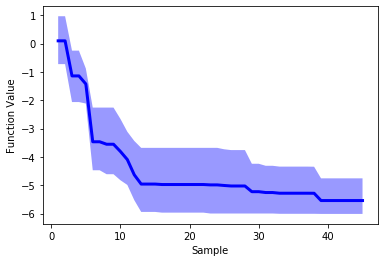

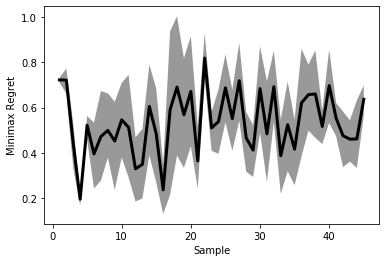

In [136]:
# No constraint
def run_BO_reg(x_conds,y_conds,constraint,constraint_function):
    '''
    Implement Bayesian optimization.
    
    Uses the expected improvement (EI) acquisition with local penalization and Matern5/2-ARD kernel.
    Generates a batch size of suggested conditions. 
    
    Inputs:
    x_conds             := input condition matrix (n by 3) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
      
    Ouputs:
    x_next              := suggested next x-conditions to sample from
    '''
    # run BO on the x-conditions conditions and their respective y-values
    bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)}, # 2D bounds
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
          ]
#     constraint = [
#     {
#         'name': 'constr_1',
#         'constraint': '-(10*np.exp(-x[:,0]/4)+10*np.exp(-x[:,1]/4) - 9)'
#     }]
    kernel = GPy.kern.Matern52(input_dim=len(bds), ARD = True) # Use the matern 5/2 kernel with automatic relevence detection enabled
    BO_opt = BayesianOptimization(f=None, 
                                     domain=bds,
#                                      constraints = constraint,
                                     model_type='GP', # gaussian process model
                                     acquisition_type ='EI',
                                     X=x_conds, # input data
                                     Y=y_conds, # associated labels
                                     evaluator_type = 'local_penalization',
                                     batch_size = 1, # batch size of predicted optima
                                     normalize_Y= True,
                                     kernel = kernel # select the kernel
                                     )
    x_next = BO_opt.suggest_next_locations()
    return x_next
print('Starting BO . . .')

min_arr = np.array(np.zeros((runs+lhs, test))) # array to plug in all minY vectors
dist_arr = np.array(np.zeros((runs+lhs, test))) # array to plug in all minD vectors
for t in range(test):
    LHS = latin_hypercube(D=2, N=lhs) # randomize LHS selected points every loop
    Xs = LHS
    Ys = z(LHS[:,0],LHS[:,1])
    Ys = Ys.reshape(len(Ys),1)

    # run bo
    for n in range(runs):
        try:
            updx = run_BO_reg(x_conds = Xs, y_conds = Ys)
            updy = z(updx[:,0],updx[:,1])
            Xs = np.concatenate((Xs,updx))
            Ys = np.concatenate((Ys,updy.reshape(1,1)))
        except:
            print('> LinAlg exception.')
            Xs = np.concatenate((Xs,updx)) # from the previous round
            Ys = np.concatenate((Ys,updy.reshape(1,1))) # from the previous round
            continue
#         plt.figure(figsize=(6,5))
#         f = plt.contourf(X,Y,Z,20,cmap='PiYG_r')
#         zmin = np.where(Z == np.min(Z))
#         xmin = X[zmin[0][0], zmin[1][0]]
#         ymin = Y[zmin[0][0], zmin[1][0]]
#         plt.scatter(xmin,ymin,marker='+',color='k',s=100)
#         plt.scatter(Xs[:,0],Xs[:,1],c='k',alpha=0.5)
#         plt.ylim(0,1)
#         plt.xlim(0,1)
#         plt.colorbar(f)
#     #     plt.contourf(X,Y,cnstr,cmap='gray',alpha=0.3)
#         plt.title('Multimodal Benchmark Function')
#         plt.show()


    minY = [] # runnin minimum function value
    minY.append(Ys[0])
    D = [] # euclidean distance between point to feasible min
    D.append(euclidean_distance(Xs[0]))
    for n in range(len(Ys)-1):
        D.append(euclidean_distance(Xs[n+1]))
        if Ys[n+1] < minY[n]:
            minY.append(Ys[n+1])
        else:
            minY.append(minY[n])
    min_arr[:,t] = minY
    dist_arr[:,t] = D
#     # running minimum euclidean distance
#     minD = []
#     minD.append(euclidean_distance(Xs[0]))
#     for n in range(len(Xs)-1):
#         if euclidean_distance(Xs[n+1]) < minD[n]:
#             minD.append(euclidean_distance(Xs[n+1]))
#         else:
#             minD.append(minD[n])
#     dist_arr[:,t] = euclidean_distance(Xs)
    print(f'Completed validation round {t+1}/{test}.')

# plot min function value
samples = np.arange(1,runs+lhs+1,1)
avg_min_max = np.array(np.zeros((runs+lhs,3))) # columns: [average, lower 10th percentile, upper 90th percentile]
avg_min_max[:, 0] = np.average(min_arr, axis=1) # average
avg_min_max[:, 1] = np.percentile(min_arr, 20, axis=1) # 10th percentile
avg_min_max[:, 2] = np.percentile(min_arr, 80, axis=1) # 90th percentile
plt.plot(samples, avg_min_max[:, 0], linewidth=3, c='b')
plt.fill_between(samples, avg_min_max[:,1],avg_min_max[:,2], facecolor='b', alpha = 0.4)
plt.ylabel('Function Value')
plt.xlabel('Sample')
plt.show()

# plot regret
samples = np.arange(1,runs+lhs+1,1)
avg_min_max = np.array(np.zeros((runs+lhs,3))) # columns: [average, lower 10th percentile, upper 90th percentile]
avg_min_max[:, 0] = np.average(dist_arr, axis=1) # average
avg_min_max[:, 1] = np.percentile(dist_arr, 20, axis=1) # 10th percentile
avg_min_max[:, 2] = np.percentile(dist_arr, 80, axis=1) # 90th percentile
plt.plot(samples, avg_min_max[:, 0], linewidth=3, c='k')
plt.fill_between(samples, avg_min_max[:,1],avg_min_max[:,2], facecolor='k', alpha = 0.4)
plt.ylabel('Minimax Regret')
plt.xlabel('Sample')
plt.show()

Starting BO . . .
Completed validation round 1/50.
Completed validation round 2/50.
Completed validation round 3/50.
Completed validation round 4/50.
Completed validation round 5/50.
Completed validation round 6/50.
Completed validation round 7/50.
Completed validation round 8/50.
Completed validation round 9/50.
Completed validation round 10/50.
Completed validation round 11/50.
Completed validation round 12/50.
Completed validation round 13/50.
Completed validation round 14/50.
Completed validation round 15/50.
Completed validation round 16/50.
Completed validation round 17/50.
Completed validation round 18/50.
Completed validation round 19/50.
Completed validation round 20/50.
Completed validation round 21/50.
Completed validation round 22/50.
Completed validation round 23/50.
Completed validation round 24/50.
Completed validation round 25/50.
Completed validation round 26/50.
Completed validation round 27/50.
Completed validation round 28/50.
Completed validation round 29/50.
Compl

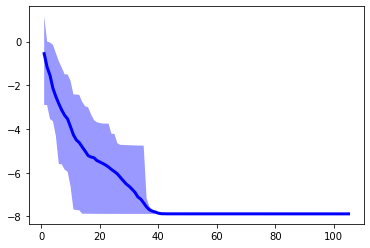

In [20]:
# Hard constraint
def run_BO_reg(x_conds,y_conds):
    '''
    Implement Bayesian optimization.
    
    Uses the expected improvement (EI) acquisition with local penalization and Matern5/2-ARD kernel.
    Generates a batch size of suggested conditions. 
    
    Inputs:
    x_conds             := input condition matrix (n by 3) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
      
    Ouputs:
    x_next              := suggested next x-conditions to sample from
    '''
    # run BO on the x-conditions conditions and their respective y-values
    bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)}, # 2D bounds
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
          ]
    constraint = [
    {
        'name': 'constr_1',
        'constraint': 'x[:,0] + x[:,1] - 1.4' # X+Y-1.4
    }]
    kernel = GPy.kern.Matern52(input_dim=len(bds), ARD = True) # Use the matern 5/2 kernel with automatic relevence detection enabled
    BO_opt = BayesianOptimization(f=None, 
                                     domain=bds,
                                     constraints = constraint,
                                     model_type='GP', # gaussian process model
                                     acquisition_type ='EI',
                                     X=x_conds, # input data
                                     Y=y_conds, # associated labels
                                     evaluator_type = 'local_penalization',
                                     batch_size = 1, # batch size of predicted optima
                                     normalize_Y= True,
                                     kernel = kernel # select the kernel
                                     )
    x_next = BO_opt.suggest_next_locations()
    return x_next

print('Starting BO . . .')
min_arr_cnstr = np.array(np.zeros((runs+lhs, test))) # array to plug in all minY vectors
for t in range(test):
    LHS = latin_hypercube(D=2, N=lhs) # randomize LHS selected points every loop
    Xs = LHS
    Ys = z(LHS[:,0],LHS[:,1])
    Ys = Ys.reshape(len(Ys),1)

    # run bo
    for n in range(runs):
        try:
            updx = run_BO_reg(x_conds = Xs, y_conds = Ys)
            updy = z(updx[:,0],updx[:,1])
            Xs = np.concatenate((Xs,updx))
            Ys = np.concatenate((Ys,updy.reshape(1,1)))
        except:
            print('> LinAlg exception.')
            Xs = np.concatenate((Xs,updx)) # from the previous round
            Ys = np.concatenate((Ys,updy.reshape(1,1))) # from the previous round
            continue
#         plt.figure(figsize=(6,5))
#         f = plt.contourf(X,Y,Z,20,cmap='PiYG_r')
#         zmin = np.where(Z == np.min(Z))
#         xmin = X[zmin[0][0], zmin[1][0]]
#         ymin = Y[zmin[0][0], zmin[1][0]]
    #     plt.scatter(xmin,ymin,marker='+',color='k',s=100)
    #     plt.scatter(Xs[:,0],Xs[:,1],c='k',alpha=0.5)
    #     plt.ylim(0,10)
    #     plt.xlim(0,10)
    #     plt.colorbar(f)
    # #     plt.contourf(X,Y,cnstr,cmap='gray',alpha=0.3)
    #     plt.title('Multimodal Benchmark Function')
    #     plt.show()



    minY = []
    minY.append(Ys[0])
    for n in range(len(Ys)-1):
        if Ys[n+1] < minY[n]:
            minY.append(Ys[n+1])
        else:
            minY.append(minY[n])
    min_arr_cnstr[:,t] = minY
    print(f'Completed validation round {t+1}/{test}.')
    
samples = np.arange(1,runs+lhs+1,1)
avg_min_max_cnstr = np.array(np.zeros((runs+lhs,3))) # columns: [average, lower 10th percentile, upper 90th percentile]
avg_min_max_cnstr[:, 0] = np.average(min_arr_cnstr, axis=1) # average
avg_min_max_cnstr[:, 1] = np.percentile(min_arr_cnstr, 10, axis=1) # 10th percentile
avg_min_max_cnstr[:, 2] = np.percentile(min_arr_cnstr, 90, axis=1) # 90th percentile
plt.plot(samples, avg_min_max_cnstr[:, 0], linewidth=3, c='b')
plt.fill_between(samples, avg_min_max_cnstr[:,1],avg_min_max_cnstr[:,2], facecolor='b', alpha = 0.4)

In [ ]:
# False constraint
def run_BO_reg(x_conds,y_conds):
    '''
    Implement Bayesian optimization.
    
    Uses the expected improvement (EI) acquisition with local penalization and Matern5/2-ARD kernel.
    Generates a batch size of suggested conditions. 
    
    Inputs:
    x_conds             := input condition matrix (n by 3) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
      
    Ouputs:
    x_next              := suggested next x-conditions to sample from
    '''
    # run BO on the x-conditions conditions and their respective y-values
    bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)}, # 2D bounds
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
          ]
    constraint = [
    {
        'name': 'constr_1',
        'constraint': '1-(15*np.exp(-x[:,0]*10/4)+15*np.exp(-x[:,1]*10/4) - 9)'
    }]
    kernel = GPy.kern.Matern52(input_dim=len(bds), ARD = True) # Use the matern 5/2 kernel with automatic relevence detection enabled
    BO_opt = BayesianOptimization(f=None, 
                                     domain=bds,
                                     constraints = constraint,
                                     model_type='GP', # gaussian process model
                                     acquisition_type ='EI',
                                     X=x_conds, # input data
                                     Y=y_conds, # associated labels
                                     evaluator_type = 'local_penalization',
                                     batch_size = 1, # batch size of predicted optima
                                     normalize_Y= True,
                                     kernel = kernel # select the kernel
                                     )
    x_next = BO_opt.suggest_next_locations()
    return x_next

print('Starting BO . . .')
min_arr_false = np.array(np.zeros((runs+lhs, test))) # array to plug in all minY vectors
for t in range(test):
    LHS = latin_hypercube(D=2, N=lhs) # randomize LHS selected points every loop
    Xs = LHS
    Ys = z(LHS[:,0],LHS[:,1])
    Ys = Ys.reshape(len(Ys),1)

    # run bo
    for n in range(runs):
        try:
            updx = run_BO_reg(x_conds = Xs, y_conds = Ys)
            updy = z(updx[:,0],updx[:,1])
            Xs = np.concatenate((Xs,updx))
            Ys = np.concatenate((Ys,updy.reshape(1,1)))
        except:
            print('> LinAlg exception.')
            Xs = np.concatenate((Xs,updx)) # from the previous round
            Ys = np.concatenate((Ys,updy.reshape(1,1))) # from the previous round
            continue
#         plt.figure(figsize=(6,5))
#         f = plt.contourf(X,Y,Z,20,cmap='PiYG_r')
#         zmin = np.where(Z == np.min(Z))
#         xmin = X[zmin[0][0], zmin[1][0]]
#         ymin = Y[zmin[0][0], zmin[1][0]]
    #     plt.scatter(xmin,ymin,marker='+',color='k',s=100)
    #     plt.scatter(Xs[:,0],Xs[:,1],c='k',alpha=0.5)
    #     plt.ylim(0,10)
    #     plt.xlim(0,10)
    #     plt.colorbar(f)
    # #     plt.contourf(X,Y,cnstr,cmap='gray',alpha=0.3)
    #     plt.title('Multimodal Benchmark Function')
    #     plt.show()



    minY = []
    minY.append(Ys[0])
    for n in range(len(Ys)-1):
        if Ys[n+1] < minY[n]:
            minY.append(Ys[n+1])
        else:
            minY.append(minY[n])
    min_arr_false[:,t] = minY
    print(f'Completed validation round {t+1}/{test}.')
    
samples = np.arange(1,runs+lhs+1,1)
avg_min_max_false = np.array(np.zeros((runs+lhs,3))) # columns: [average, lower 10th percentile, upper 90th percentile]
avg_min_max_false[:, 0] = np.average(min_arr_false, axis=1) # average
avg_min_max_false[:, 1] = np.percentile(min_arr_false, 10, axis=1) # 10th percentile
avg_min_max_false[:, 2] = np.percentile(min_arr_false, 90, axis=1) # 90th percentile
plt.plot(samples, avg_min_max_false[:, 0], linewidth=3, c='b')
plt.fill_between(samples, avg_min_max_false[:,1],avg_min_max_false[:,2], facecolor='b', alpha = 0.4)

Starting BO . . .
> LinAlg exception.
Completed validation round 1/50.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
Completed validation round 2/50.
> LinAlg exception.
> LinAlg exception.
Completed validation round 3/50.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> LinAlg exception.
> L

## Probabilistic Constrained BO

True Probabilistic Constraint

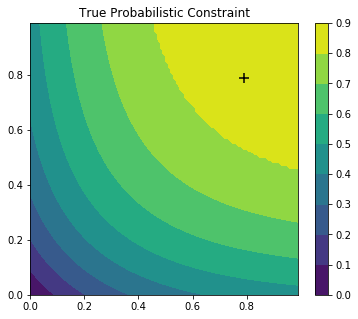

In [36]:
# plot prob constraint
xi = np.arange(0,1,0.01)
X, Y = np.meshgrid(xi,xi)
Z_prob_true = 1-(np.exp(-X*10/4)+np.exp(-Y*10/4))/2
Z_prob_true[Z_prob_true>0.8] = 0.9 # remove 100% probability region
plt.figure(figsize=(6,5))
f = plt.contourf(X,Y,Z_prob_true,10,cmap='viridis')
plt.colorbar(f)
plt.title('True Probabilistic Constraint')
plt.scatter(xmin,ymin,marker='+',color='k',s=100) # true global min

In [ ]:
# true probabilistic constraint
def run_BO_cnstr(x_conds,y_conds,constraint_function):
    '''
    Implement Bayesian optimization.
    
    ** constraint_function must be a numpy array of shape (3,100,100) for 3D using three 2D surfaces
        and (100,100) for 2D.
    
    Uses the expected improvement (EI) acquisition with local penalization and Matern5/2-ARD kernel.
    Generates a batch size of 10 suggested conditions. 
    
    Inputs:
    x_conds             := input condition matrix (n by 3) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
    constraint_function := is a (3,100,100) array of constraint values
      
    Ouputs:
    x_next              := suggested next x-conditions to sample from
    '''
    # run BO on the x-conditions conditions and their respective y-values
    bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)}, # 2D bounds
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)}
          ]
    kernel = GPy.kern.Matern52(input_dim=len(bds), ARD = True) # Use the matern 5/2 kernel with automatic relevence detection enabled
    BO_opt = BayesianOptimization(f=None, 
                                     domain=bds,
                                     constraints = None,
                                     model_type='GP', # gaussian process model
                                     constraint_function=constraint_function, # must be a numpy array of three 2D surfaces with shape (3,100,100)
                                     acquisition_type ='constrained_EI',
                                     X=x_conds, # input data
                                     Y=y_conds, # associated labels
                                     evaluator_type = 'local_penalization',
                                     batch_size = 1, # batch size of predicted optima
                                     normalize_Y= False,
                                     kernel = kernel # select the kernel
                                     )
#     BO_opt.plot_acquisition()
    x_next = BO_opt.suggest_next_locations()
    return x_next

print('Starting BO . . .')
min_arr_prob_true = np.array(np.zeros((runs+lhs, test))) # array to plug in all minY vectors
for t in range(test):
    LHS = latin_hypercube(D=2, N=lhs) # randomize LHS selected points every loop
    Xs = LHS
    Ys = z(LHS[:,0],LHS[:,1])
    Ys = Ys.reshape(len(Ys),1)

    # run bo
    for n in range(runs):
        try:
            updx = run_BO_cnstr(x_conds = Xs, y_conds = Ys, constraint_function = Z_prob_true)
            updy = z(updx[:,0],updx[:,1])
            Xs = np.concatenate((Xs,updx))
            Ys = np.concatenate((Ys,updy.reshape(1,1)))
        except:
            print('> LinAlg exception.')
            Xs = np.concatenate((Xs,updx)) # from the previous round
            Ys = np.concatenate((Ys,updy.reshape(1,1))) # from the previous round
            continue
        plt.figure(figsize=(6,5))
        f = plt.contourf(X,Y,Z,20,cmap='PiYG_r')
        c = plt.contourf(X,Y,Z_prob_true,10,cmap='viridis',alpha=0.3)
        zmin = np.where(Z == np.min(Z))
        xmin = X[zmin[0][0], zmin[1][0]]
        ymin = Y[zmin[0][0], zmin[1][0]]
        plt.scatter(xmin,ymin,marker='+',color='k',s=100)
        plt.scatter(Xs[:,0],Xs[:,1],c='k',alpha=0.5)
        plt.ylim(0,1)
        plt.xlim(0,1)
        plt.colorbar(f)
    #     plt.contourf(X,Y,cnstr,cmap='gray',alpha=0.3)
        plt.title('Multimodal Benchmark Function')
        plt.show()



    minY = []
    minY.append(Ys[0])
    for n in range(len(Ys)-1):
        if Ys[n+1] < minY[n]:
            minY.append(Ys[n+1])
        else:
            minY.append(minY[n])
    min_arr_prob_true[:,t] = minY
    print(f'Completed validation round {t+1}/{test}.')
    
samples = np.arange(1,runs+lhs+1,1)
avg_min_max_prob_true = np.array(np.zeros((runs+lhs,3))) # columns: [average, lower 10th percentile, upper 90th percentile]
avg_min_max_prob_true[:, 0] = np.average(min_arr_prob_true, axis=1) # average
avg_min_max_prob_true[:, 1] = np.percentile(min_arr_prob_true, 10, axis=1) # 10th percentile
avg_min_max_prob_true[:, 2] = np.percentile(min_arr_prob_true, 90, axis=1) # 90th percentile
plt.plot(samples, avg_min_max_prob_true[:, 0], linewidth=3, c='b')
plt.fill_between(samples, avg_min_max_prob_true[:,1],avg_min_max_prob_true[:,2], facecolor='b', alpha = 0.4)

global min @ x1 = 0.79, x2 = 0.79, z = -7.883282055049491


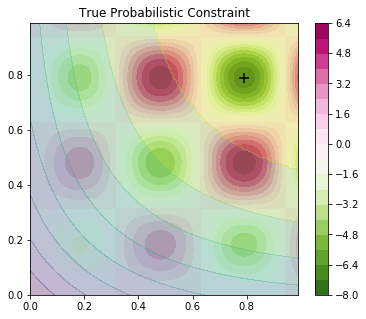

In [35]:
xi = np.arange(0,1,0.01)
X, Y = np.meshgrid(xi,xi)
Z = z(X,Y)
plt.figure(figsize=(6,5))
f = plt.contourf(X,Y,Z,20,cmap='PiYG_r')
c = plt.contourf(X,Y,Z_prob_true,10,cmap='viridis',alpha=0.3)
plt.scatter(xmin,ymin,marker='+',color='k',s=100)
# plt.scatter(Xs[:,0],Xs[:,1],c='k',alpha=0.3)
plt.colorbar(f)
plt.title('True Probabilistic Constraint')
print(f'global min @ x1 = {xmin}, x2 = {ymin}, z = {Z[zmin[0][0], zmin[1][0]]}')

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(samples, avg_min_max[:, 0], linewidth=3, c='#5f64c0', label='No Constraint')
plt.fill_between(samples, avg_min_max[:,1],avg_min_max[:,2], facecolor='#5f64c0', alpha = 0.3)

plt.plot(samples, avg_min_max_cnstr[:, 0], linewidth=3, c='#453064', label='Hard Constraint')
plt.fill_between(samples, avg_min_max_cnstr[:,1],avg_min_max_cnstr[:,2], facecolor='#453064', alpha = 0.3)

plt.plot(samples, avg_min_max_false[:, 0], linewidth=3, c='#449187', label='False Constraint')
plt.fill_between(samples, avg_min_max_false[:,1],avg_min_max_false[:,2], facecolor='#449187', alpha = 0.3)

plt.plot(samples, avg_min_max_prob_true[:, 0], linewidth=3, c='#91e4a6', label='True Probabilistic Constraint')
plt.fill_between(samples, avg_min_max_prob_true[:,1],avg_min_max_prob_true[:,2], facecolor='#91e4a6', alpha = 0.3)

plt.legend()
plt.axhline(zminval, linestyle= '--', c = 'gray')
plt.title('Convergence on Multimodal Function')
plt.savefig(impath + 'multimodal_convg_R2a.png', dpi = 300)

In [ ]:
# save average + percentile data

# no constraint
cnstr_none = pd.DataFrame(avg_min_max, columns = ['average', 'percentile10', 'percentile90'])
cnstr_none.to_csv(cwd + '\\05_Data\\no_constraint_runs50_lhs5_R2.csv', index = False)
# hard constraint
cnstr_hard = pd.DataFrame(avg_min_max_cnstr, columns = ['average', 'percentile10', 'percentile90'])
cnstr_hard.to_csv(cwd + '\\05_Data\\hard_constraint_runs50_lhs5_R2.csv', index = False)
# false constraint
cnstr_false = pd.DataFrame(avg_min_max_false, columns = ['average', 'percentile10', 'percentile90'])
cnstr_false.to_csv(cwd + '\\05_Data\\false_constraint_runs50_lhs5_R2.csv', index = False)
# true prob constraint
cnstr_prob_true = pd.DataFrame(avg_min_max_prob_true, columns = ['average', 'percentile10', 'percentile90'])
cnstr_prob_true.to_csv(cwd + '\\05_Data\\prob_true_constraint_runs50_lhs5_R2.csv', index = False)

In [ ]:
# save the raw data

# no constraint
all_cnstr_none = pd.DataFrame(min_arr)
all_cnstr_none = all_cnstr_none.add_prefix('run')
all_cnstr_none.to_csv(cwd + '\\05_Data\\all_no_constraint_runs50_lhs5_R2.csv', index = False)
# hard constraint
all_cnstr_hard = pd.DataFrame(min_arr_cnstr)
all_cnstr_hard = all_cnstr_hard.add_prefix('run')
all_cnstr_hard.to_csv(cwd + '\\05_Data\\all_hard_constraint_runs50_lhs5_R2.csv', index = False)
# false constraint
all_cnstr_false = pd.DataFrame(min_arr_false)
all_cnstr_false = all_cnstr_false.add_prefix('run')
all_cnstr_false.to_csv(cwd + '\\05_Data\\all_false_constraint_runs50_lhs5_R2.csv', index = False)
# true prob constraint
all_cnstr_true_prob = pd.DataFrame(min_arr_false)
all_cnstr_true_prob = all_cnstr_true_prob.add_prefix('run')
all_cnstr_true_prob.to_csv(cwd + '\\05_Data\\all_true_prob_constraint_runs50_lhs5_R2.csv', index = False)

Armi:
Error bars on the convergence plot.
Need unconstrained case v. constrained case with beneficial constraint v. constrained case with poor constraint (false/wrong results for a bad constraint) - cuts out global optimum.
Campaign2a constraint variable and then rescaling to a probability distribution.- first have data points then use GP regression and fit to data. Chose hyperparameters via separate optimization. Only difference is then scaling with sigmoid function rather than just normalizing- in case of effect being linear, don't want to scale. for DFT it is above 0, it is stable, if it is even a little below 0, it is unstable. Beta parameter defines how dramatic the sigmoid slope is. Based on DFT model accuracy. Only do this for one initial input.
Discuss proabbility distribution versus actual variable.

Discuss in the SI the physical model probbailistic constraint vs. hand creating the priors like I did. In the paper we just show the models.


In [19]:
path='C:/Users/alexs/Dropbox (MIT)/Buonassisi-Group/ASD Team/Archerfish/05_Data/Imaged_droplets/'
impath='C:/Users/alexs/Dropbox (MIT)/Buonassisi-Group/ASD Team/Learning_constraints/07_Figure_Graphs/Working_Folder/'
EI_drop_num=np.genfromtxt(path+'Dye_Set_EI_1/EI_drop_number.csv',delimiter=',')
MPI_drop_num=np.genfromtxt(path+'Dye_Set_MPI_1/MPI_drop_number.csv',delimiter=',')
LCB_drop_num=np.genfromtxt(path+'Dye_Set_LCB_1/LCB_drop_number.csv',delimiter=',')
drop_cat=np.concatenate((EI_drop_num,MPI_drop_num[20:],LCB_drop_num[20:]),axis=0)
drop_num=EI_drop_num # EI maps the cumulative of all 3 best. Plus EI has higher max droplet count than MPI (50 vs 30)
# grab all conditions + objective value + drop number
bo_full=pd.read_csv(path+'bo_full.csv',delimiter=',')
bo_full['DropCount']=drop_cat[:,3]
bo_full

Sample           Batch Method  Pressure  Frequency  Speed  Objective  \
0         1  Initialization    LHS     0.583      0.719  0.002      1.000   
1         2  Initialization    LHS     0.917      0.294  0.059      1.000   
2         3  Initialization    LHS     0.667      0.552  0.118      1.000   
3         4  Initialization    LHS     0.333      0.927  0.165      1.000   
4         5  Initialization    LHS     0.083      0.169  0.226      1.000   
..      ...             ...    ...       ...        ...    ...        ...   
135     136         Batch 4    LCB     1.000      1.000  1.000      1.000   
136     137         Batch 4    LCB     0.000      0.869  0.068      1.000   
137     138         Batch 4    LCB     0.250      0.065  0.992      0.569   
138     139         Batch 4    LCB     0.000      0.050  0.016      1.000   
139     140         Batch 4    LCB     0.917      0.009  0.848      0.746   

     DropCount  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  
..         ...  
135        0.0  
136        0.0  
137       36.0  
138        0.0  
139        7.0  

[140 rows x 8 columns]

## Definitions

In [12]:
# create interpolation field and avoid singular matrix by removing repeating points
def interp_field(y_conds,x_conds):
    '''
    Inputs:
    xy_conds:=   Dx4 data array where the first 3 columns are pressure, frequency, speed 
                 and the 4th column are the y-values
    '''
    for n in range(3):
        cv_x_temp0=np.copy(x_conds[:,n])
        cv_x_temp1=np.copy(x_conds[:,(n+1)%3])
        cv_y_temp=np.copy(y_conds) # y condition
        for i in range(x_conds.shape[0]):
            for j in range(x_conds.shape[0]):
                if cv_x_temp0[i]==cv_x_temp0[j] and cv_x_temp1[i]==cv_x_temp1[j] and i!=j:
                    if cv_y_temp[i] < cv_y_temp[j]: # want to remove failed prints over good prints
                        cv_x_temp0[j]=np.nan
                        cv_x_temp1[j]=np.nan
                        cv_y_temp[j]=np.nan
                    else:
                        cv_x_temp0[i]=np.nan
                        cv_x_temp1[i]=np.nan
                        cv_y_temp[i]=np.nan
        cv_x_temp0=cv_x_temp0[~np.isnan(cv_x_temp0)]
        cv_x_temp1=cv_x_temp1[~np.isnan(cv_x_temp1)]
        cv_y_temp=cv_y_temp[~np.isnan(cv_y_temp)]
        globals()['rbf_'+str(n)]=Rbf(cv_x_temp0,cv_x_temp1,cv_y_temp,function='linear')
    return rbf_0, rbf_1, rbf_2
def interp_values(x_predict,y_all,x_all):
    '''
    x_predict :=    [x1,x2,x3] conditions to predict an output value
    y_all     :=    1D array of values to interpolate
    x_all     :=    Nx3 arry of conditions to use to interpolate y_all
    '''
    rbf_0,rbf_1,rbf_2=interp_field(y_conds=y_all,x_conds=x_all) # get interpolation fields in 2D slice
    val=np.array([rbf_0(x_predict[0],x_predict[1]),rbf_1(x_predict[1],x_predict[2]),rbf_2(x_predict[2],x_predict[0])]) # predict
    val = np.mean(val, axis = 0) # linearly interpolate predicted values
    val[val < 0.] = 0. # set all negative values equal to 0
    return val
# normalization function
def normalize_it(array):
    return (array - np.min(array))/((np.max(array-np.min(array))))
# output acquisition function 2D slices to augment with constraint funciton
def output_acquisition(x_conds,y_conds,constraint_function):
    '''
    Output the aquisition function so it can be augmented by the constraint function
    
    Inputs:
    x_conds             := input condition matrix (n by 3) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
    constraint_function := is a (3,100,100) array of constraint values
      
    Ouputs:
    list                := a list of 3 acquisition function value 2D slices
    '''
        
    # re-run BO in 2D slices to get acquisition value fields for plotting
    aq_bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)},
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
          ]
    for n in range(3):
        aq_kernel = GPy.kern.Matern52(input_dim=len(aq_bds), ARD = True)
        acq_2D = BayesianOptimization(f=None, 
                                         domain=aq_bds,
                                         constraints = None,
                                         model_type='GP',
                                         constraint_function=constraint_function[n,:,:],
                                         acquisition_type ='constrained_EI',
                                         X=x_conds[:,[n,(n+1)%3]],
                                         Y=y_conds,
                                         evaluator_type = 'local_penalization',
                                         batch_size = 10,
                                         normalize_Y= False,
                                         #noise_var = 0.02**2,
                                         kernel = aq_kernel
                                         )
        globals()['acq_slice'+str(n)]=acq_2D.plot_acquisition()
        
    return [acq_slice0,acq_slice1,acq_slice2]
# run BO using the constrained acquisition function
def run_BO(x_conds,y_conds,constraint_function):
    '''
    Implement Bayesian optimization.
    
    ** constraint_function must be a numpy array of shape (3,100,100) for 3D using three 2D surfaces
        and (100,100) for 2D.
    
    Uses the expected improvement (EI) acquisition with local penalization and Matern5/2-ARD kernel.
    Generates a batch size of 10 suggested conditions. 
    
    Inputs:
    x_conds             := input condition matrix (n by 3) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
    constraint_function := is a (3,100,100) array of constraint values
      
    Ouputs:
    x_next              := suggested next x-conditions to sample from
    '''
    # run BO on the x-conditions conditions and their respective y-values
    bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)}, # 3D bounds
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
           {'name': 'x3', 'type': 'continuous', 'domain': (0, 1)},
          ]
    kernel = GPy.kern.Matern52(input_dim=len(bds), ARD = True) # Use the matern 5/2 kernel with automatic relevence detection enabled
    BO_opt = BayesianOptimization(f=None, 
                                     domain=bds,
                                     constraints = None,
                                     model_type='GP', # gaussian process model
                                     constraint_function=constraint_function, # must be a numpy array of three 2D surfaces with shape (3,100,100)
                                     acquisition_type ='constrained_EI',
                                     X=x_conds, # input data
                                     Y=y_conds, # associated labels
                                     evaluator_type = 'local_penalization',
                                     batch_size = 10, # batch size of predicted optima
                                     normalize_Y= False,
                                     kernel = kernel # select the kernel
                                     )
    x_next = BO_opt.suggest_next_locations()
    return x_next
# create new prior from the previous posteriors by interpolating the distributions
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)
# output acquisition function 2D slices to augment with constraint funciton
def output_acquisition_reg(x_conds,y_conds):
    '''
    Output the aquisition function
    
    Inputs:
    x_conds             := input condition matrix (n by 3) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
      
    Ouputs:
    list                := a list of 3 acquisition function value 2D slices
    '''
        
    # re-run BO in 2D slices to get acquisition value fields for plotting
    aq_bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)},
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
          ]
    for n in range(3):
        aq_kernel = GPy.kern.Matern52(input_dim=len(aq_bds), ARD = True)
        acq_2D = BayesianOptimization(f=None, 
                                         domain=aq_bds,
                                         constraints = None,
                                         model_type='GP',
                                         acquisition_type ='EI',
                                         X=x_conds[:,[n,(n+1)%3]],
                                         Y=y_conds,
                                         evaluator_type = 'local_penalization',
                                         batch_size = 10,
                                         normalize_Y= False,
                                         #noise_var = 0.02**2,
                                         kernel = aq_kernel
                                         )
        globals()['acq_slice'+str(n)]=acq_2D.plot_acquisition()
        
    return [acq_slice0,acq_slice1,acq_slice2]
# run BO using the constrained acquisition function
def run_BO_reg(x_conds,y_conds):
    '''
    Implement Bayesian optimization.
    
    Uses the expected improvement (EI) acquisition with local penalization and Matern5/2-ARD kernel.
    Generates a batch size of 10 suggested conditions. 
    
    Inputs:
    x_conds             := input condition matrix (n by 3) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
      
    Ouputs:
    x_next              := suggested next x-conditions to sample from
    '''
    # run BO on the x-conditions conditions and their respective y-values
    bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)}, # 3D bounds
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
           {'name': 'x3', 'type': 'continuous', 'domain': (0, 1)},
          ]
    kernel = GPy.kern.Matern52(input_dim=len(bds), ARD = True) # Use the matern 5/2 kernel with automatic relevence detection enabled
    BO_opt = BayesianOptimization(f=None, 
                                     domain=bds,
                                     constraints = None,
                                     model_type='GP', # gaussian process model
                                     acquisition_type ='EI',
                                     X=x_conds, # input data
                                     Y=y_conds, # associated labels
                                     evaluator_type = 'local_penalization',
                                     batch_size = 10, # batch size of predicted optima
                                     normalize_Y= False,
                                     kernel = kernel # select the kernel
                                     )
    x_next = BO_opt.suggest_next_locations()
    return x_next

In [13]:
# Grab initialization data only
output_obj=np.array(bo_full['Objective'][:20]) # objective value
output_drops=np.array(bo_full['DropCount'][:20]) # number of droplets
pressure=np.array(bo_full['Pressure'][:20])
frequency=np.array(bo_full['Frequency'][:20])
speed=np.array(bo_full['Speed'][:20])
# start conditions lists
x_conds = [np.array([pressure,frequency,speed]).T] # X conditions
y_obj = [output_obj] # Objective values
y_cnt = [output_drops] # Number of droplets
# get meshgrid for plotting
xx, yy = [np.linspace(0,1,100),np.linspace(0,1,100)] # MESH SIZE MUST BE 100X100 IN ORDER FOR CONSTRAINT FUNCTION TO WORK IN BO LOOP
XX, YY = np.meshgrid (xx,yy)

# Initialize BO + Constraints

## Initialize constraint function priors using moderately-informed priors


I am aiming to reverse-engineer priors from the relationships between inputs-outputs.

First, the KDE is plotted for the LHS initialized data for pressure-ouput, frequency-output, speed-output.

Using the KDE visualization, I create a generative model for each input condition which generates similarly distributed droplet count values given inputs $\in[0,1]$

Then I create a model using those priors for our constraint function (the number of droplets)

### Continuous priors in pymc3

https://docs.pymc.io/api/distributions/continuous.html

In [14]:
# definition to plot kernel density estimation from scatter points
def density_estimation(m1, m2):
    xmin=np.min(m1)
    xmax=np.max(m1)
    ymin=np.min(m2)
    ymax=np.max(m2)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = stats.gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z

#### Pressure priors in 1D

In [15]:
with pm.Model() as pressure_model:
    alpha0=pm.Uniform('alpha0',lower=0,upper=40) #bias
    alpha1=pm.Gamma('alpha1',alpha=0.7,beta=0.5)
pressure_trace=pm.sample(1000,model=pressure_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha1, alpha0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


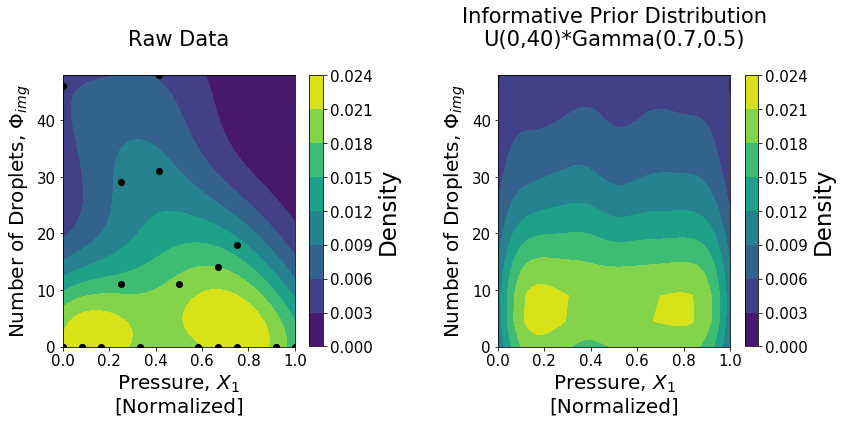

In [21]:
# Model pressure vs droplet count with continuous distributions
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(13,5))
plt.subplots_adjust(wspace=0.5)
val0=pressure
X0, Y0, Z0 = density_estimation(val0, output_drops)
pl1=ax1.contourf(X0,Y0,Z0,linewidths=3)
ax1.scatter(val0,output_drops,c='k')
cbar1=fig.colorbar(pl1,ax=ax1)
cbar1.ax.tick_params(labelsize=15) 
cbar1.set_label('Density',size=23)
# cbar1.lines[0].set_linewidth(10)
ax1.set_ylim([0,np.max(output_drops)])
ax1.set_xlim([0,1])
ax1.tick_params(labelsize=15)
ax1.set_xlabel('Pressure, $X_1$\n[Normalized]',size=20)
ax1.set_ylabel('Number of Droplets, $\Phi_{img}$',size=20)
ax1.set_title('Raw Data\n',size=21)


out0,out1=pressure_trace['alpha0'],pressure_trace['alpha1']
out=out0*out1
val1=np.linspace(0.0,1,len(out))
X1, Y1, Z1 = density_estimation(val1, out)
pl2=ax2.contourf(X1,Y1,Z1,linewidths=3)
cbar2=fig.colorbar(pl2,ax=ax2)
cbar2.ax.tick_params(labelsize=15) 
cbar2.set_label('Density',size=23)
# cbar2.lines[0].set_linewidth(10)
ax2.set_ylim([0,np.max(output_drops)])
ax2.set_xlim([0,1])
ax2.tick_params(labelsize=15)
ax2.set_xlabel('Pressure, $X_1$\n[Normalized]',size=20)
ax2.set_ylabel('Number of Droplets, $\Phi_{img}$',size=20)
ax2.set_title('Informative Prior Distribution\nU(0,40)*Gamma(0.7,0.5)\n',size=21)

# plt.savefig(impath+'priors_x1.png',dpi=300,bbox_inches='tight')

#### Frequency priors in 1D

In [22]:
with pm.Model() as frequency_model:
    beta0=pm.Uniform('beta0',lower=0,upper=90) #bias
    beta1=pm.Gamma('beta1',alpha=0.7,beta=0.5)
frequency_trace=pm.sample(1000,model=frequency_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


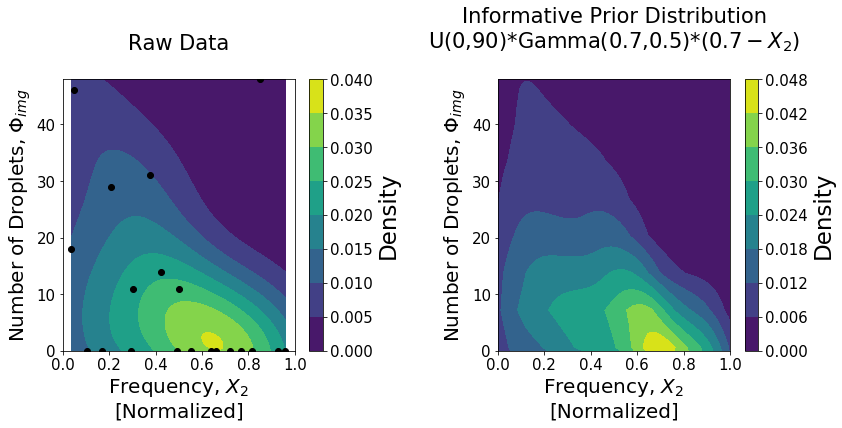

In [23]:
# Model frequency vs droplet count with continuous distributions
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(13,5))
plt.subplots_adjust(wspace=0.5)
val0=frequency
X0, Y0, Z0 = density_estimation(val0, output_drops)
pl1=ax1.contourf(X0,Y0,Z0,linewidths=3)
ax1.scatter(val0,output_drops,c='k')
cbar1=fig.colorbar(pl1,ax=ax1)
cbar1.ax.tick_params(labelsize=15) 
cbar1.set_label('Density',size=23)
# cbar1.lines[0].set_linewidth(10)
ax1.set_ylim([0,np.max(output_drops)])
ax1.set_xlim([0,1])
ax1.tick_params(labelsize=15)
ax1.set_xlabel('Frequency, $X_2$\n[Normalized]',size=20)
ax1.set_ylabel('Number of Droplets, $\Phi_{img}$',size=20)
ax1.set_title('Raw Data\n',size=21)


out0,out1=frequency_trace['beta0'],frequency_trace['beta1']
out=out0*out1*(0.7-val1)
val1=np.linspace(0.0,1,len(out))
X1, Y1, Z1 = density_estimation(val1, out)
pl2=ax2.contourf(X1,Y1,Z1,linewidths=3)
cbar2=fig.colorbar(pl2,ax=ax2)
cbar2.ax.tick_params(labelsize=15) 
cbar2.set_label('Density',size=23)
# cbar2.lines[0].set_linewidth(10)
ax2.set_ylim([0,np.max(output_drops)])
ax2.set_xlim([0,1])
ax2.tick_params(labelsize=15)
ax2.set_xlabel('Frequency, $X_2$\n[Normalized]',size=20)
ax2.set_ylabel('Number of Droplets, $\Phi_{img}$',size=20)
ax2.set_title('Informative Prior Distribution\nU(0,90)*Gamma(0.7,0.5)*($0.7-X_2$)\n',size=21)

# plt.savefig(impath+'priors_x2.png',dpi=300,bbox_inches='tight')

#### Speed priors in 1D

In [24]:
with pm.Model() as speed_model:
    gamma0=pm.Uniform('gamma0',lower=0,upper=90) #bias
    gamma1=pm.Gamma('gamma1',alpha=0.7,beta=0.5)
speed_trace=pm.sample(1000,model=speed_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma1, gamma0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


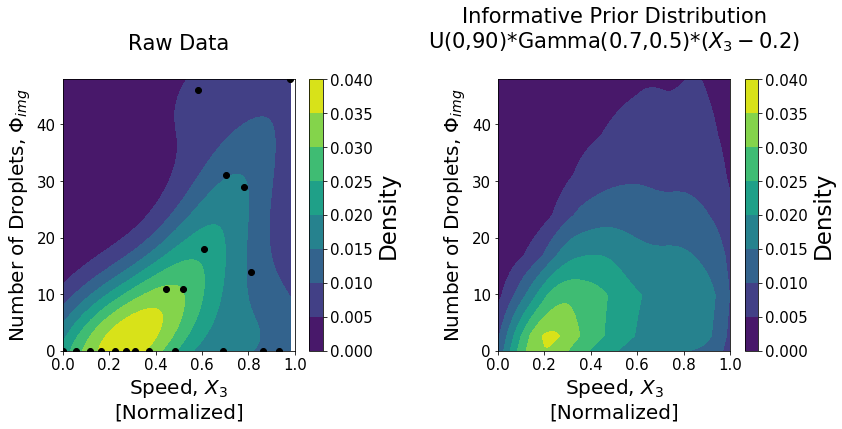

In [25]:
# Model speed vs droplet count with continuous distributions
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(13,5))
plt.subplots_adjust(wspace=0.5)
val0=speed
X0, Y0, Z0 = density_estimation(val0, output_drops)
pl1=ax1.contourf(X0,Y0,Z0,linewidths=3)
ax1.scatter(val0,output_drops,c='k')
cbar1=fig.colorbar(pl1,ax=ax1)
cbar1.ax.tick_params(labelsize=15) 
cbar1.set_label('Density',size=23)
# cbar1.lines[0].set_linewidth(10)
ax1.set_ylim([0,np.max(output_drops)])
ax1.set_xlim([0,1])
ax1.tick_params(labelsize=15)
ax1.set_xlabel('Speed, $X_3$\n[Normalized]',size=20)
ax1.set_ylabel('Number of Droplets, $\Phi_{img}$',size=20)
ax1.set_title('Raw Data\n',size=21)


out0,out1=speed_trace['gamma0'],speed_trace['gamma1']
out=out0*out1*(val1-0.2)
val1=np.linspace(0.0,1,len(out))
X1, Y1, Z1 = density_estimation(val1, out)
pl2=ax2.contourf(X1,Y1,Z1,linewidths=3)
cbar2=fig.colorbar(pl2,ax=ax2)
cbar2.ax.tick_params(labelsize=15) 
cbar2.set_label('Density',size=23)
# cbar2.lines[0].set_linewidth(10)
ax2.set_ylim([0,np.max(output_drops)])
ax2.set_xlim([0,1])
ax2.tick_params(labelsize=15)
ax2.set_xlabel('Speed, $X_3$\n[Normalized]',size=20)
ax2.set_ylabel('Number of Droplets, $\Phi_{img}$',size=20)
ax2.set_title('Informative Prior Distribution\nU(0,90)*Gamma(0.7,0.5)*($X_3-0.2$)\n',size=21)

# plt.savefig(impath+'priors_x3.png',dpi=300,bbox_inches='tight')

## Build initialization model from the moderately-informed priors

In [27]:
# initialize model priors
traces = [] # create list to append traces of priors
init_model = Model()
with init_model:
    # Priors for unknown model parameters
    alpha1 = pm.Normal("alpha1", mu=0, sigma=1)
    alpha2 = pm.Normal("alpha2", mu=0, sigma=1)
    alpha3 = pm.Normal("alpha3", mu=0, sigma=1)
    beta1 = pm.Gamma("beta1", alpha=0.7, beta=0.5)
    beta2 = pm.Gamma("beta2", alpha=0.7, beta=0.5)
    beta3 = pm.Gamma("beta3", alpha=0.7, beta=0.5)
    
    # Expected value of outcome
    mu1 = alpha1 + beta1 * pressure + beta2 * (0.7-frequency) # pressure-frequency
    mu2 = alpha2 + beta2 * (0.7-frequency) + beta3 * (speed-0.2) # frequency-speed
    mu3 = alpha3 + beta3 * (speed-0.2) + beta1 * pressure # speed-pressure

    # Likelihood (sampling distribution) of observations
    Y1_pressure_frequency = Normal("Y1_pressure_frequency", mu = mu1, sigma=1, observed=y_cnt[0])
    Y1_frequency_speed = Normal("Y1_frequency_speed", mu = mu2, sigma=1, observed=y_cnt[0])
    Y1_speed_pressure = Normal("Y1_speed_pressure", mu = mu3, sigma=1, observed=y_cnt[0])

    # draw 1000 posterior samples using HMC
    trace = sample(1000)
    traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta3, beta2, beta1, alpha3, alpha2, alpha1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 264 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [28]:
# compute simulated droplet numbers for each 2D slice
X_sim=np.linspace(0,1,len(trace['alpha1']))
Y_pf = trace['alpha1']+trace['beta1']*X_sim+trace['beta2']*(0.7-X_sim)
# Y_pf_norm = normalize_it(Y_pressure_frequency) # normalize
Y_fs = trace['alpha2']+trace['beta2']*(0.7-X_sim)+trace['beta3']*(X_sim-0.2)
# Y_fs_norm = normalize_it(Y_frequency_speed) # normalize
Y_sp = trace['alpha3']+trace['beta1']*X_sim+trace['beta3']*(X_sim-0.2)
# Y_sp_norm = normalize_it(Y_speed_pressure) # normalize

# run interpolation
dropnum_2Ds=[]
# pressure-frequency
rbf_pf=Rbf(X_sim,X_sim,Y_pf,function='linear')
surf_f0=rbf_pf(XX,YY)
# frequency-speed
rbf_fs=Rbf(X_sim,X_sim,Y_fs,function='linear')
surf_f1=rbf_fs(XX,YY)
# speed-pressure
rbf_sp=Rbf(X_sim,X_sim,Y_sp,function='linear')
surf_f2=rbf_sp(XX,YY)
max_norm = np.max([surf_f0,surf_f1,surf_f2])
dropnum_2Ds.append(np.array([surf_f0/max_norm,surf_f1/max_norm,surf_f2/max_norm]))

## Run first round of BO using the constraint function learned from LHS initialized data

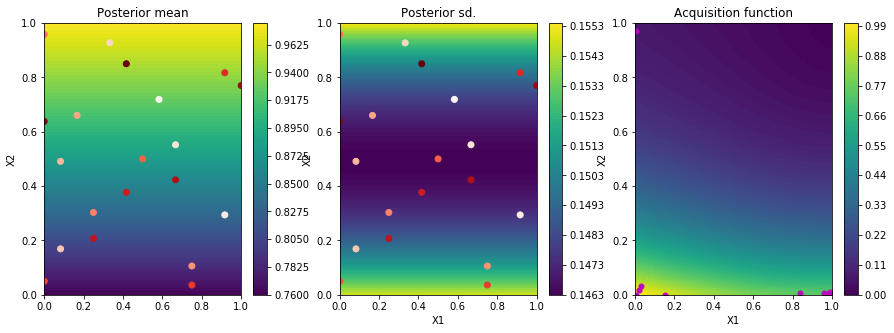

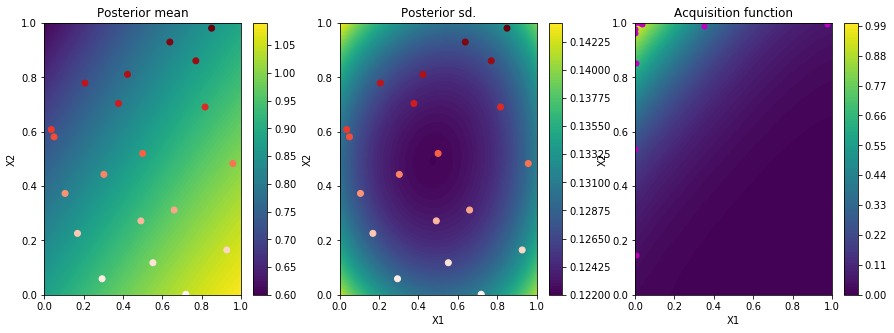

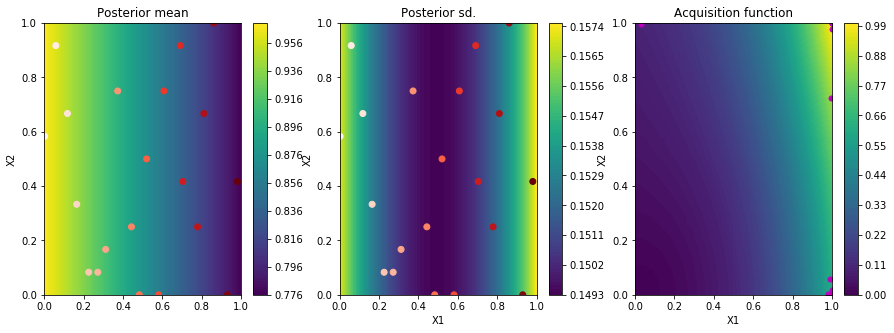

In [29]:
# RUN BO and get the new 10 output conditions using the the 20 LHS initialized conditions, objective values, and constraints
acq_2Ds=[] # list of acquisition function spaces
acq_2Ds.append(output_acquisition(x_conds=x_conds[0], y_conds=y_obj[0].reshape(len(y_obj[0]),1), constraint_function = dropnum_2Ds[0]))
x_conds.append(run_BO(x_conds=x_conds[0], y_conds=y_obj[0].reshape(len(y_obj[0]),1), constraint_function = dropnum_2Ds[0]))

# Update BO + Constraints

In [35]:
# all condition values
XS=np.array(bo_full[['Pressure','Frequency','Speed']])
Y_obj=np.array(bo_full['Objective'])
Y_cnt=np.array(bo_full['DropCount'])

In [36]:
# Begin loop
# assign variables
Xp = x_conds[0][:,0] # pressure
Xf = x_conds[0][:,1] # frequency
Xs = x_conds[0][:,2] # speed
Yo = y_obj[0] # objective value
Yc = y_cnt[0] # droplet count
for i in range(10):
    print('','='*30,'\n BO + Constraints Batch Update '+str(i+1),'\n','='*30)
    # ==================================================================================
    # get interpolation field of objective value and droplet counts
    y_obj.append(interp_values(x_predict = x_conds[i+1].T, y_all = Y_obj, x_all = XS)) # use first batch after initilization
    y_cnt.append(interp_values(x_predict = x_conds[i+1].T, y_all = Y_cnt, x_all = XS)) # use first batch after initilization
    # assign variables from first update
    Xp = np.concatenate((Xp, x_conds[i+1][:,0])) # pressure
    Xf = np.concatenate((Xf, x_conds[i+1][:,1])) # frequency
    Xs = np.concatenate((Xs, x_conds[i+1][:,2])) # speed
    Yo = np.concatenate((Yo, y_obj[i+1])) # objective value
    Yc = np.concatenate((Yc, y_cnt[i+1])) # droplet count
    # ==================================================================================
    # get new HMC estimations of droplet count priors to learn the constraint with the new y_cnt data from previous batch
    update_model = Model()
    with update_model:
        # Priors are posteriors from previous iteration
        alpha1 = from_posterior("alpha1", traces[i]["alpha1"])
        alpha2 = from_posterior("alpha2", traces[i]["alpha2"])
        alpha3 = from_posterior("alpha3", traces[i]["alpha3"])
        beta1 = from_posterior("beta1", traces[i]["beta1"])
        beta2 = from_posterior("beta2", traces[i]["beta2"])
        beta3 = from_posterior("beta3", traces[i]["beta3"])

        # Expected value of outcome
        mu1 = alpha1 + beta1 * Xp + beta2 * (0.7-Xf) # pressure-frequency
        mu2 = alpha2 + beta2 * (0.7-Xf) + beta3 * (Xs-0.2) # frequency-speed
        mu3 = alpha3 + beta3 * (Xs-0.2) + beta1 * Xp # speed-pressure
        
        # Likelihood (sampling distribution) of observations
        Y1_pressure_frequency = Normal("Y1_pressure_frequency", mu = mu1, sigma=1, observed=Yc) # observed droplet count
        Y1_frequency_speed = Normal("Y1_frequency_speed", mu = mu2, sigma=1, observed=Yc) # observed droplet count
        Y1_speed_pressure = Normal("Y1_speed_pressure", mu = mu3, sigma=1, observed=Yc) # observed droplet count
        
        # draw 10000 posterior samples
        trace = sample(1000)
        traces.append(trace)
    # ==================================================================================
    # compute simulated droplet numbers for each 2D slice
    Y_pf = traces[i+1]['alpha1']+traces[i+1]['beta1']*X_sim+traces[i+1]['beta2']*(0.7-X_sim)
#     Y_pf_norm = normalize_it(Y_pressure_frequency)
    Y_fs = traces[i+1]['alpha2']+traces[i+1]['beta2']*(0.7-X_sim)+traces[i+1]['beta3']*(X_sim-0.2)
#     Y_fs_norm = normalize_it(Y_frequency_speed)
    Y_sp = traces[i+1]['alpha3']+traces[i+1]['beta1']*X_sim+traces[i+1]['beta3']*(X_sim-0.2)
#     Y_sp_norm = normalize_it(Y_speed_pressure)
    # run interpolation
    # pressure-frequency
    rbf_pf=Rbf(X_sim,X_sim,Y_pf,function='linear')
    surf_f0=rbf_pf(XX,YY)
    # frequency-speed
    rbf_fs=Rbf(X_sim,X_sim,Y_fs,function='linear')
    surf_f1=rbf_fs(XX,YY)
    # speed-pressure
    rbf_sp=Rbf(X_sim,X_sim,Y_sp,function='linear')
    surf_f2=rbf_sp(XX,YY)
    max_norm = np.max([surf_f0,surf_f1,surf_f2])
    dropnum_2Ds.append(np.array([surf_f0/max_norm,surf_f1/max_norm,surf_f2/max_norm]))
    # ==================================================================================
    # Run BO batch
    acq_2Ds.append(output_acquisition(x_conds=np.array([Xp,Xf,Xs]).T, y_conds=Yo.reshape(len(Yo),1), constraint_function = dropnum_2Ds[i+1])) # get 2D acquisition slices soley for plotting cubes
    x_conds.append(run_BO(x_conds=np.array([Xp,Xf,Xs]).T, y_conds=Yo.reshape(len(Yo),1), constraint_function = dropnum_2Ds[i+1])) # get new x-condition optima

 BO + Constraints Batch Update 1 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta3, beta2, beta1, alpha3, alpha2, alpha1]


ValueError: Not enough samples to build a trace.

# Regular BO

 Regular BO Batch Update 1 


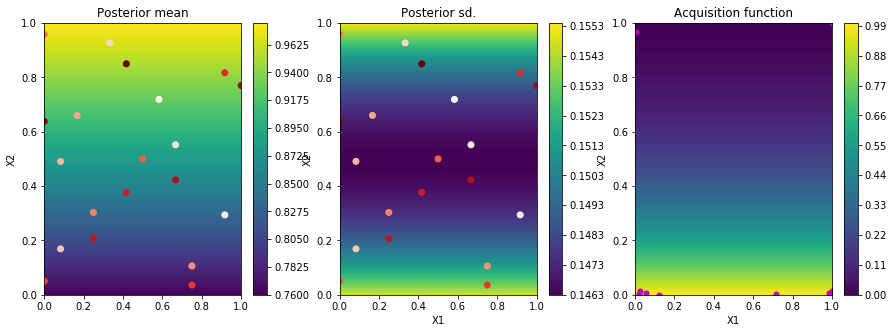

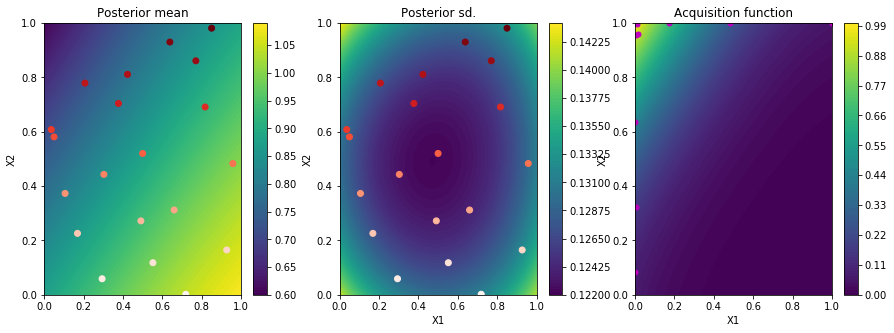

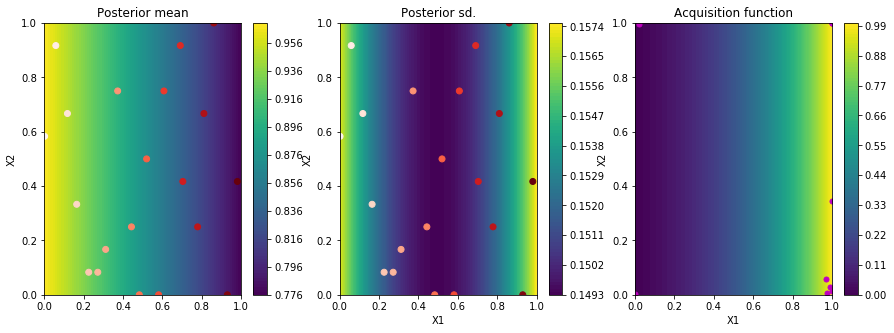

 Regular BO Batch Update 2 


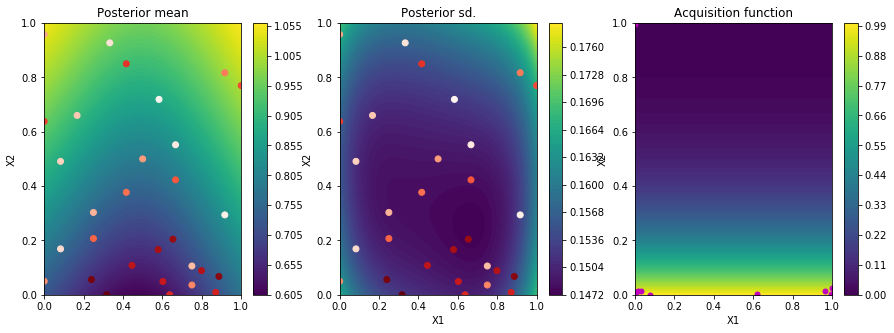

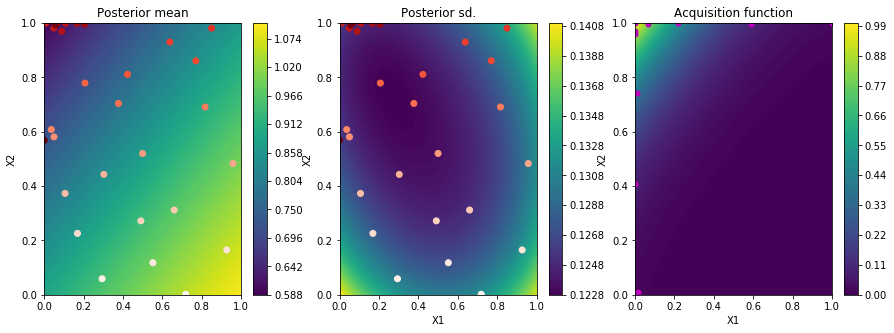

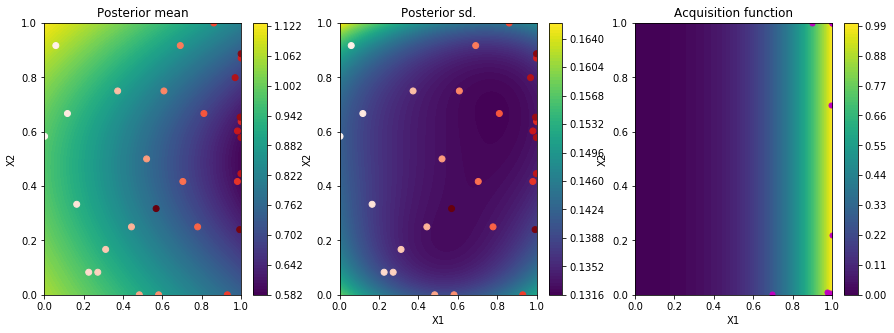

 Regular BO Batch Update 3 


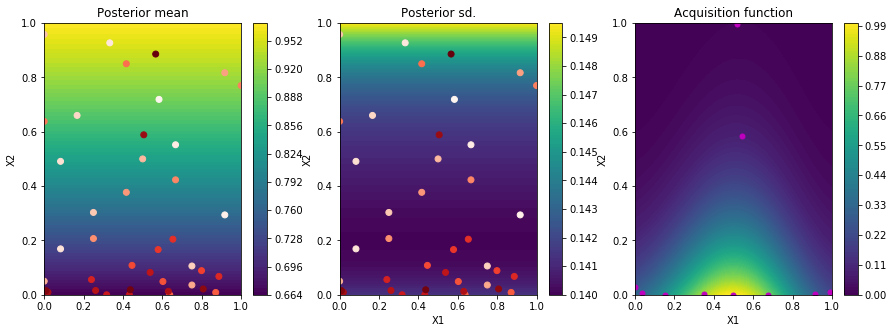

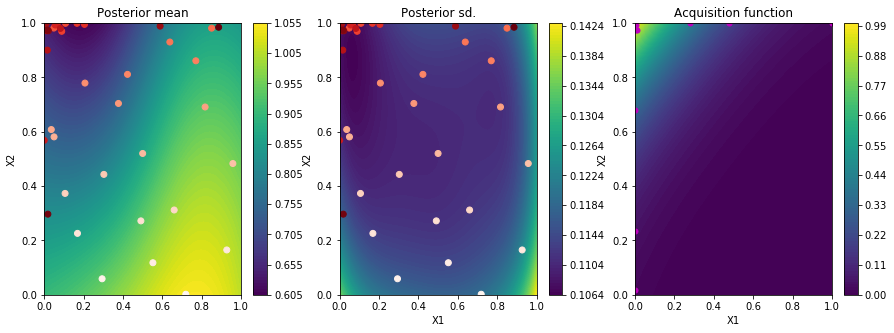

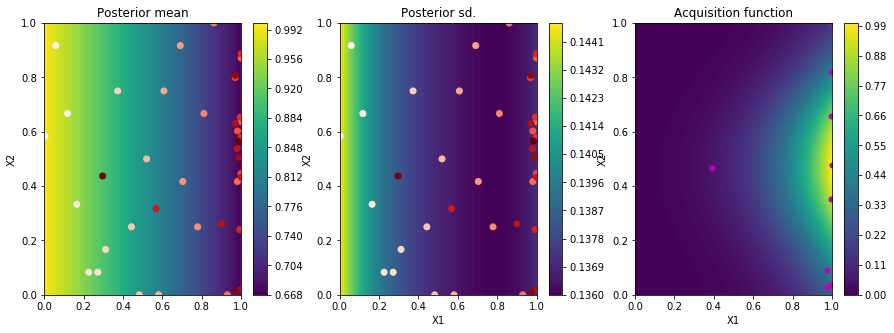

 Regular BO Batch Update 4 


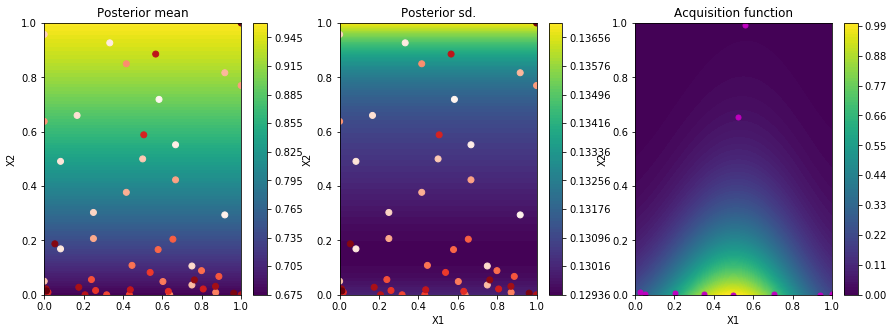

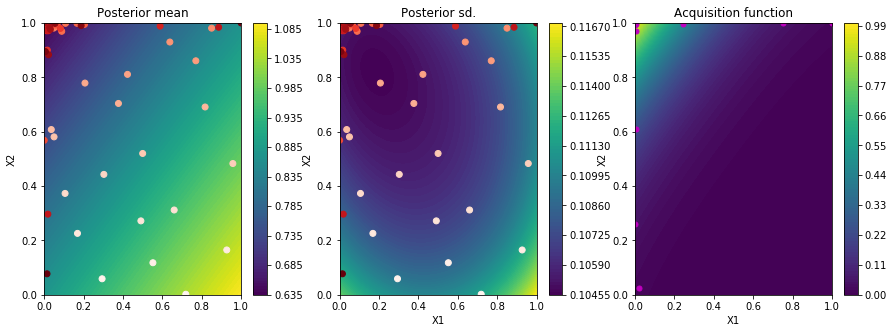

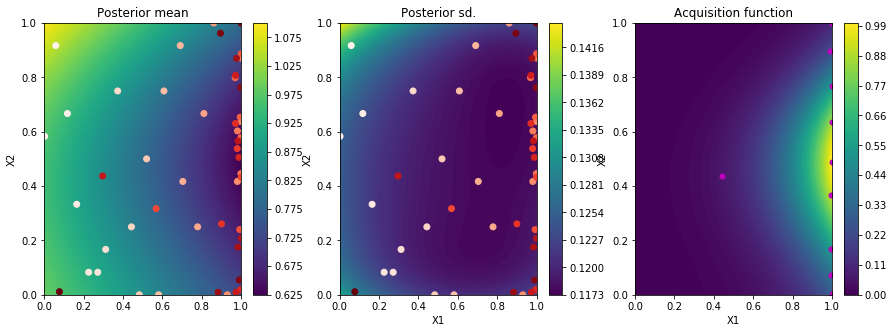

 Regular BO Batch Update 5 


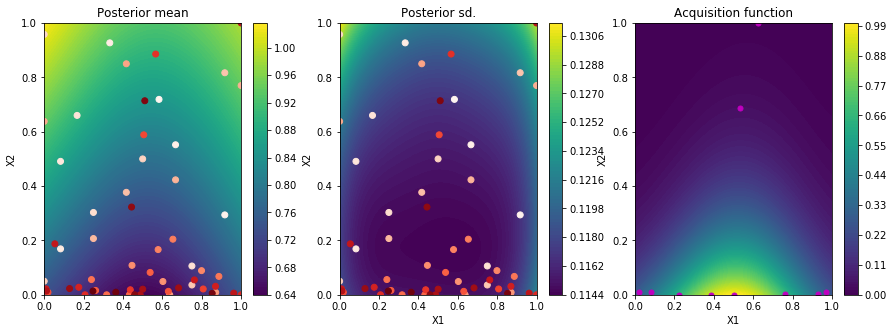

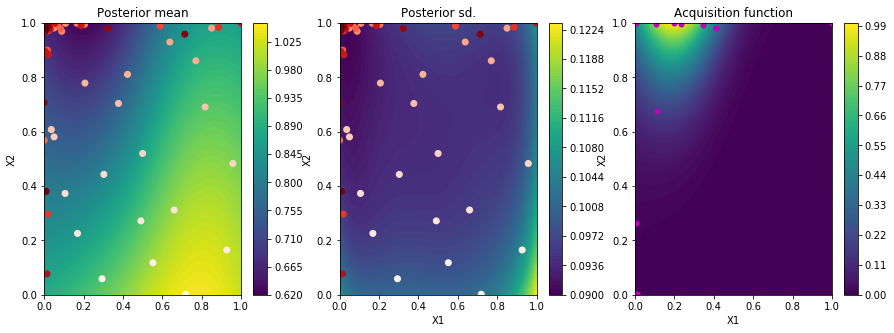

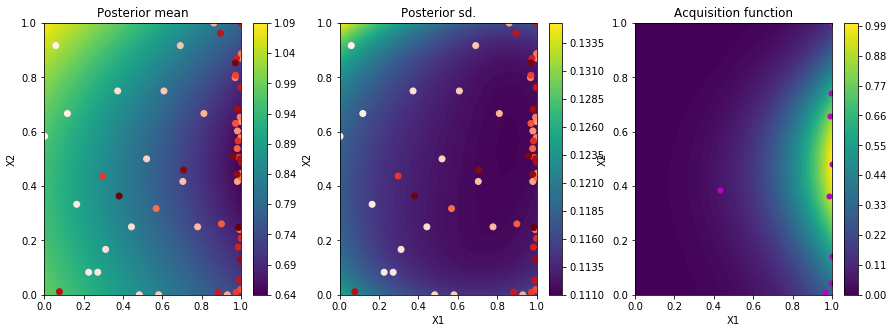

 Regular BO Batch Update 6 


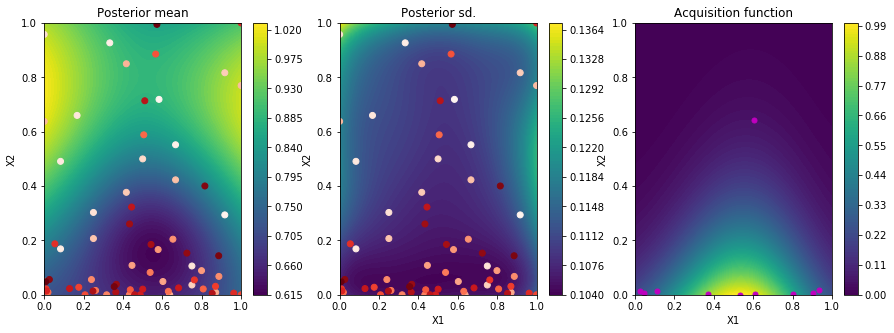

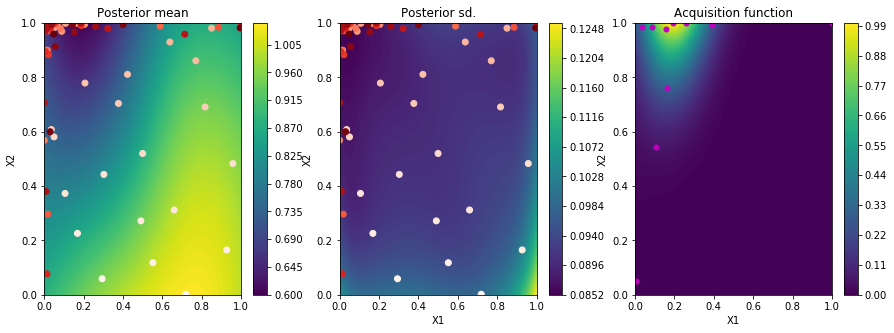

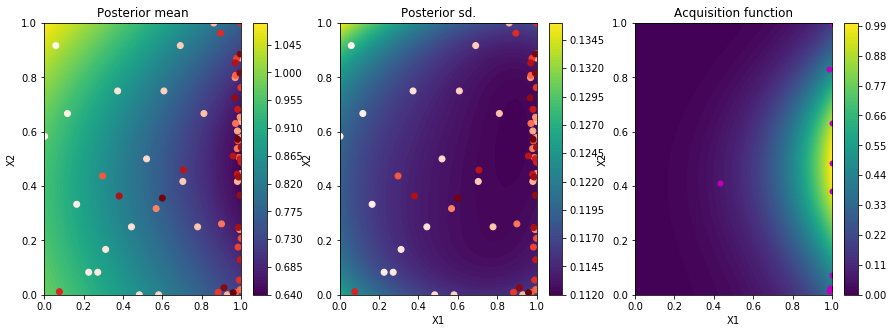

 Regular BO Batch Update 7 


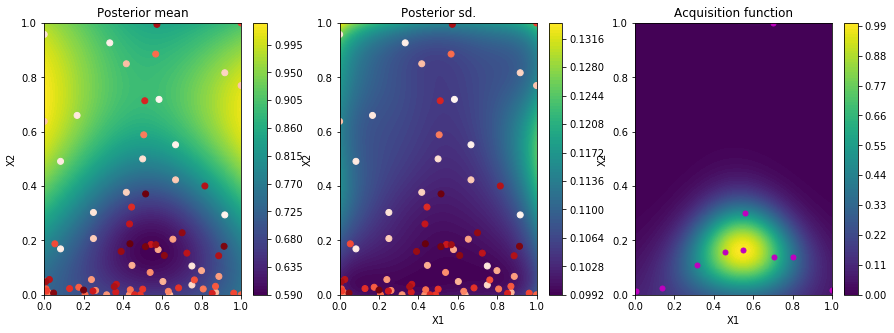

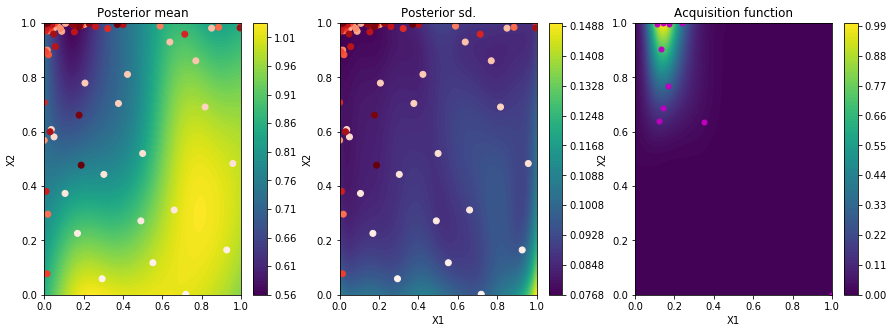

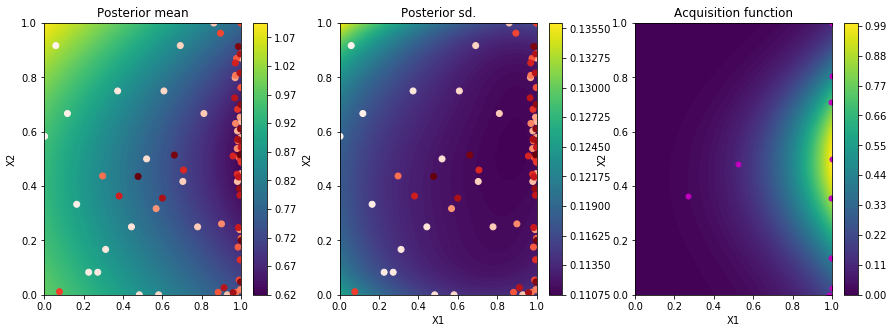

 Regular BO Batch Update 8 


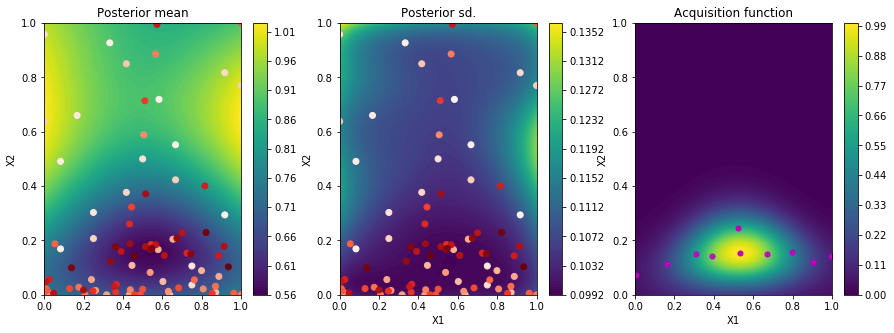

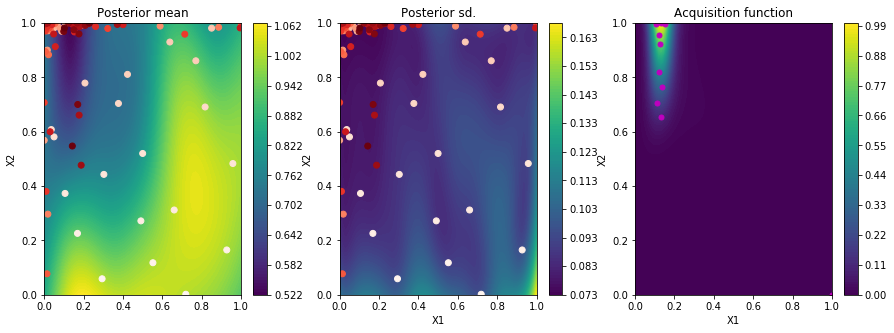

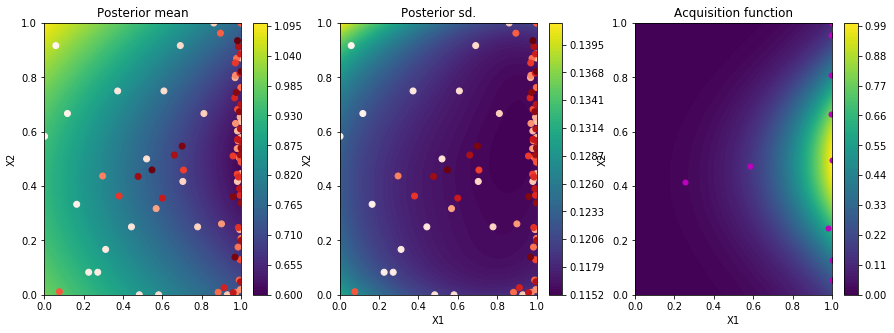

 Regular BO Batch Update 9 


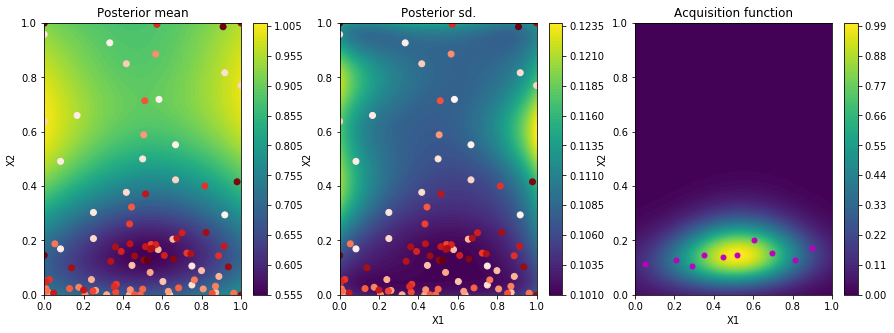

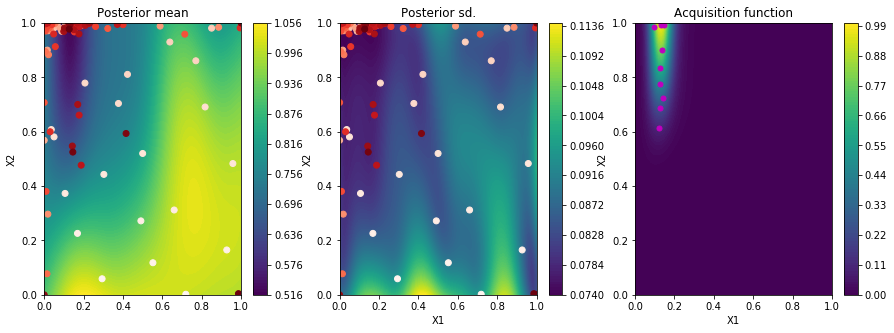

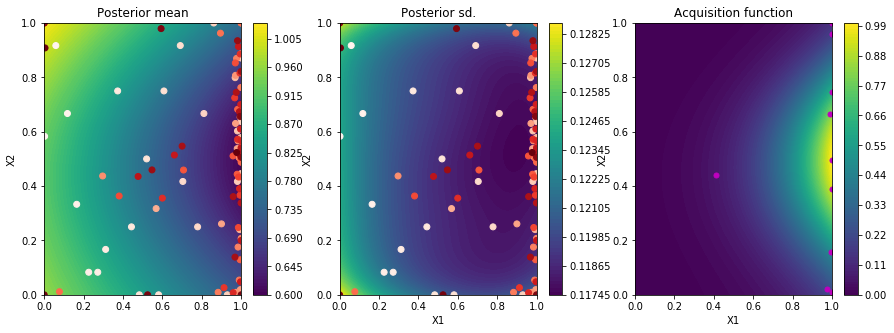

 Regular BO Batch Update 10 


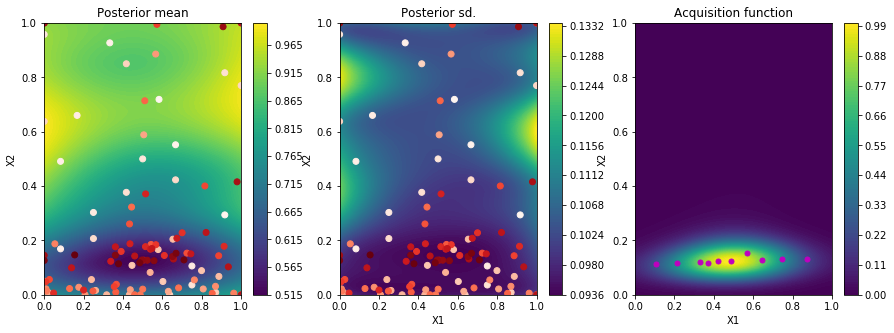

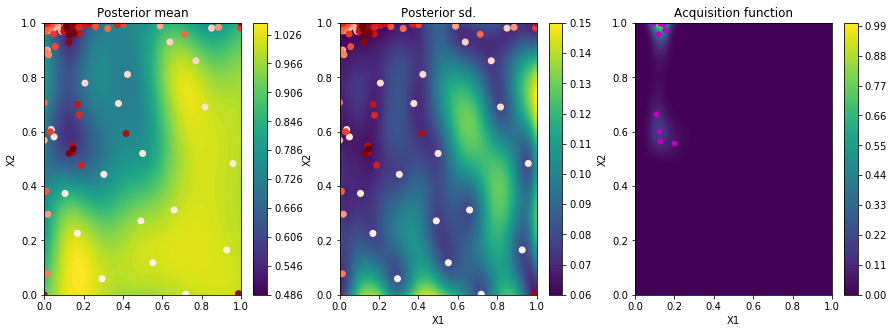

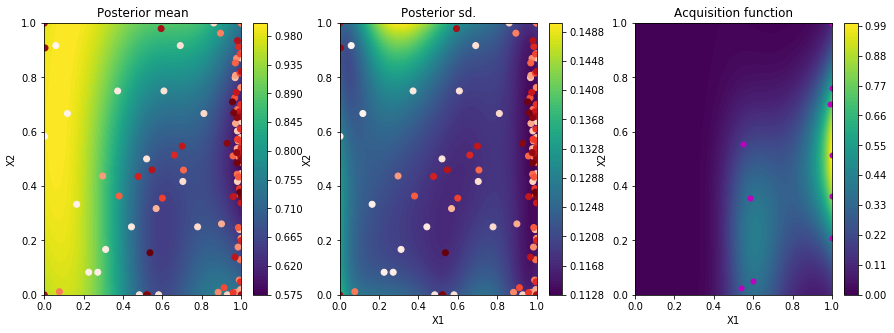

In [39]:
# Begin loop
# assign variables
x_conds_reg=[x_conds[0]]
y_obj_reg=[y_obj[0]]
acq_2Ds_reg=[]
Xp = x_conds_reg[0][:,0] # pressure
Xf = x_conds_reg[0][:,1] # frequency
Xs = x_conds_reg[0][:,2] # speed
Yo = y_obj_reg[0] # objective value
for i in range(10):
    print('','='*30,'\n Regular BO Batch Update '+str(i+1),'\n','='*30)
    # ==================================================================================
    # Run BO batch
    acq_2Ds_reg.append(output_acquisition_reg(x_conds=np.array([Xp,Xf,Xs]).T, y_conds=Yo.reshape(len(Yo),1))) # get 2D acquisition slices soley for plotting cubes
    x_conds_reg.append(run_BO_reg(x_conds=np.array([Xp,Xf,Xs]).T, y_conds=Yo.reshape(len(Yo),1))) # get new x-condition optima
    # ==================================================================================
    # get interpolation field of objective value and droplet counts
    y_obj_reg.append(interp_values(x_predict = x_conds_reg[i+1].T, y_all = Y_obj, x_all = XS)) # use first batch after initilization
    # assign variables
    Xp = np.concatenate((Xp, x_conds_reg[i+1][:,0])) # pressure
    Xf = np.concatenate((Xf, x_conds_reg[i+1][:,1])) # frequency
    Xs = np.concatenate((Xs, x_conds_reg[i+1][:,2])) # speed
    Yo = np.concatenate((Yo, y_obj_reg[i+1])) # objective value

# Plotting

In [16]:
# save figures to this directory
impath='C:/Users/alexs/Dropbox (MIT)/Buonassisi-Group/ASD Team/Learning_constraints/07_Figure_Graphs/Working_Folder/'

In [40]:
Y_OBJ = y_obj[0]
Y_OBJ_R = y_obj_reg[0]
# unravel the appended lists
for i in range(len(y_obj)-1):
    Y_OBJ = np.concatenate((Y_OBJ,y_obj[i+1]))
    Y_OBJ_R = np.concatenate((Y_OBJ_R,y_obj_reg[i+1]))
# get running minimum
run_min_constr=[1]
run_min_reg=[1]
for i in range(len(Y_OBJ)):
    # constraint function running minimum
    if Y_OBJ[i] <= run_min_constr[i]:
        run_min_constr.append(Y_OBJ[i])
    else:
        run_min_constr.append(run_min_constr[i])
    # regular BO running minimum
    if Y_OBJ_R[i] <= run_min_reg[i]:
        run_min_reg.append(Y_OBJ_R[i])
    else:
        run_min_reg.append(run_min_reg[i])

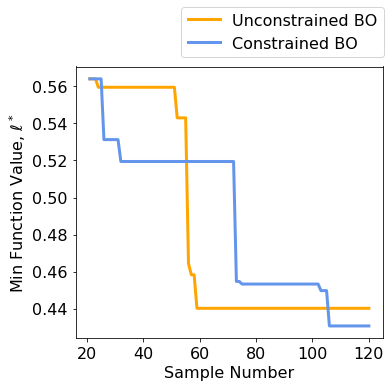

In [20]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5.5,5))
x_plot = np.arange(1,len(Y_OBJ)+1,1)
plt.plot(x_plot[20:],run_min_reg[21:],color='orange',linewidth=3,label='Unconstrained BO')
plt.plot(x_plot[20:],run_min_constr[21:],color='cornflowerblue',linewidth=3, label='Constrained BO')

plt.legend(prop={'size':16},bbox_to_anchor=(1.03, 1.25))
plt.ylabel('Min Function Value, $\ell^*$',fontsize=16)
plt.xlabel('Sample Number',fontsize=16)
ax.tick_params(axis='x',labelsize=16,pad=5)
ax.tick_params(axis='y',labelsize=16,pad=5)
# plt.savefig(impath+'minfunc_rerun3_R1.png',dpi=300,bbox_inches='tight')

In [21]:
csvpath='C:/Users/alexs/Dropbox (MIT)/Buonassisi-Group/ASD Team/Archerfish/05_Data/Imaged_droplets/Constraint_function_runs/'
# np.savetxt(csvpath+'constrained_rerun3.csv',run_min_constr,delimiter=',')
# np.savetxt(csvpath+'unconstrained_rerun3.csv',run_min_reg,delimiter=',')
print('constrained',run_min_constr)
print('\n unconstrained', run_min_reg)

constrained [1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.717, 0.717, 0.717, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.5312367310965307, 0.5312367310965307, 0.5312367310965307, 0.5312367310965307, 0.5312367310965307, 0.5312367310965307, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.5194426021784532, 0.519

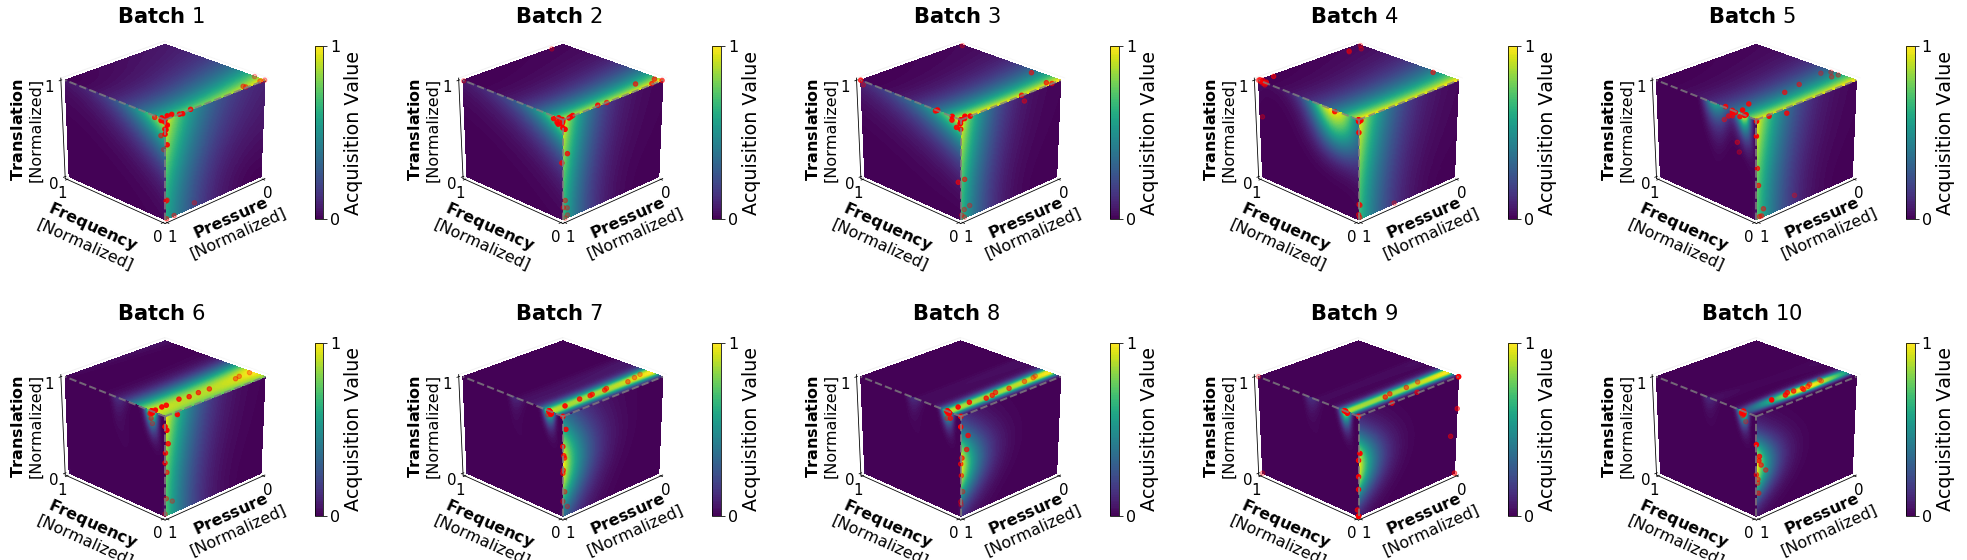

In [22]:
# Plot the constrained BO acquisition function
fs=16
fs1=15
fig,ax = plt.subplots(ncols=5,nrows=2,figsize=(35,10),)
plt.subplots_adjust(wspace=0.1)
for i in range(10):
    ii=i%5
    if i < 5:
        j=0
    else:
        j=1
    
    ax[j,ii].set_xticks([])
    ax[j,ii].set_yticks([])
    ax[j,ii].set_frame_on(False)
    # add axes
    ax[j,ii] = fig.add_subplot(2,5,1+i,projection='3d')
    ax[j,ii].plot([1,1],[0,1],[1,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)
    ax[j,ii].plot([1,0],[0,0],[1,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)
    ax[j,ii].plot([1,1],[0,0],[0,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)


    #     constraint=10
    #     surf_f0[surf_f0<constraint]=np.nan
    #     surf_f1[surf_f1<constraint]=np.nan
    #     surf_f2[surf_f2<constraint]=np.nan



    pl=ax[j,ii].contourf(XX, YY,acq_2Ds[i][0], 100,alpha=1,offset=1,zdir='z',zorder=0,cmap='viridis', antialiased=False) # pressure-frequency
    ax[j,ii].contourf(acq_2Ds[i][1], XX, YY, 100,alpha=1,offset=1,zdir='x',zorder=0,cmap='viridis', antialiased=False) # frequency-speed
    ax[j,ii].contourf(XX, acq_2Ds[i][2], YY, 100,alpha=1,offset=0,zdir='y',zorder=0,cmap='viridis', antialiased=False) # speed-pressure

    if i == 3:
        ax[j,ii].scatter(x_conds[i+1][:,0],1-x_conds[i+1][:,1],1,color='r') # plot p-f # there was an error
        ax[j,ii].scatter(1,1-x_conds[i+1][:,1],x_conds[i+1][:,2],color='r') # plot f-s # there was an error
        ax[j,ii].scatter(x_conds[i+1][:,2],0,x_conds[i+1][:,0],color='r') # plot s-p
    else:
        ax[j,ii].scatter(x_conds[i+1][:,0],x_conds[i+1][:,1],1,color='r') # plot p-f
        ax[j,ii].scatter(1,x_conds[i+1][:,1],x_conds[i+1][:,2],color='r') # plot f-s
        ax[j,ii].scatter(x_conds[i+1][:,2],0,x_conds[i+1][:,0],color='r') # plot s-p

#     ax.scatter(x_conds[i+1][:,0],x_conds[i+1][:,1],x_conds[i+1][:,2],color='r') # plot all

    ax[j,ii].grid(False)
    ax[j,ii].w_xaxis.pane.fill = False
    ax[j,ii].w_yaxis.pane.fill = False
    ax[j,ii].w_zaxis.pane.fill = False
    ax[j,ii].view_init(azim=45)
    ax[j,ii].set_xlabel(r'$\bf{Pressure}$'+'\n[Normalized]',fontsize=fs)
    ax[j,ii].set_ylabel(r'$\bf{Frequency}$'+'\n[Normalized]',fontsize=fs)
    ax[j,ii].zaxis.set_rotate_label(False)
    ax[j,ii].set_zlabel(r'$\bf{Translation}$'+'\n[Normalized]',rotation=90,fontsize=fs)
    ax[j,ii].set_title(r'$\bf{Batch}$ '+str(i+1),fontsize=fs+5)

    ax[j,ii].set_xticks([0,1])
    ax[j,ii].set_xlim([0,1])
    ax[j,ii].set_yticks([0,1])
    ax[j,ii].set_ylim([1,0])
    ax[j,ii].set_zticks([0,1])
    ax[j,ii].set_zlim([0,1])
    ax[j,ii].tick_params(axis='z',labelsize=fs1,pad=0)
    ax[j,ii].tick_params(axis='x',labelsize=fs1,pad=-1)
    ax[j,ii].tick_params(axis='y',labelsize=fs1,pad=-1)
    ax[j,ii].zaxis.labelpad = 5
    ax[j,ii].xaxis.labelpad = 4
    ax[j,ii].yaxis.labelpad = 14
    ax[j,ii].set_frame_on(False)
    ax[j,ii].dist=12


    cbar=plt.colorbar(pl,shrink=0.7,pad=0,ax=ax[j,ii])
    cbar.ax.tick_params(labelsize=fs) 
    cbar.set_ticks([0,1])
    cbar.set_label('Acquisition Value',size=fs+3)

# plt.savefig(impath+'constrained_BO_R2.png',dpi=300,bbox_inches='tight')

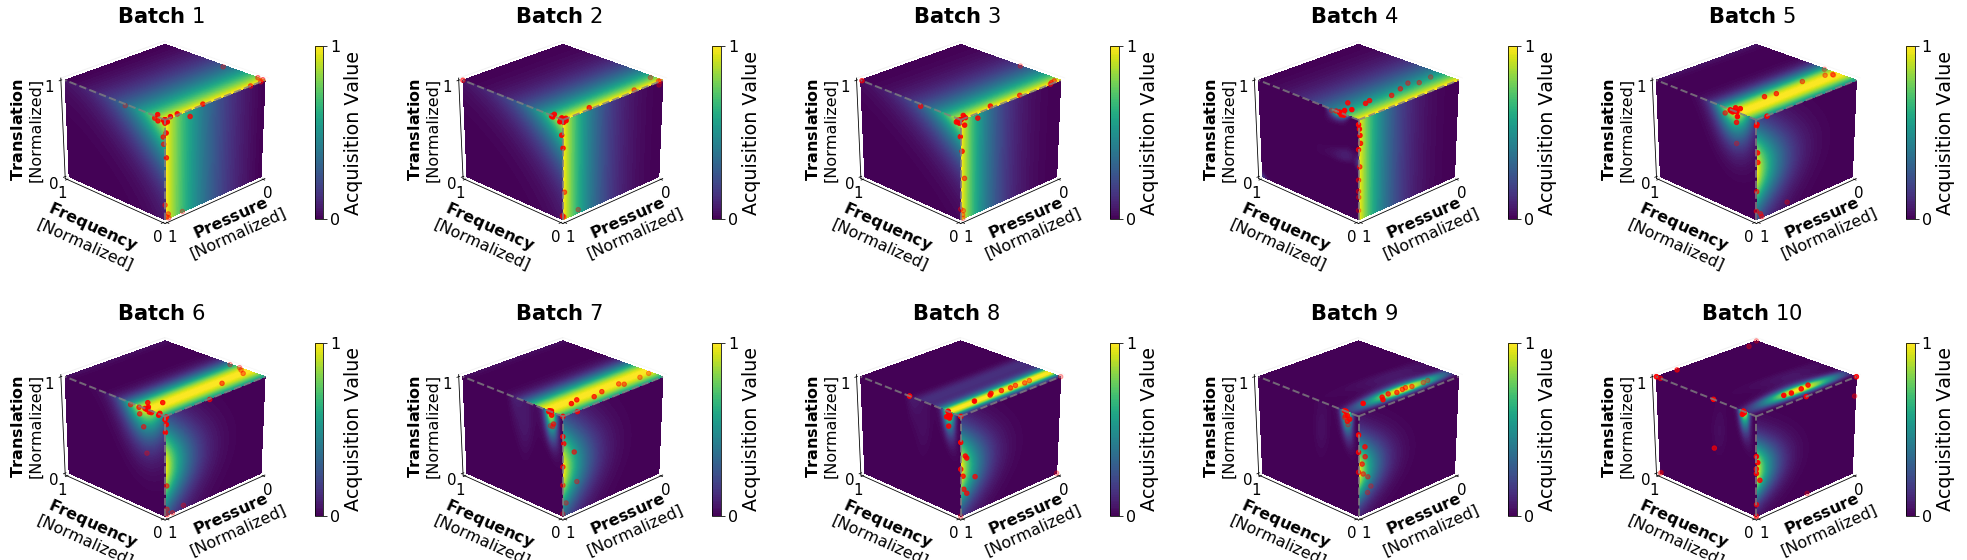

In [23]:
# Plot the unconstrained BO acquisition function
fs=16
fs1=15
fig,ax = plt.subplots(ncols=5,nrows=2,figsize=(35,10),)
plt.subplots_adjust(wspace=0.1)
for i in range(10):
    ii=i%5
    if i < 5:
        j=0
    else:
        j=1
    
    ax[j,ii].set_xticks([])
    ax[j,ii].set_yticks([])
    ax[j,ii].set_frame_on(False)
    # add axes
    ax[j,ii] = fig.add_subplot(2,5,1+i,projection='3d')
    ax[j,ii].plot([1,1],[0,1],[1,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)
    ax[j,ii].plot([1,0],[0,0],[1,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)
    ax[j,ii].plot([1,1],[0,0],[0,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)

    pl=ax[j,ii].contourf(XX, YY,acq_2Ds_reg[i][0], 100,alpha=1,offset=1,zdir='z',zorder=0,cmap='viridis', antialiased=False) # pressure-frequency
    ax[j,ii].contourf(acq_2Ds_reg[i][1], XX, YY, 100,alpha=1,offset=1,zdir='x',zorder=0,cmap='viridis', antialiased=False) # frequency-speed
    ax[j,ii].contourf(XX, acq_2Ds_reg[i][2], YY, 100,alpha=1,offset=0,zdir='y',zorder=0,cmap='viridis', antialiased=False) # speed-pressure


    ax[j,ii].scatter(x_conds_reg[i+1][:,0],x_conds_reg[i+1][:,1],1,color='r') # plot p-f
    ax[j,ii].scatter(1,x_conds_reg[i+1][:,1],x_conds_reg[i+1][:,2],color='r') # plot f-s
    ax[j,ii].scatter(x_conds_reg[i+1][:,2],0,x_conds_reg[i+1][:,0],color='r') # plot s-p

#     ax.scatter(x_conds[i+1][:,0],x_conds[i+1][:,1],x_conds[i+1][:,2],color='r') # plot all

    ax[j,ii].grid(False)
    ax[j,ii].w_xaxis.pane.fill = False
    ax[j,ii].w_yaxis.pane.fill = False
    ax[j,ii].w_zaxis.pane.fill = False
    ax[j,ii].view_init(azim=45)
    ax[j,ii].set_xlabel(r'$\bf{Pressure}$'+'\n[Normalized]',fontsize=fs)
    ax[j,ii].set_ylabel(r'$\bf{Frequency}$'+'\n[Normalized]',fontsize=fs)
    ax[j,ii].zaxis.set_rotate_label(False)
    ax[j,ii].set_zlabel(r'$\bf{Translation}$'+'\n[Normalized]',rotation=90,fontsize=fs)
    ax[j,ii].set_title(r'$\bf{Batch}$ '+str(i+1),fontsize=fs+5)

    ax[j,ii].set_xticks([0,1])
    ax[j,ii].set_xlim([0,1])
    ax[j,ii].set_yticks([0,1])
    ax[j,ii].set_ylim([1,0])
    ax[j,ii].set_zticks([0,1])
    ax[j,ii].set_zlim([0,1])
    ax[j,ii].tick_params(axis='z',labelsize=fs1,pad=0)
    ax[j,ii].tick_params(axis='x',labelsize=fs1,pad=-1)
    ax[j,ii].tick_params(axis='y',labelsize=fs1,pad=-1)
    ax[j,ii].zaxis.labelpad = 5
    ax[j,ii].xaxis.labelpad = 4
    ax[j,ii].yaxis.labelpad = 14
    ax[j,ii].set_frame_on(False)
    ax[j,ii].dist=12


    cbar=plt.colorbar(pl,shrink=0.7,pad=0,ax=ax[j,ii])
    cbar.ax.tick_params(labelsize=fs) 
    cbar.set_ticks([0,1])
    cbar.set_label('Acquisition Value',size=fs+3)

# plt.savefig(impath+'unconstrained_BO_R1.png',dpi=300,bbox_inches='tight')

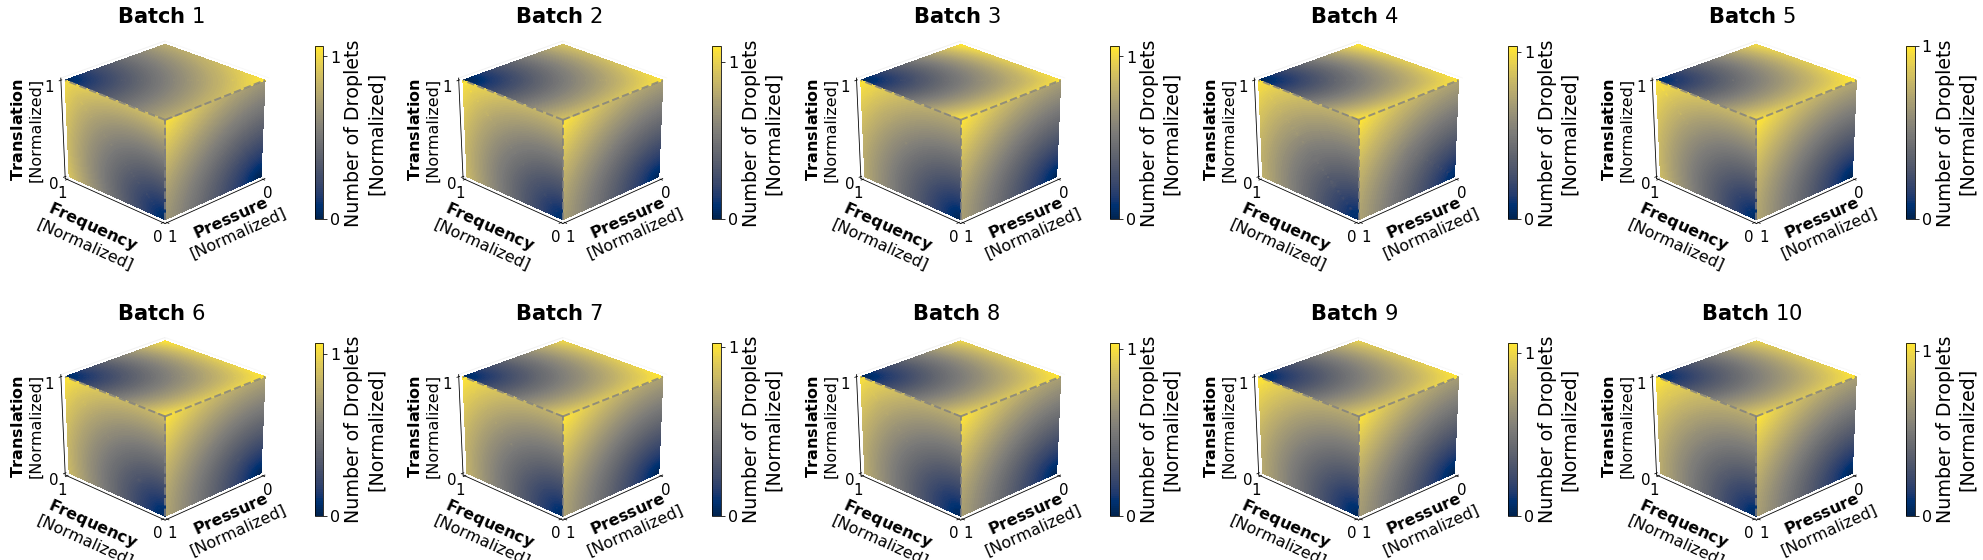

In [24]:
# Plot the number of droplets
fs=16
fs1=15
fig,ax = plt.subplots(ncols=5,nrows=2,figsize=(35,10),)
plt.subplots_adjust(wspace=0.1)
for i in range(10):
    ii=i%5
    if i < 5:
        j=0
    else:
        j=1
    
    ax[j,ii].set_xticks([])
    ax[j,ii].set_yticks([])
    ax[j,ii].set_frame_on(False)
    # add axes
    ax[j,ii] = fig.add_subplot(2,5,1+i,projection='3d')
    ax[j,ii].plot([1,1],[0,1],[1,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)
    ax[j,ii].plot([1,0],[0,0],[1,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)
    ax[j,ii].plot([1,1],[0,0],[0,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)

    pl=ax[j,ii].contourf(XX, YY,dropnum_2Ds[i][0], 100,alpha=1,offset=1,zdir='z',zorder=0,cmap='cividis', antialiased=False) # pressure-frequency
    ax[j,ii].contourf(dropnum_2Ds[i][1], XX, YY, 100,alpha=1,offset=1,zdir='x',zorder=0,cmap='cividis', antialiased=False) # frequency-speed
    ax[j,ii].contourf(XX, dropnum_2Ds[i][2], YY, 100,alpha=1,offset=0,zdir='y',zorder=0,cmap='cividis', antialiased=False) # speed-pressure

    ax[j,ii].grid(False)
    ax[j,ii].w_xaxis.pane.fill = False
    ax[j,ii].w_yaxis.pane.fill = False
    ax[j,ii].w_zaxis.pane.fill = False
    ax[j,ii].view_init(azim=45)
    ax[j,ii].set_xlabel(r'$\bf{Pressure}$'+'\n[Normalized]',fontsize=fs)
    ax[j,ii].set_ylabel(r'$\bf{Frequency}$'+'\n[Normalized]',fontsize=fs)
    ax[j,ii].zaxis.set_rotate_label(False)
    ax[j,ii].set_zlabel(r'$\bf{Translation}$'+'\n[Normalized]',rotation=90,fontsize=fs)
    ax[j,ii].set_title(r'$\bf{Batch}$ '+str(i+1),fontsize=fs+5)

    ax[j,ii].set_xticks([0,1])
    ax[j,ii].set_xlim([0,1])
    ax[j,ii].set_yticks([0,1])
    ax[j,ii].set_ylim([1,0])
    ax[j,ii].set_zticks([0,1])
    ax[j,ii].set_zlim([0,1])
    ax[j,ii].tick_params(axis='z',labelsize=fs1,pad=0)
    ax[j,ii].tick_params(axis='x',labelsize=fs1,pad=-1)
    ax[j,ii].tick_params(axis='y',labelsize=fs1,pad=-1)
    ax[j,ii].zaxis.labelpad = 5
    ax[j,ii].xaxis.labelpad = 4
    ax[j,ii].yaxis.labelpad = 14
    ax[j,ii].set_frame_on(False)
    ax[j,ii].dist=12


    cbar=plt.colorbar(pl,shrink=0.7,pad=0,ax=ax[j,ii])
    cbar.ax.tick_params(labelsize=fs) 
    aa=cbar.get_ticks()
    cbar.set_ticks([aa[0],aa[len(aa)-1]])
    cbar.ax.set_yticklabels([0,1])
    cbar.set_label('Number of Droplets\n[Normalized]',size=fs+3)

# plt.savefig(impath+'num_droplets_BO_R1.png',dpi=300,bbox_inches='tight')

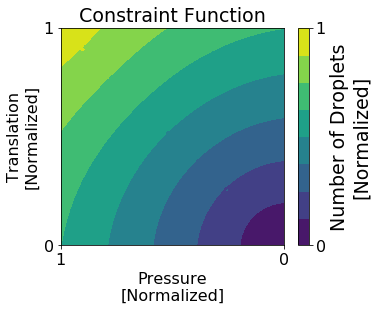

In [45]:
fs=16
fs1=15
fig,ax=plt.subplots(1,1,figsize=(5,4))
pl=ax.contourf(XX, YY,dropnum_2Ds[0][2],alpha=1,cmap='viridis', antialiased=False) # pressure-frequency
cbar=plt.colorbar(pl,shrink=1,pad=0.05)
cbar.ax.tick_params(labelsize=fs) 
aa=cbar.get_ticks()
cbar.set_ticks([aa[0],aa[len(aa)-1]])
cbar.ax.set_yticklabels([0,1])
cbar.set_label('Number of Droplets\n[Normalized]',size=fs+3)
ax.set_xticks([0,1])
ax.set_xlim([1,0])
ax.set_yticks([0,1])
ax.tick_params(axis='both',labelsize=fs)
ax.set_title('Constraint Function',fontsize=fs+3)
ax.set_xlabel('Pressure\n[Normalized]',fontsize=fs)
ax.set_ylabel('Translation\n[Normalized]',fontsize=fs)
# plt.savefig(impath+'constraint_func_R2.png',dpi=300,bbox_inches='tight')

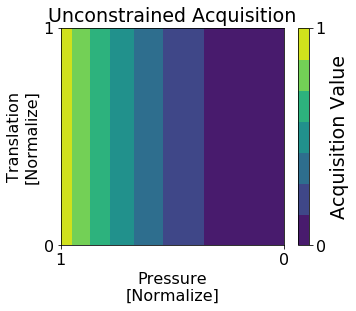

In [44]:
fig,ax=plt.subplots(1,1,figsize=(5,4))
pl=ax.contourf(XX,YY,acq_2Ds_reg[0][2],alpha=1,cmap='viridis', antialiased=False) # pressure-frequency
cbar=plt.colorbar(pl,shrink=1,pad=0.05)
cbar.ax.tick_params(labelsize=fs) 
aa=cbar.get_ticks()
cbar.set_ticks([aa[0],aa[len(aa)-1]])
cbar.ax.set_yticklabels([0,1])
cbar.set_label('Acquisition Value',size=fs+3)
ax.set_xticks([0,1])
ax.set_xlim([1,0])
ax.set_yticks([0,1])
ax.tick_params(axis='both',labelsize=fs)
ax.set_title('Unconstrained Acquisition',fontsize=fs+3)
ax.set_xlabel('Pressure\n[Normalize]',fontsize=fs)
ax.set_ylabel('Translation\n[Normalize]',fontsize=fs)
# plt.savefig(impath+'unconstrained_acq_R1.png',dpi=300,bbox_inches='tight')

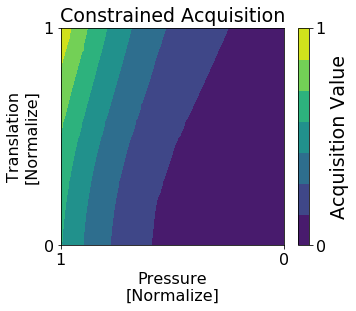

In [43]:
fig,ax=plt.subplots(1,1,figsize=(5,4))
pl=ax.contourf(XX,YY,acq_2Ds[0][2],alpha=1,cmap='viridis', antialiased=False) # pressure-frequency
cbar=plt.colorbar(pl,shrink=1,pad=0.05)
cbar.ax.tick_params(labelsize=fs) 
aa=cbar.get_ticks()
cbar.set_ticks([aa[0],aa[len(aa)-1]])
cbar.ax.set_yticklabels([0,1])
cbar.set_label('Acquisition Value',size=fs+3)
ax.set_xticks([0,1])
ax.set_xlim([1,0])
ax.set_yticks([0,1])
ax.tick_params(axis='both',labelsize=fs)
ax.set_title('Constrained Acquisition',fontsize=fs+3)
ax.set_xlabel('Pressure\n[Normalize]',fontsize=fs)
ax.set_ylabel('Translation\n[Normalize]',fontsize=fs)
# plt.savefig(impath+'constrained_acq_R1.png',dpi=300,bbox_inches='tight')

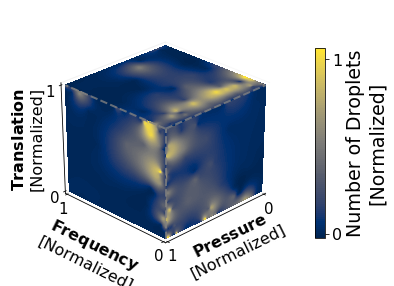

In [28]:
# plot the actual drop number
a,b,c=interp_field(x_conds=XS,y_conds=Y_cnt)
a=a(XX,YY)
b=b(XX,YY)
c=c(XX,YY)

fig,ax=plt.subplots(1,1,figsize=(6.5,5))
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
# add axes
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot([1,1],[0,1],[1,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)
ax.plot([1,0],[0,0],[1,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)
ax.plot([1,1],[0,0],[0,1],color='grey',zorder=1000,linestyle='--',alpha=0.8,linewidth=2)

pl=ax.contourf(XX, YY,a, 100,alpha=1,offset=1,zdir='z',zorder=0,cmap='cividis', antialiased=False) # pressure-frequency
ax.contourf(b, XX, YY, 100,alpha=1,offset=1,zdir='x',zorder=0,cmap='cividis', antialiased=False) # frequency-speed
ax.contourf(XX, c, YY, 100,alpha=1,offset=0,zdir='y',zorder=0,cmap='cividis', antialiased=False) # speed-pressure

ax.grid(False)
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.view_init(azim=45)
ax.set_xlabel(r'$\bf{Pressure}$'+'\n[Normalized]',fontsize=fs)
ax.set_ylabel(r'$\bf{Frequency}$'+'\n[Normalized]',fontsize=fs)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel(r'$\bf{Translation}$'+'\n[Normalized]',rotation=90,fontsize=fs)

ax.set_xticks([0,1])
ax.set_xlim([0,1])
ax.set_yticks([0,1])
ax.set_ylim([1,0])
ax.set_zticks([0,1])
ax.set_zlim([0,1])
ax.tick_params(axis='z',labelsize=fs1,pad=0)
ax.tick_params(axis='x',labelsize=fs1,pad=-1)
ax.tick_params(axis='y',labelsize=fs1,pad=-1)
ax.zaxis.labelpad = 5
ax.xaxis.labelpad = 4
ax.yaxis.labelpad = 14
ax.set_frame_on(False)
ax.dist=12


cbar=plt.colorbar(pl,shrink=0.7,pad=0)
cbar.ax.tick_params(labelsize=fs) 
aa=cbar.get_ticks()
cbar.set_ticks([aa[0],aa[len(aa)-1]])
cbar.ax.set_yticklabels([0,1])
cbar.set_label('Number of Droplets\n[Normalized]',size=fs+3)

# plt.savefig(impath+'actual_drop_num_R1.png',dpi=300,bbox_inches='tight')

Posterior distributions after 11 iterations.


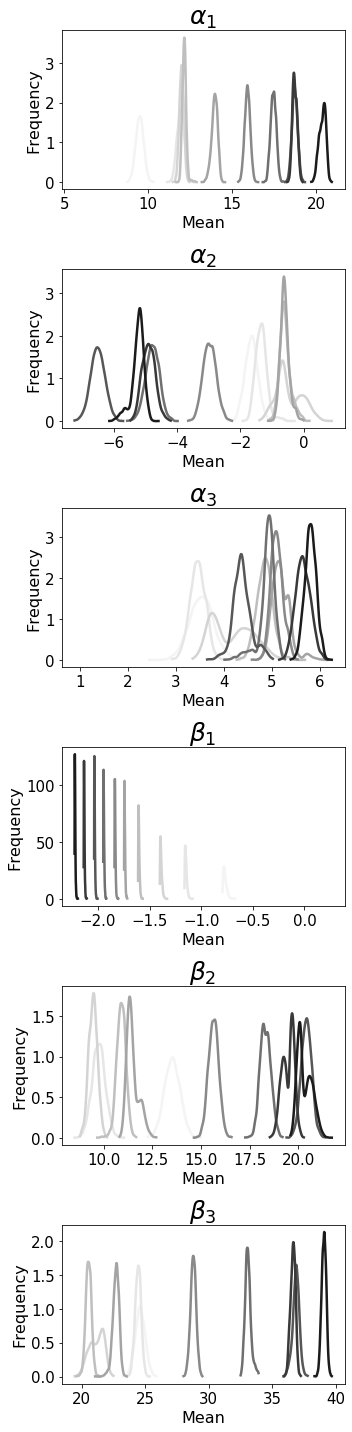

In [29]:
# plot posterior distributions of the priors after HMC sampling
print("Posterior distributions after " + str(len(traces)) + " iterations.")
import matplotlib as mpl
cmap = mpl.cm.Greys_r
fig,ax=plt.subplots(ncols=1,nrows=6,figsize=(5,20))
i=0    
parameters = [r'$\alpha_1$',r'$\alpha_2$',r'$\alpha_3$',r'$\beta_1$',r'$\beta_2$',r'$\beta_3$']
for param in ["alpha1", "alpha2", "alpha3", "beta1", "beta2",'beta3']:
    for update_i, trace in enumerate(traces):
        samples = trace[param]
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        ax[i].plot(x, y, color=cmap(1 - update_i / len(traces)),linewidth=2.5)
        ax[i].tick_params(axis='both',labelsize=15)
        ax[i].set_xlabel('Mean',fontsize=16)
        ax[i].set_ylabel('Frequency',fontsize=16)
        ax[i].set_title(parameters[i],fontsize=25)
    i+=1
plt.tight_layout()
# plt.savefig(impath+'prior_updates_R1.png',dpi=300,bbox_inches='tight')

# Run entire optimization as a batch process
Collect data on the running minimum objective value over all samples

*This code block is self-contained*

In [ ]:
# import packages
import numpy as np
import tensorflow as tf
import scipy # need scipy 1.4.1 to work with GPyOpt
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
import GPy
import GPyOpt_constraints
from GPyOpt_constraints.methods import BayesianOptimization
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
from pymc3 import Model, Normal, Slice, sample, traceplot
from pymc3.distributions import Interpolated
from scipy import stats
from theano import as_op
# path imports
path='C:/Users/alexs/Dropbox (MIT)/Buonassisi-Group/ASD Team/Archerfish/05_Data/Imaged_droplets/'
impath='C:/Users/alexs/Dropbox (MIT)/Buonassisi-Group/ASD Team/Archerfish/07_Figure_Graphs/Working_Folder/'
csvpath='C:/Users/alexs/Dropbox (MIT)/Buonassisi-Group/ASD Team/Archerfish/05_Data/Imaged_droplets/Constraint_function_runs/'
EI_drop_num=np.genfromtxt(path+'Dye_Set_EI_1/EI_drop_number.csv',delimiter=',')
MPI_drop_num=np.genfromtxt(path+'Dye_Set_MPI_1/MPI_drop_number.csv',delimiter=',')
LCB_drop_num=np.genfromtxt(path+'Dye_Set_LCB_1/LCB_drop_number.csv',delimiter=',')
drop_cat=np.concatenate((EI_drop_num,MPI_drop_num[20:],LCB_drop_num[20:]),axis=0)
drop_num=EI_drop_num # EI maps the cumulative of all 3 best. Plus EI has higher max droplet count than MPI (50 vs 30)
# grab all conditions + objective value + drop number
bo_full=pd.read_csv(path+'bo_full.csv',delimiter=',')
bo_full['DropCount']=drop_cat[:,3]
# create interpolation field and avoid singular matrix by removing repeating points
def interp_field(y_conds,x_conds):
    '''
    Inputs:
    xy_conds:=   Dx4 data array where the first 3 columns are pressure, frequency, speed 
                 and the 4th column are the y-values
    '''
    for n in range(3):
        cv_x_temp0=np.copy(x_conds[:,n])
        cv_x_temp1=np.copy(x_conds[:,(n+1)%3])
        cv_y_temp=np.copy(y_conds) # y condition
        for i in range(x_conds.shape[0]):
            for j in range(x_conds.shape[0]):
                if cv_x_temp0[i]==cv_x_temp0[j] and cv_x_temp1[i]==cv_x_temp1[j] and i!=j:
                    if cv_y_temp[i] < cv_y_temp[j]: # want to remove failed prints over good prints
                        cv_x_temp0[j]=np.nan
                        cv_x_temp1[j]=np.nan
                        cv_y_temp[j]=np.nan
                    else:
                        cv_x_temp0[i]=np.nan
                        cv_x_temp1[i]=np.nan
                        cv_y_temp[i]=np.nan
        cv_x_temp0=cv_x_temp0[~np.isnan(cv_x_temp0)]
        cv_x_temp1=cv_x_temp1[~np.isnan(cv_x_temp1)]
        cv_y_temp=cv_y_temp[~np.isnan(cv_y_temp)]
        globals()['rbf_'+str(n)]=Rbf(cv_x_temp0,cv_x_temp1,cv_y_temp,function='linear')
    return rbf_0, rbf_1, rbf_2
def interp_values(x_predict,y_all,x_all):
    '''
    x_predict :=    [x1,x2,x3] conditions to predict an output value
    y_all     :=    1D array of values to interpolate
    x_all     :=    Nx3 arry of conditions to use to interpolate y_all
    '''
    rbf_0,rbf_1,rbf_2=interp_field(y_conds=y_all,x_conds=x_all) # get interpolation fields in 2D slice
    val=np.array([rbf_0(x_predict[0],x_predict[1]),rbf_1(x_predict[1],x_predict[2]),rbf_2(x_predict[2],x_predict[0])]) # predict
    val = np.mean(val, axis = 0) # linearly interpolate predicted values
    val[val < 0.] = 0. # set all negative values equal to 0
    return val
# normalization function
def normalize_it(array):
    return (array - np.min(array))/((np.max(array-np.min(array))))
# output acquisition function 2D slices to augment with constraint funciton
def output_acquisition(x_conds,y_conds,constraint_function):
    '''
    Output the aquisition function so it can be augmented by the constraint function
    
    Inputs:
    x_conds             := input condition matrix (n by 3) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
    constraint_function := is a (3,100,100) array of constraint values
      
    Ouputs:
    list                := a list of 3 acquisition function value 2D slices
    '''
        
    # re-run BO in 2D slices to get acquisition value fields for plotting
    aq_bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)},
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
          ]
    for n in range(3):
        aq_kernel = GPy.kern.Matern52(input_dim=len(aq_bds), ARD = True)
        acq_2D = BayesianOptimization(f=None, 
                                         domain=aq_bds,
                                         constraints = None,
                                         model_type='GP',
                                         constraint_function=constraint_function[n,:,:],
                                         acquisition_type ='constrained_EI',
                                         X=x_conds[:,[n,(n+1)%3]],
                                         Y=y_conds,
                                         evaluator_type = 'local_penalization',
                                         batch_size = 10,
                                         normalize_Y= False,
                                         #noise_var = 0.02**2,
                                         kernel = aq_kernel
                                         )
        globals()['acq_slice'+str(n)]=acq_2D.plot_acquisition()
        
    return [acq_slice0,acq_slice1,acq_slice2]
# run BO using the constrained acquisition function
def run_BO(x_conds,y_conds,constraint_function):
    '''
    Implement Bayesian optimization.
    
    ** constraint_function must be a numpy array of shape (3,100,100) for 3D using three 2D surfaces
        and (100,100) for 2D.
    
    Uses the expected improvement (EI) acquisition with local penalization and Matern5/2-ARD kernel.
    Generates a batch size of 10 suggested conditions. 
    
    Inputs:
    x_conds             := input condition matrix (n by 3) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
    constraint_function := is a (3,100,100) array of constraint values
      
    Ouputs:
    x_next              := suggested next x-conditions to sample from
    '''
    # run BO on the x-conditions conditions and their respective y-values
    bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)}, # 3D bounds
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
           {'name': 'x3', 'type': 'continuous', 'domain': (0, 1)},
          ]
    kernel = GPy.kern.Matern52(input_dim=len(bds), ARD = True) # Use the matern 5/2 kernel with automatic relevence detection enabled
    BO_opt = BayesianOptimization(f=None, 
                                     domain=bds,
                                     constraints = None,
                                     model_type='GP', # gaussian process model
                                     constraint_function=constraint_function, # must be a numpy array of three 2D surfaces with shape (3,100,100)
                                     acquisition_type ='constrained_EI',
                                     X=x_conds, # input data
                                     Y=y_conds, # associated labels
                                     evaluator_type = 'local_penalization',
                                     batch_size = 10, # batch size of predicted optima
                                     normalize_Y= False,
                                     kernel = kernel # select the kernel
                                     )
    x_next = BO_opt.suggest_next_locations()
    return x_next
# create new prior from the previous posteriors by interpolating the distributions
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)
# output acquisition function 2D slices to augment with constraint funciton
def output_acquisition_reg(x_conds,y_conds):
    '''
    Output the aquisition function
    
    Inputs:
    x_conds             := input condition matrix (n by 3) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
      
    Ouputs:
    list                := a list of 3 acquisition function value 2D slices
    '''
        
    # re-run BO in 2D slices to get acquisition value fields for plotting
    aq_bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)},
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
          ]
    for n in range(3):
        aq_kernel = GPy.kern.Matern52(input_dim=len(aq_bds), ARD = True)
        acq_2D = BayesianOptimization(f=None, 
                                         domain=aq_bds,
                                         constraints = None,
                                         model_type='GP',
                                         acquisition_type ='EI',
                                         X=x_conds[:,[n,(n+1)%3]],
                                         Y=y_conds,
                                         evaluator_type = 'local_penalization',
                                         batch_size = 10,
                                         normalize_Y= False,
                                         #noise_var = 0.02**2,
                                         kernel = aq_kernel
                                         )
        globals()['acq_slice'+str(n)]=acq_2D.plot_acquisition()
        
    return [acq_slice0,acq_slice1,acq_slice2]
# run BO using the constrained acquisition function
def run_BO_reg(x_conds,y_conds):
    '''
    Implement Bayesian optimization.
    
    Uses the expected improvement (EI) acquisition with local penalization and Matern5/2-ARD kernel.
    Generates a batch size of 10 suggested conditions. 
    
    Inputs:
    x_conds             := input condition matrix (n by 3) where n is the initialized batch size
    y_conds             := column vector of labels (n by 1)
      
    Ouputs:
    x_next              := suggested next x-conditions to sample from
    '''
    # run BO on the x-conditions conditions and their respective y-values
    bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)}, # 3D bounds
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
           {'name': 'x3', 'type': 'continuous', 'domain': (0, 1)},
          ]
    kernel = GPy.kern.Matern52(input_dim=len(bds), ARD = True) # Use the matern 5/2 kernel with automatic relevence detection enabled
    BO_opt = BayesianOptimization(f=None, 
                                     domain=bds,
                                     constraints = None,
                                     model_type='GP', # gaussian process model
                                     acquisition_type ='EI',
                                     X=x_conds, # input data
                                     Y=y_conds, # associated labels
                                     evaluator_type = 'local_penalization',
                                     batch_size = 10, # batch size of predicted optima
                                     normalize_Y= False,
                                     kernel = kernel # select the kernel
                                     )
    x_next = BO_opt.suggest_next_locations()
    return x_next
# Grab initialization data only
output_obj=np.array(bo_full['Objective'][:20]) # objective value
output_drops=np.array(bo_full['DropCount'][:20]) # number of droplets
pressure=np.array(bo_full['Pressure'][:20])
frequency=np.array(bo_full['Frequency'][:20])
speed=np.array(bo_full['Speed'][:20])
# start conditions lists
x_conds = [np.array([pressure,frequency,speed]).T] # X conditions
# get meshgrid for plotting
xx, yy = [np.linspace(0,1,100),np.linspace(0,1,100)] # MESH SIZE MUST BE 100X100 IN ORDER FOR CONSTRAINT FUNCTION TO WORK IN BO LOOP
XX, YY = np.meshgrid (xx,yy)
# BEGIN LOOP
for T in range(100):
    print('-------- ITERATION #'+str(T+1)+' --------')
    y_obj = [output_obj] # Objective values
    y_cnt = [output_drops] # Number of droplets
    # initialize model priors
    traces = [] # create list to append traces of priors
    init_model = Model()
    with init_model:
        # Priors for unknown model parameters
        alpha1 = pm.Normal("alpha1", mu=0, sigma=1)
        alpha2 = pm.Normal("alpha2", mu=0, sigma=1)
        alpha3 = pm.Normal("alpha3", mu=0, sigma=1)
        beta1 = pm.Gamma("beta1", alpha=0.7, beta=0.5)
        beta2 = pm.Gamma("beta2", alpha=0.7, beta=0.5)
        beta3 = pm.Gamma("beta3", alpha=0.7, beta=0.5)

        # Expected value of outcome
        mu1 = alpha1 + beta1 * pressure + beta2 * (0.7-frequency) # pressure-frequency
        mu2 = alpha2 + beta2 * (0.7-frequency) + beta3 * (speed-0.2) # frequency-speed
        mu3 = alpha3 + beta3 * (speed-0.2) + beta1 * pressure # speed-pressure

        # Likelihood (sampling distribution) of observations
        Y1_pressure_frequency = Normal("Y1_pressure_frequency", mu = mu1, sigma=1, observed=y_cnt[0])
        Y1_frequency_speed = Normal("Y1_frequency_speed", mu = mu2, sigma=1, observed=y_cnt[0])
        Y1_speed_pressure = Normal("Y1_speed_pressure", mu = mu3, sigma=1, observed=y_cnt[0])

        # draw 1000 posterior samples using HMC
        trace = sample(1000)
        traces.append(trace)
        
    # compute simulated droplet numbers for each 2D slice
    X_sim=np.linspace(0,1,len(trace['alpha1']))
    Y_pf = trace['alpha1']+trace['beta1']*X_sim+trace['beta2']*(0.7-X_sim)
    # Y_pf_norm = normalize_it(Y_pressure_frequency) # normalize
    Y_fs = trace['alpha2']+trace['beta2']*(0.7-X_sim)+trace['beta3']*(X_sim-0.2)
    # Y_fs_norm = normalize_it(Y_frequency_speed) # normalize
    Y_sp = trace['alpha3']+trace['beta1']*X_sim+trace['beta3']*(X_sim-0.2)
    # Y_sp_norm = normalize_it(Y_speed_pressure) # normalize

    # run interpolation
    dropnum_2Ds=[]
    # pressure-frequency
    rbf_pf=Rbf(X_sim,X_sim,Y_pf,function='linear')
    surf_f0=rbf_pf(XX,YY)
    # frequency-speed
    rbf_fs=Rbf(X_sim,X_sim,Y_fs,function='linear')
    surf_f1=rbf_fs(XX,YY)
    # speed-pressure
    rbf_sp=Rbf(X_sim,X_sim,Y_sp,function='linear')
    surf_f2=rbf_sp(XX,YY)
    max_norm = np.max([surf_f0,surf_f1,surf_f2])
    dropnum_2Ds.append(np.array([surf_f0/max_norm,surf_f1/max_norm,surf_f2/max_norm]))
    
    # RUN BO and get the new 10 output conditions using the the 20 LHS initialized conditions, objective values, and constraints
    acq_2Ds=[] # list of acquisition function spaces
    acq_2Ds.append(output_acquisition(x_conds=x_conds[0], y_conds=y_obj[0].reshape(len(y_obj[0]),1), constraint_function = dropnum_2Ds[0]))
    x_conds.append(run_BO(x_conds=x_conds[0], y_conds=y_obj[0].reshape(len(y_obj[0]),1), constraint_function = dropnum_2Ds[0]))
    
    # all condition values
    XS=np.array(bo_full[['Pressure','Frequency','Speed']])
    Y_obj=np.array(bo_full['Objective'])
    Y_cnt=np.array(bo_full['DropCount'])
    # Begin loop
    # assign variables
    Xp = x_conds[0][:,0] # pressure
    Xf = x_conds[0][:,1] # frequency
    Xs = x_conds[0][:,2] # speed
    Yo = y_obj[0] # objective value
    Yc = y_cnt[0] # droplet count
    for i in range(10):
        print('','='*30,'\n BO + Constraints Batch Update '+str(i+1),'\n','='*30)
        # ==================================================================================
        # get interpolation field of objective value and droplet counts
        y_obj.append(interp_values(x_predict = x_conds[i+1].T, y_all = Y_obj, x_all = XS)) # use first batch after initilization
        y_cnt.append(interp_values(x_predict = x_conds[i+1].T, y_all = Y_cnt, x_all = XS)) # use first batch after initilization
        # assign variables from first update
        Xp = np.concatenate((Xp, x_conds[i+1][:,0])) # pressure
        Xf = np.concatenate((Xf, x_conds[i+1][:,1])) # frequency
        Xs = np.concatenate((Xs, x_conds[i+1][:,2])) # speed
        Yo = np.concatenate((Yo, y_obj[i+1])) # objective value
        Yc = np.concatenate((Yc, y_cnt[i+1])) # droplet count
        # ==================================================================================
        # get new HMC estimations of droplet count priors to learn the constraint with the new y_cnt data from previous batch
        update_model = Model()
        with update_model:
            # Priors are posteriors from previous iteration
            alpha1 = from_posterior("alpha1", traces[i]["alpha1"])
            alpha2 = from_posterior("alpha2", traces[i]["alpha2"])
            alpha3 = from_posterior("alpha3", traces[i]["alpha3"])
            beta1 = from_posterior("beta1", traces[i]["beta1"])
            beta2 = from_posterior("beta2", traces[i]["beta2"])
            beta3 = from_posterior("beta3", traces[i]["beta3"])

            # Expected value of outcome
            mu1 = alpha1 + beta1 * Xp + beta2 * (0.7-Xf) # pressure-frequency
            mu2 = alpha2 + beta2 * (0.7-Xf) + beta3 * (Xs-0.2) # frequency-speed
            mu3 = alpha3 + beta3 * (Xs-0.2) + beta1 * Xp # speed-pressure

            # Likelihood (sampling distribution) of observations
            Y1_pressure_frequency = Normal("Y1_pressure_frequency", mu = mu1, sigma=1, observed=Yc) # observed droplet count
            Y1_frequency_speed = Normal("Y1_frequency_speed", mu = mu2, sigma=1, observed=Yc) # observed droplet count
            Y1_speed_pressure = Normal("Y1_speed_pressure", mu = mu3, sigma=1, observed=Yc) # observed droplet count

            # draw 10000 posterior samples
            trace = sample(1000)
            traces.append(trace)
        # ==================================================================================
        # compute simulated droplet numbers for each 2D slice
        Y_pf = traces[i+1]['alpha1']+traces[i+1]['beta1']*X_sim+traces[i+1]['beta2']*(0.7-X_sim)
    #     Y_pf_norm = normalize_it(Y_pressure_frequency)
        Y_fs = traces[i+1]['alpha2']+traces[i+1]['beta2']*(0.7-X_sim)+traces[i+1]['beta3']*(X_sim-0.2)
    #     Y_fs_norm = normalize_it(Y_frequency_speed)
        Y_sp = traces[i+1]['alpha3']+traces[i+1]['beta1']*X_sim+traces[i+1]['beta3']*(X_sim-0.2)
    #     Y_sp_norm = normalize_it(Y_speed_pressure)
        # run interpolation
        # pressure-frequency
        rbf_pf=Rbf(X_sim,X_sim,Y_pf,function='linear')
        surf_f0=rbf_pf(XX,YY)
        # frequency-speed
        rbf_fs=Rbf(X_sim,X_sim,Y_fs,function='linear')
        surf_f1=rbf_fs(XX,YY)
        # speed-pressure
        rbf_sp=Rbf(X_sim,X_sim,Y_sp,function='linear')
        surf_f2=rbf_sp(XX,YY)
        max_norm = np.max([surf_f0,surf_f1,surf_f2])
        dropnum_2Ds.append(np.array([surf_f0/max_norm,surf_f1/max_norm,surf_f2/max_norm]))
        # ==================================================================================
        # Run BO batch
        acq_2Ds.append(output_acquisition(x_conds=np.array([Xp,Xf,Xs]).T, y_conds=Yo.reshape(len(Yo),1), constraint_function = dropnum_2Ds[i+1])) # get 2D acquisition slices soley for plotting cubes
        x_conds.append(run_BO(x_conds=np.array([Xp,Xf,Xs]).T, y_conds=Yo.reshape(len(Yo),1), constraint_function = dropnum_2Ds[i+1])) # get new x-condition optima
        
    # Begin loop
    # assign variables
    x_conds_reg=[x_conds[0]]
    y_obj_reg=[y_obj[0]]
    acq_2Ds_reg=[]
    Xp = x_conds_reg[0][:,0] # pressure
    Xf = x_conds_reg[0][:,1] # frequency
    Xs = x_conds_reg[0][:,2] # speed
    Yo = y_obj_reg[0] # objective value
    for i in range(10):
        print('','='*30,'\n Regular BO Batch Update '+str(i+1),'\n','='*30)
        # ==================================================================================
        # Run BO batch
        acq_2Ds_reg.append(output_acquisition_reg(x_conds=np.array([Xp,Xf,Xs]).T, y_conds=Yo.reshape(len(Yo),1))) # get 2D acquisition slices soley for plotting cubes
        x_conds_reg.append(run_BO_reg(x_conds=np.array([Xp,Xf,Xs]).T, y_conds=Yo.reshape(len(Yo),1))) # get new x-condition optima
        # ==================================================================================
        # get interpolation field of objective value and droplet counts
        y_obj_reg.append(interp_values(x_predict = x_conds_reg[i+1].T, y_all = Y_obj, x_all = XS)) # use first batch after initilization
        # assign variables
        Xp = np.concatenate((Xp, x_conds_reg[i+1][:,0])) # pressure
        Xf = np.concatenate((Xf, x_conds_reg[i+1][:,1])) # frequency
        Xs = np.concatenate((Xs, x_conds_reg[i+1][:,2])) # speed
        Yo = np.concatenate((Yo, y_obj_reg[i+1])) # objective value
        
    Y_OBJ = y_obj[0]
    Y_OBJ_R = y_obj_reg[0]
    # unravel the appended lists
    for i in range(len(y_obj)-1):
        Y_OBJ = np.concatenate((Y_OBJ,y_obj[i+1]))
        Y_OBJ_R = np.concatenate((Y_OBJ_R,y_obj_reg[i+1]))
    # get running minimum
    run_min_constr=[1]
    run_min_reg=[1]
    for i in range(len(Y_OBJ)):
        # constraint function running minimum
        if Y_OBJ[i] <= run_min_constr[i]:
            run_min_constr.append(Y_OBJ[i])
        else:
            run_min_constr.append(run_min_constr[i])
        # regular BO running minimum
        if Y_OBJ_R[i] <= run_min_reg[i]:
            run_min_reg.append(Y_OBJ_R[i])
        else:
            run_min_reg.append(run_min_reg[i])
            
    fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5.5,5))
    x_plot = np.arange(1,len(Y_OBJ)+1,1)
    plt.plot(x_plot[20:],run_min_reg[21:],color='orange',linewidth=3,label='Unconstrained BO')
    plt.plot(x_plot[20:],run_min_constr[21:],color='cornflowerblue',linewidth=3, label='Constrained BO')

    plt.legend(prop={'size':16},bbox_to_anchor=(1.03, 1.25))
    plt.ylabel('Min Function Value, $\ell^*$',fontsize=16)
    plt.xlabel('Sample Number',fontsize=16)
    ax.tick_params(axis='x',labelsize=16,pad=5)
    ax.tick_params(axis='y',labelsize=16,pad=5)
    plt.savefig(impath+'minfunc_rerun'+str(T+5)+'_R1.png',dpi=300,bbox_inches='tight')
    
    np.savetxt(csvpath+'constrained_rerun'+str(T+5)+'.csv',run_min_constr,delimiter=',')
    np.savetxt(csvpath+'unconstrained_rerun'+str(T+5)+'.csv',run_min_reg,delimiter=',')
    print('constrained',run_min_constr)
    print('\n unconstrained', run_min_reg)

### Plot divergence evaluations

In [30]:
NUTS = pm.sample(10000, tune=10000, cores=1,model=init_model,init="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta3, beta2, beta1, alpha3, alpha2, alpha1]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 43 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [31]:
divergences=NUTS['diverging']
divergences=divergences.astype(int)
tuning=pd.DataFrame(np.zeros((len(divergences),6)),columns=[r'$\alpha$',r'$\beta$',r'$\gamma$',r'$\delta$',r'$\sigma$','Divergences'])
tuning[r'$\alpha$']=NUTS['alpha']
tuning[r'$\beta$']=NUTS['beta']
tuning[r'$\gamma$']=NUTS['gamma']
tuning[r'$\delta$']=NUTS['delta']
tuning[r'$\sigma$']=NUTS['sigma']
tuning['Divergences']=divergences

KeyError: 'Unknown variable alpha'

In [ ]:
import plotly.graph_objects as go
w=800
h=400
layout = plotly.graph_objs.Layout(
    autosize=True,
    width=w,
    height=h,
    paper_bgcolor = 'white',
    #plot_bgcolor = '#080808',
    
    #title=dict(text='TE Design Space Exploration',font=dict(color=labcol)),
)

fig = go.Figure(layout=layout,data=
    go.Parcoords(
        line = dict(color = tuning['Divergences'],
                   colorscale = [[0,'rgba(10,10,10,.3)'],[1,'rgba(255,0,0,0)']]),       
        labelfont=dict(size=30),
        rangefont=dict(size=18),
        tickfont=dict(color='white',size=1), # make nearly invisible
        dimensions = list([
            dict(label = '\u03B1', values = tuning[r'$\alpha$']),
            dict(label = '\u03B2', values = tuning[r'$\beta$']),
            dict(label = '\u03B3', values = tuning[r'$\gamma$']),
            dict(label = '\u03B4', values = tuning[r'$\delta$']),
            dict(label = '\u03C3', values = tuning[r'$\sigma$']),])
    )
)

fig.show()